# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp
from sklearn.svm import SVR

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
from mltools import regression_tools as RT
import warnings
from sklearn.svm import SVC

---
## 1. Read the dataset

In [2]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285
...             ...
2023-06-01  2688842
2023-07-01  2677874
2023-08-01  2702700
2023-09-01  2722468
2023-10-01  2759404

[274 rows x 1 columns]

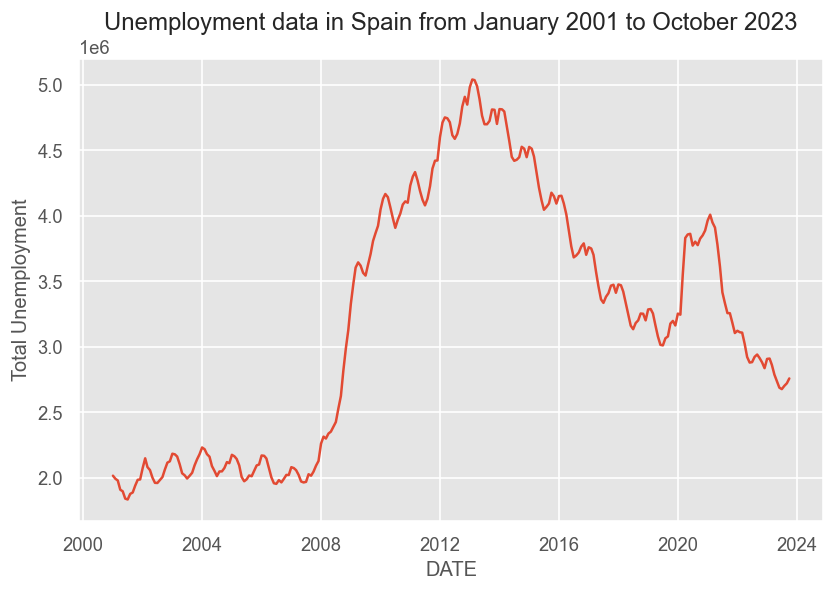

In [3]:
# Plotting a time series
fig, ax = plt.subplots()

ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2023', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [4]:
y = df
prop_train=0.88

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

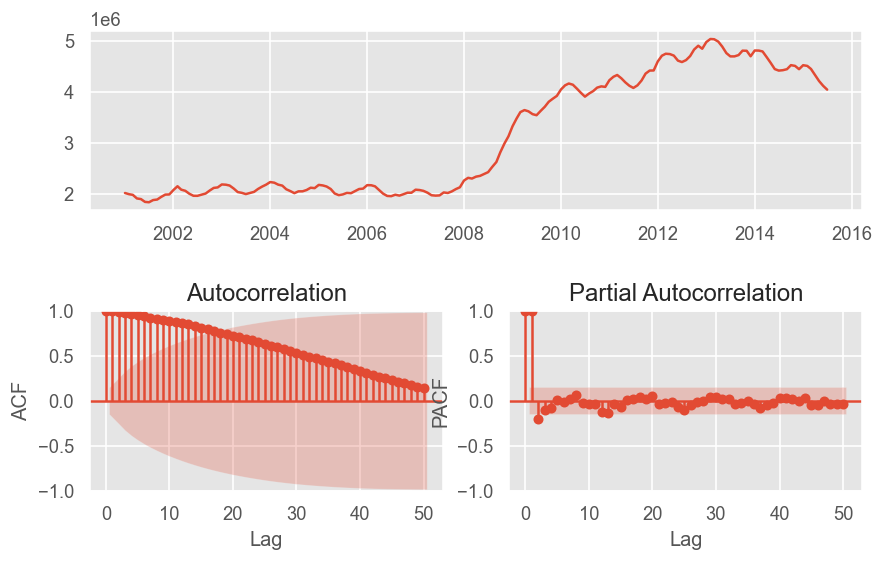

In [5]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

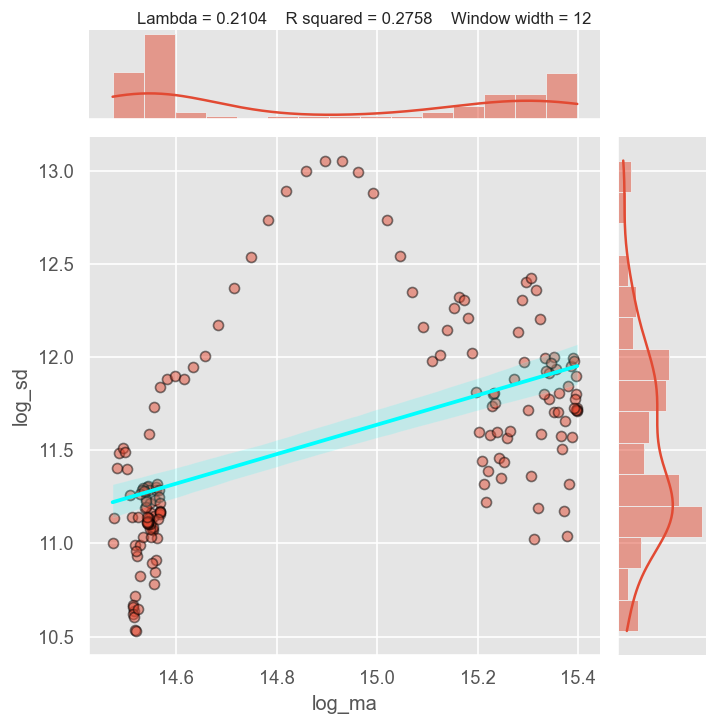

In [6]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

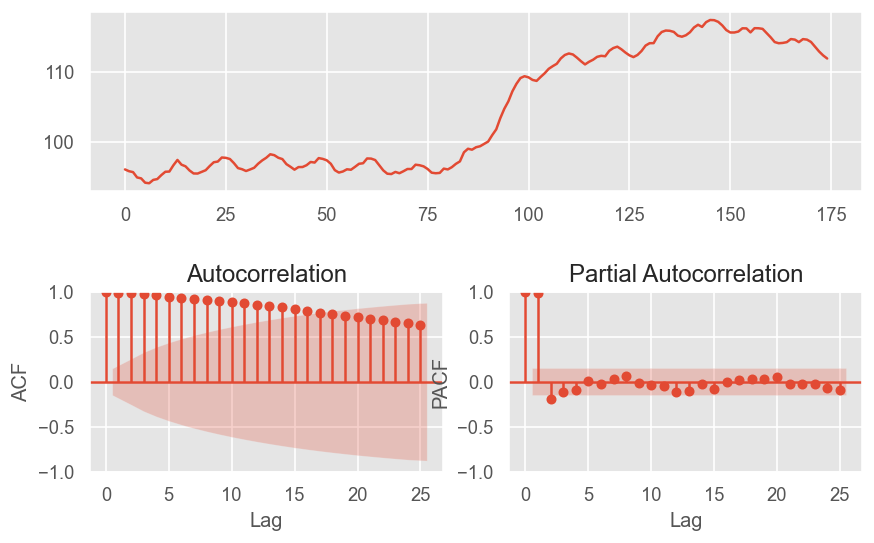

In [7]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

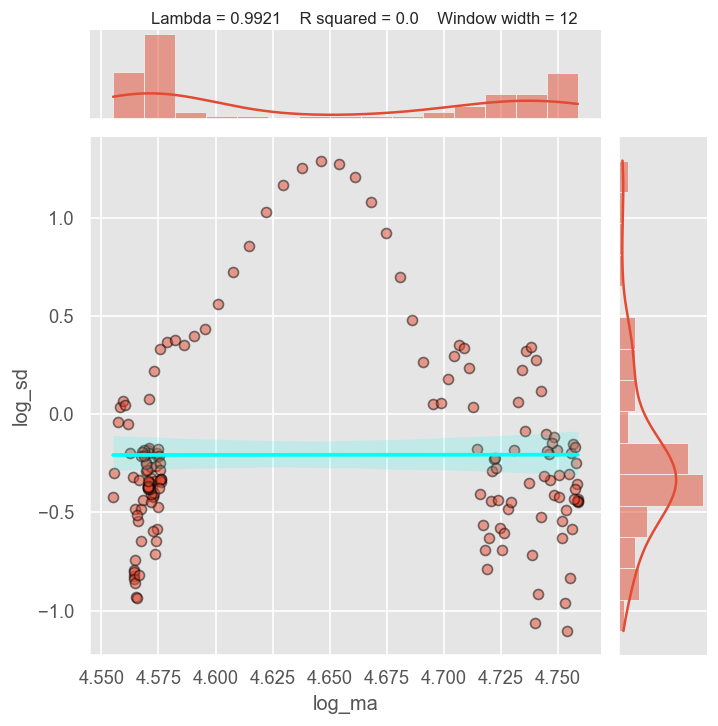

0.9921306069970893

In [8]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [8]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


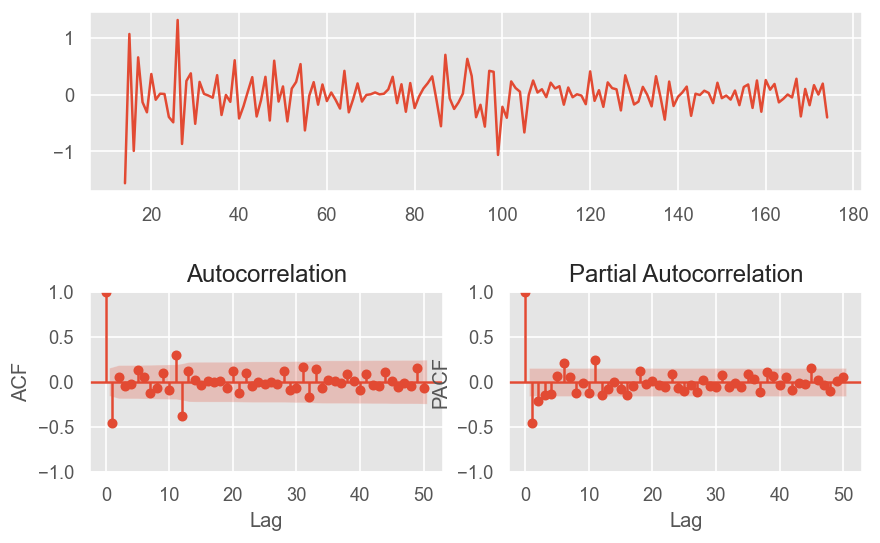

In [9]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

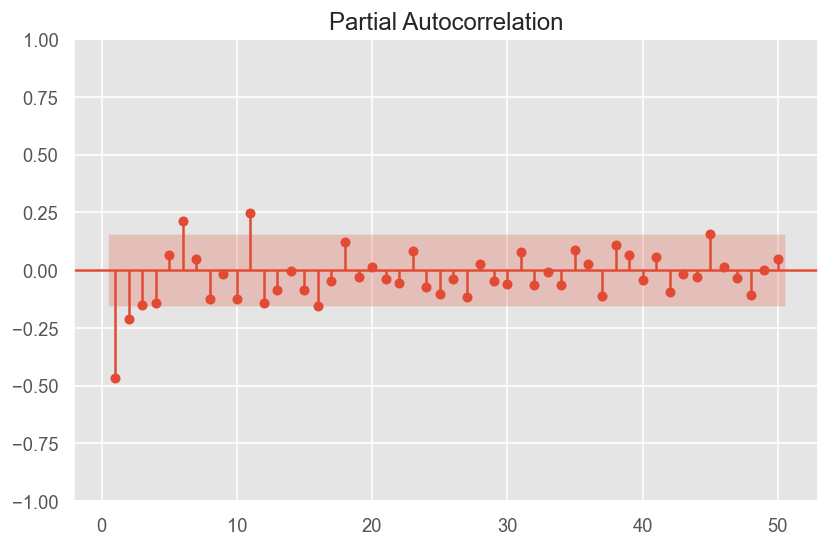

<Figure size 960x600 with 0 Axes>

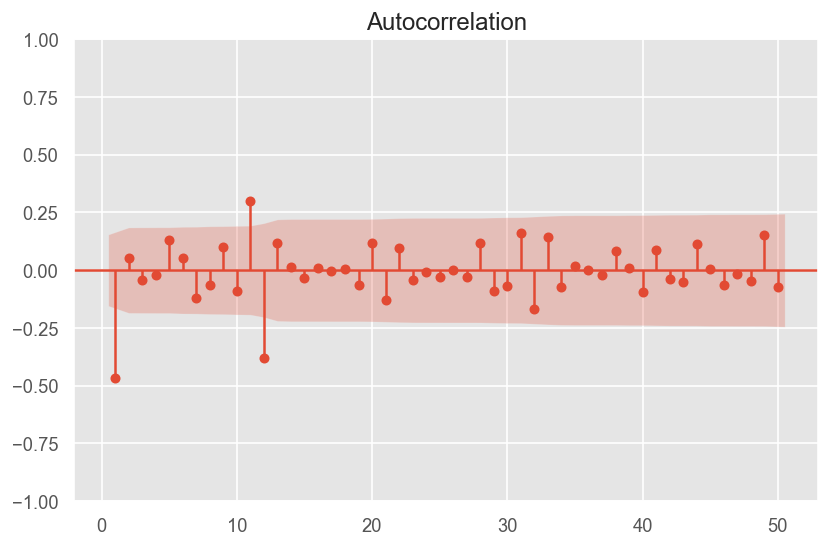

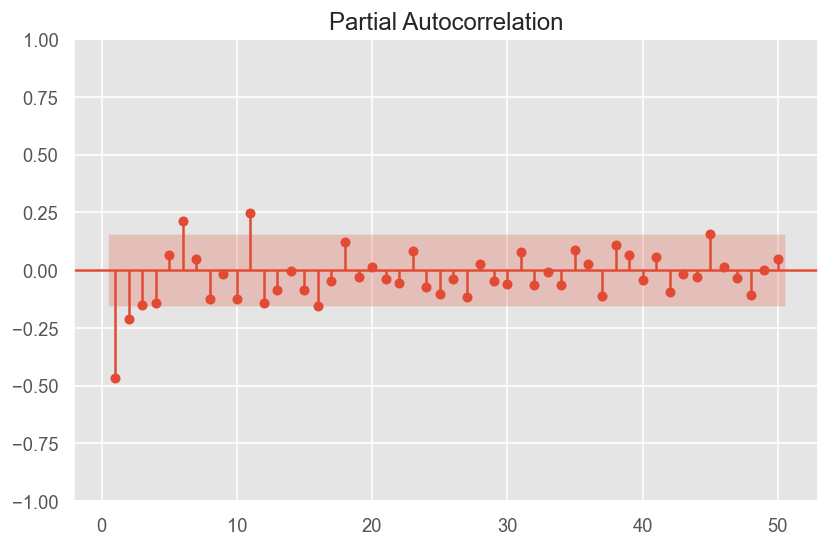

In [11]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [10]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  175
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  -3.797
Date:                            Thu, 30 Nov 2023   AIC                             13.594
Time:                                    09:10:45   BIC                             22.838
Sample:                                         0   HQIC                            17.347
                                            - 175                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6389      0.049    -12.985      0.000      -0.735      -0.542
ma.S.L12      -0.6935      0.080   

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  31.812202   0.163518


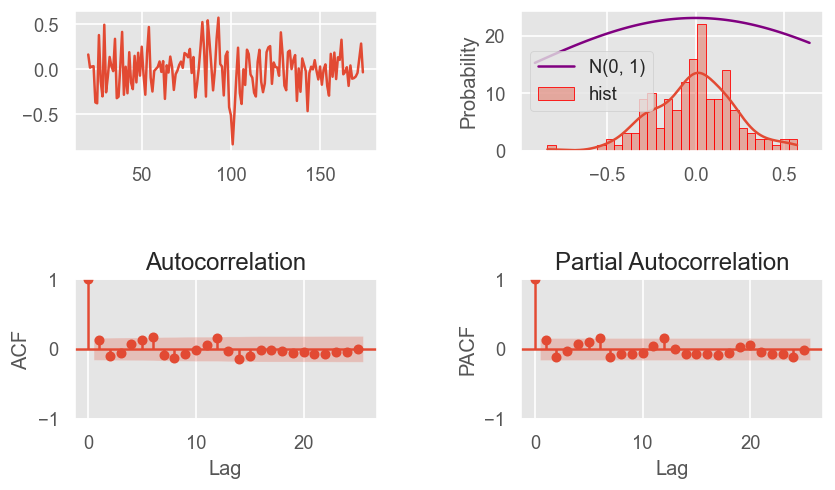

In [11]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [12]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  175
Model:             SARIMAX(6, 2, 0)x(0, 1, [1], 12)   Log Likelihood                   0.725
Date:                              Thu, 30 Nov 2023   AIC                             14.550
Time:                                      09:10:50   BIC                             39.201
Sample:                                           0   HQIC                            24.559
                                              - 175                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6497      0.061    -10.594      0.000      -0.770      -0.529
ar.L2         -0.39

#### 6. Analyze residuals

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.324358   0.828315


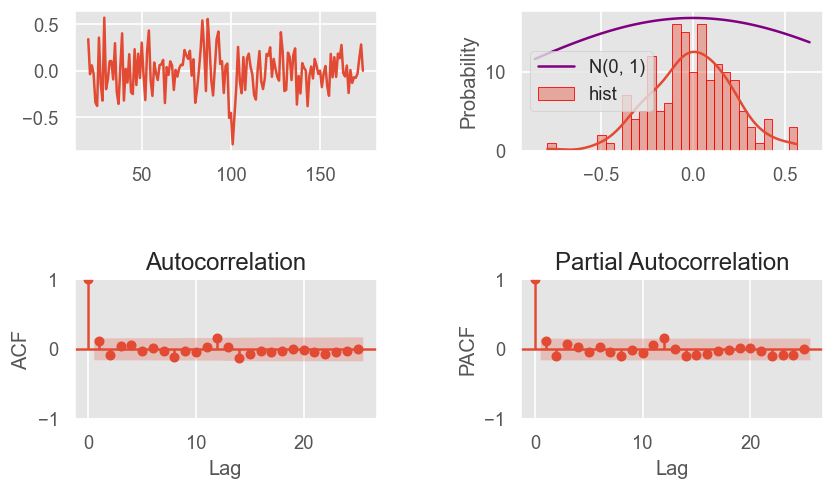

In [13]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

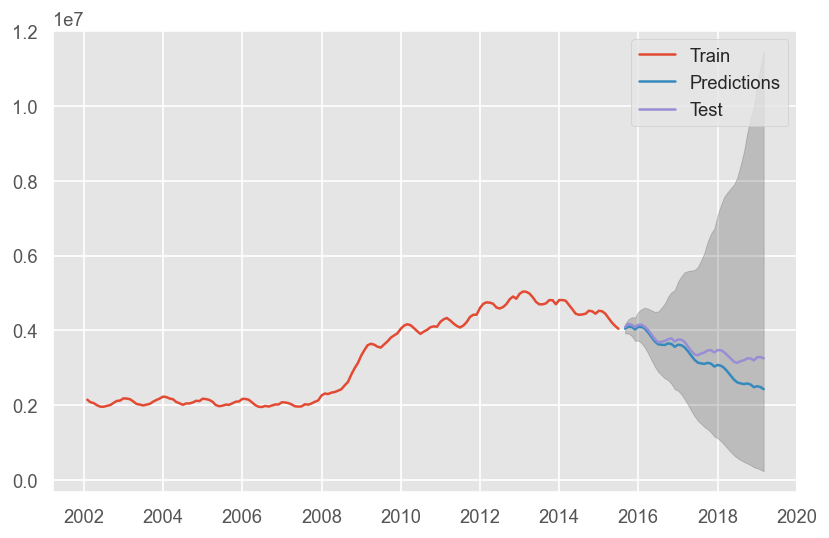

In [14]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

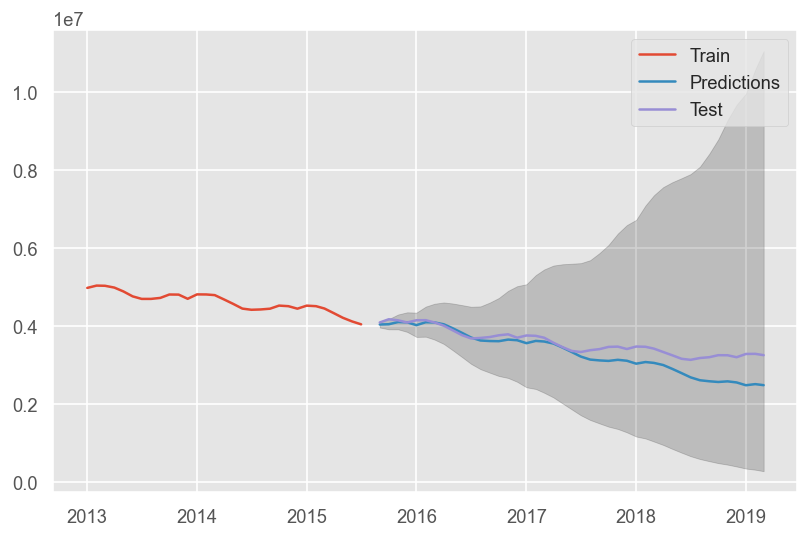

In [15]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [16]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266691.875229543
Test RMSE SARIMA 1 d = 2: 360943.5404256374


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [17]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 1: 210235.35596807319
Test RMSE SARIMA 1 d = 1: 240100.19945847962


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [18]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 234971.0232838794
Test RMSE SARIMA 2: 320144.3241232632


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

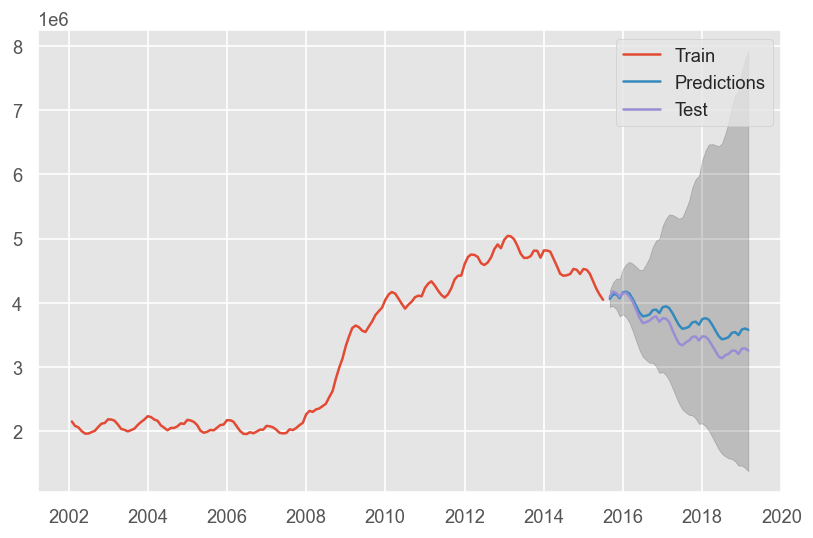

In [19]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

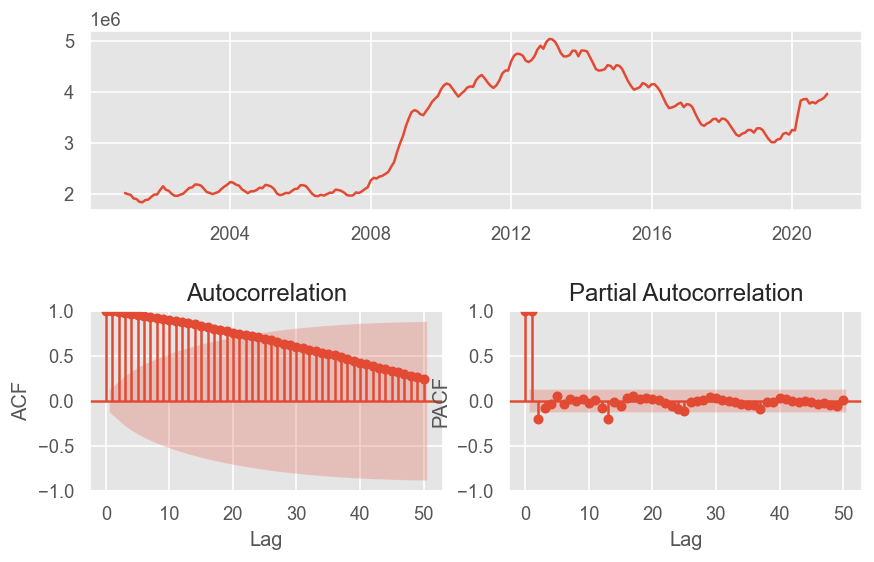

In [20]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

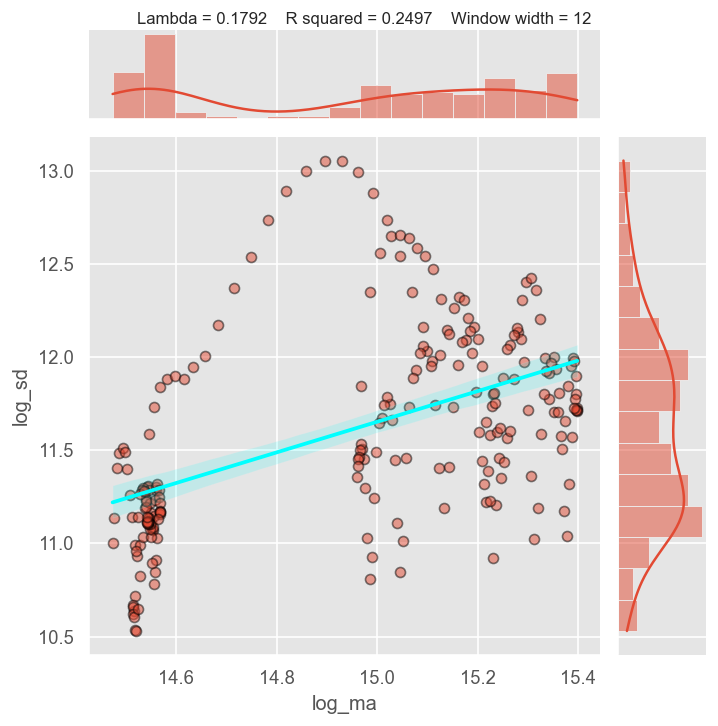

In [21]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

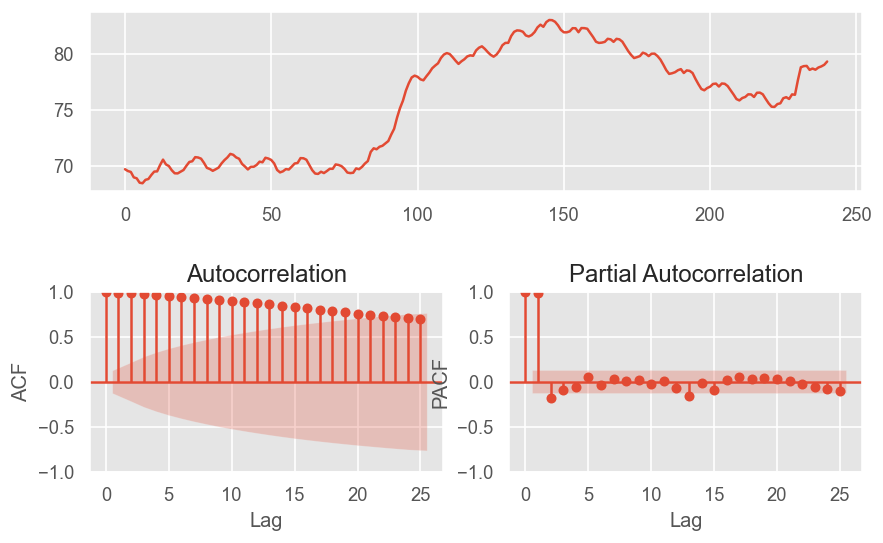

In [22]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

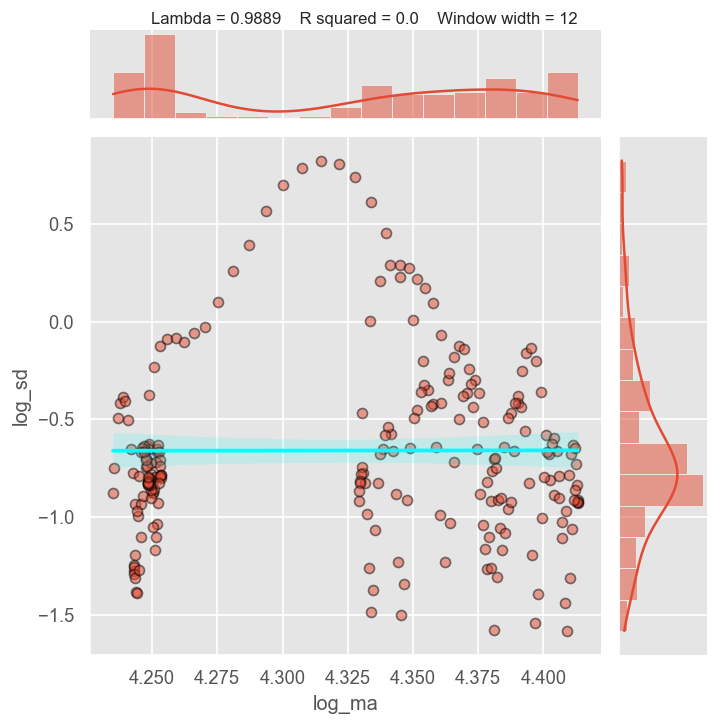

0.9889334090138302

In [23]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [24]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.593455
p-value: 0.486880
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


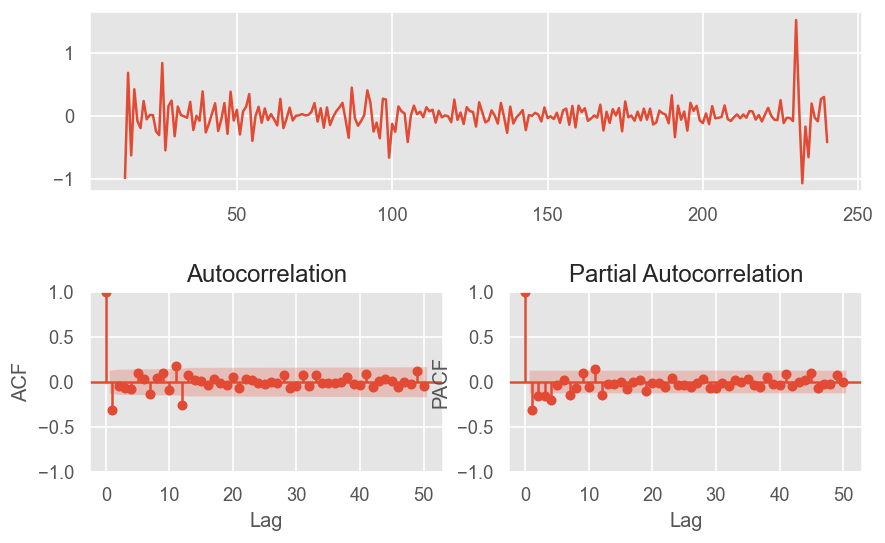

In [25]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [26]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                  54.759
Date:                            Thu, 30 Nov 2023   AIC                           -101.518
Time:                                    09:11:19   BIC                            -87.819
Sample:                                         0   HQIC                           -95.990
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4420      0.053      8.344      0.000       0.338       0.546
ma.L1         -0.8859      0.038   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  9.939538   0.996812


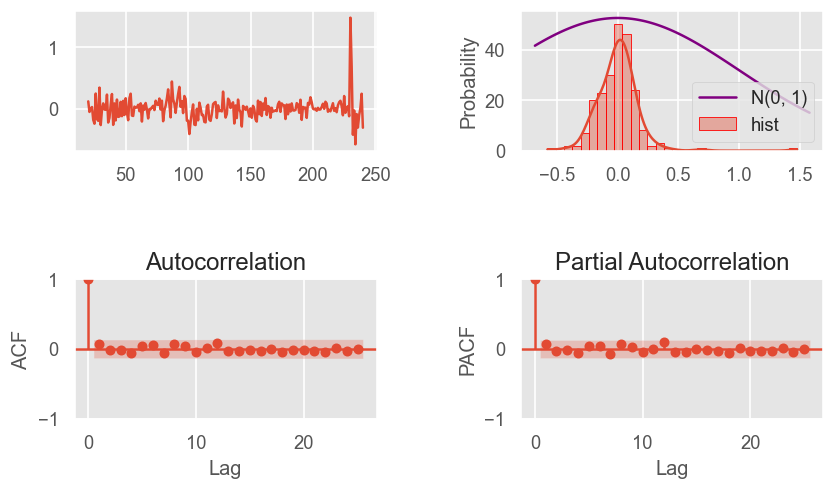

In [27]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

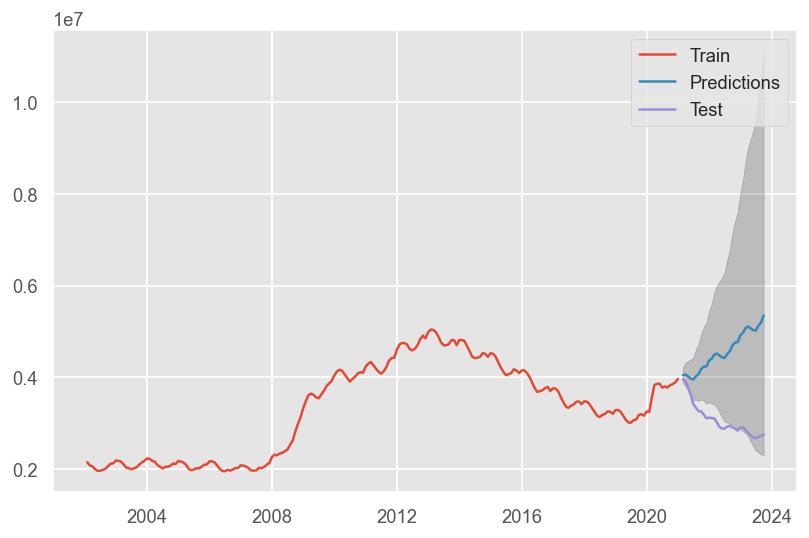

In [28]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [29]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1498170.7909503984
Test RMSE SARIMA 1 d = 2: 1664354.466548766


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [30]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  56.307
Date:                            Thu, 30 Nov 2023   AIC                           -104.615
Time:                                    09:11:27   BIC                            -90.898
Sample:                                         0   HQIC                           -99.080
                                            - 241                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7408      0.055     13.452      0.000       0.633       0.849
ma.L1         -0.2091      0.068   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  15.478827   0.929468


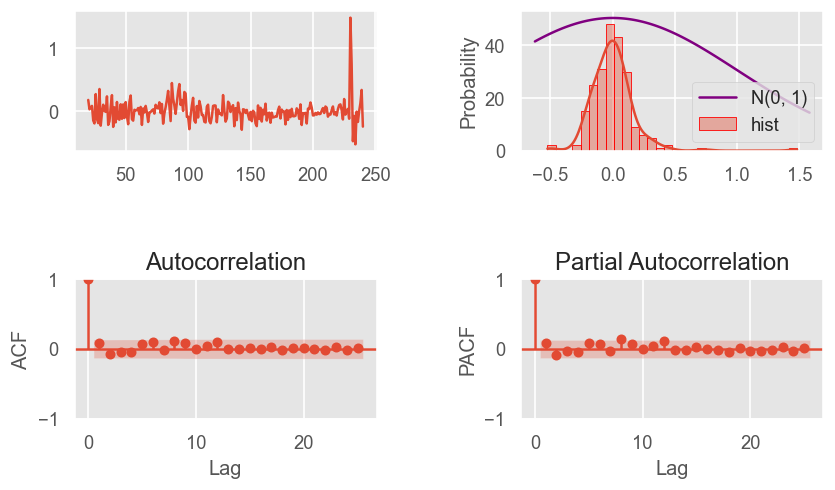

In [31]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

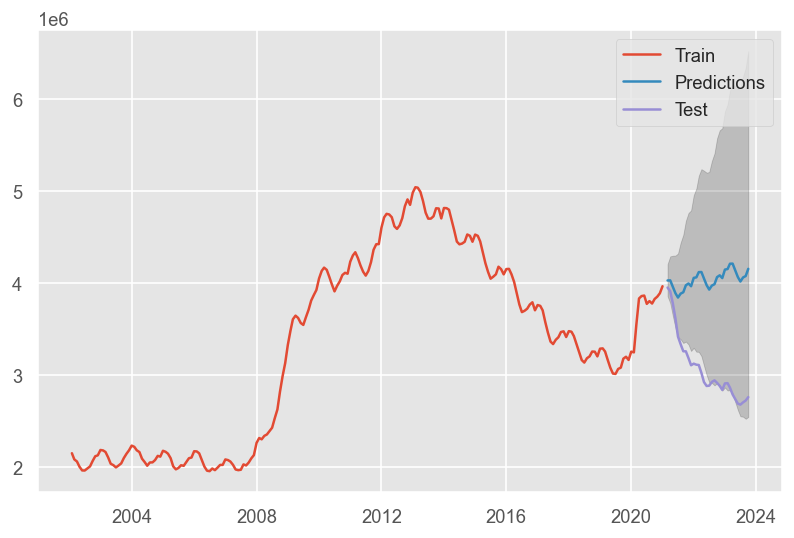

In [32]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [33]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 1: 969440.3246678566
Test RMSE SARIMA 1 d = 1: 1046767.441874995


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores (aún así, su intervalo de confianza es menor, lo cual es bueno). De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [35]:
#df['COVID_Desc']=0
#df['COVID_Asc']=0
df['COVID']=0
df['CRISIS']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia ascendente en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia descendente en nuestra serie
periodo_zapatero_inicio= pd.to_datetime('2007-08-01')
periodo_zapatero_fin=pd.to_datetime('2013-01-01')


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_zapatero_inicio:periodo_zapatero_fin, 'CRISIS'] =1
#df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID_Asc'] =1

prop_train=0.88#Proporción de datos usada para entrenamiento


print(df['COVID'].value_counts())
df['CRISIS'].value_counts()

COVID
0    257
1     17
Name: count, dtype: int64


CRISIS
0    208
1     66
Name: count, dtype: int64

In [36]:
INPUTS_SARMAX = ['COVID','CRISIS']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

X_train2

COVID  CRISIS
DATE                     
2001-01-01      0       0
2001-02-01      0       0
2001-03-01      0       0
2001-04-01      0       0
2001-05-01      0       0
...           ...     ...
2020-09-01      1       0
2020-10-01      1       0
2020-11-01      1       0
2020-12-01      1       0
2021-01-01      1       0

[241 rows x 2 columns]

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

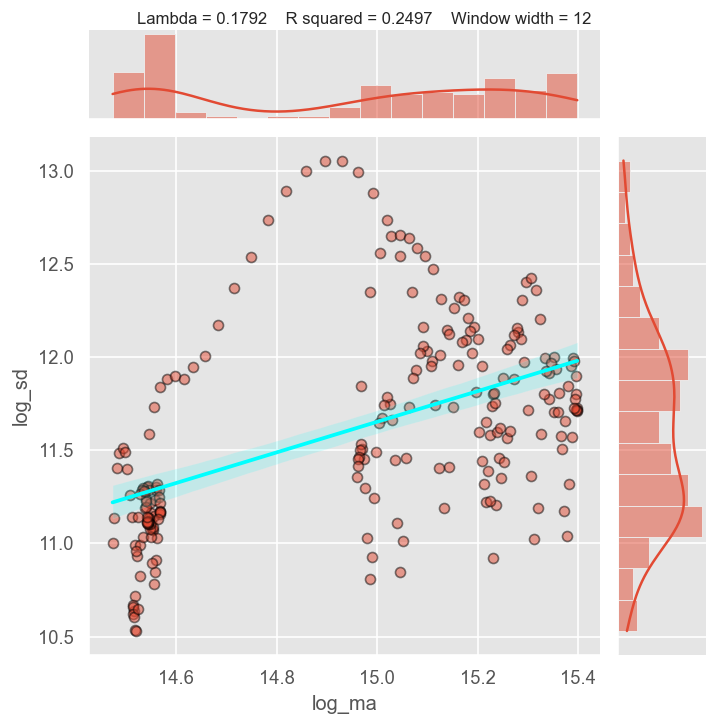

In [37]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

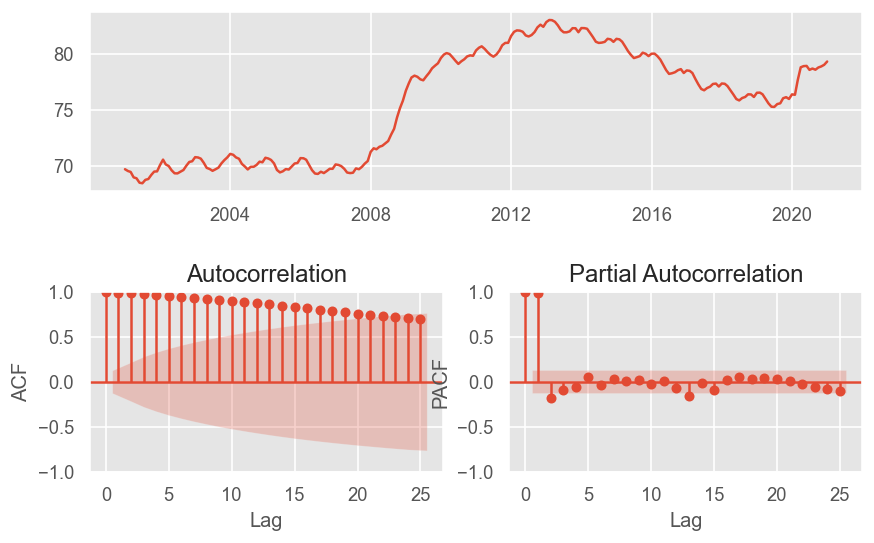

In [38]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [39]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  73.349
Date:                            Thu, 30 Nov 2023   AIC                           -134.698
Time:                                    09:12:01   BIC                           -114.121
Sample:                                01-01-2001   HQIC                          -126.396
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID          0.9777      0.054     18.178      0.000       0.872       1.083
CRISIS         0.0540      0.206   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  35.339783   0.941995


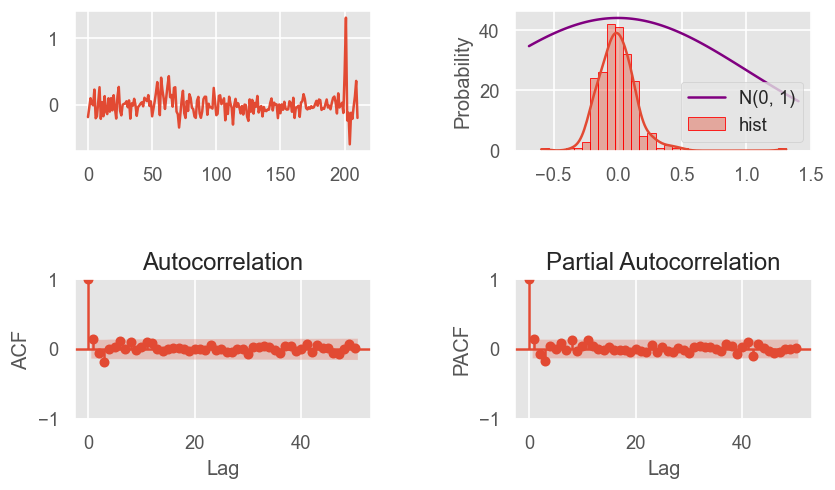

In [40]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)
 

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

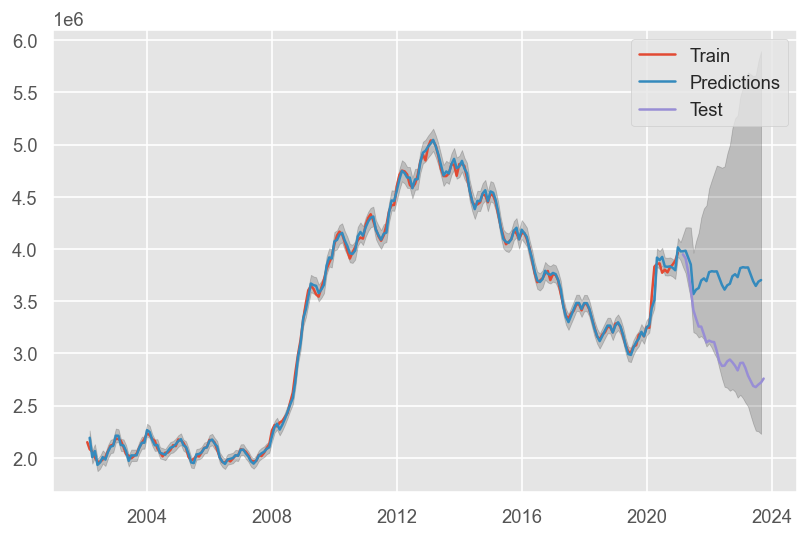

In [41]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [42]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY:',math.sqrt(mean_squared_error(y_test2, yhat)))
 

Test MAE SARIMAX DUMMY: 669008.2058996782
Test RMSE SARIMAX DUMMY: 734395.9874590327


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

# SARIMAX DUMMY 1/-1

In [43]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2020-03-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2020-03-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =-1


df['COVID'].astype('category')

df['COVID'].value_counts()#únicamente el COVID afecta a un 11% de nuestras observaciones

COVID
 0    273
-1      1
Name: count, dtype: int64

In [44]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

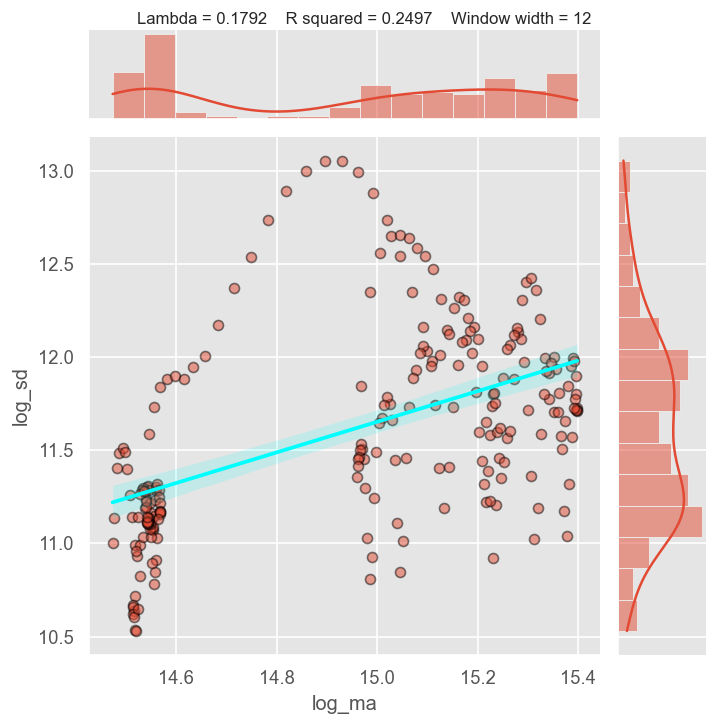

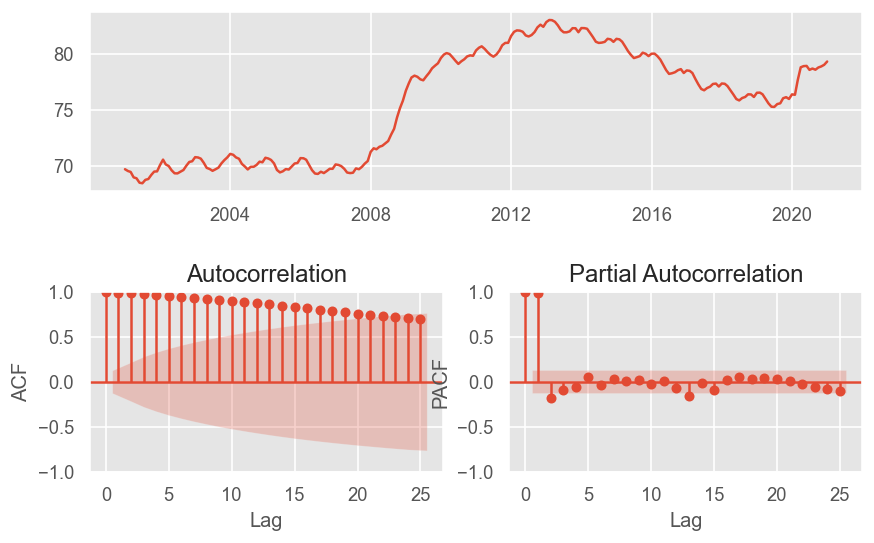

In [45]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)



In [46]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  56.381
Date:                            Thu, 30 Nov 2023   AIC                           -102.761
Time:                                    09:12:27   BIC                            -85.614
Sample:                                01-01-2001   HQIC                           -95.843
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID         -0.0381      0.036     -1.050      0.294      -0.109       0.033
ar.L1          0.7370      0.062   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  27.161279   0.996536


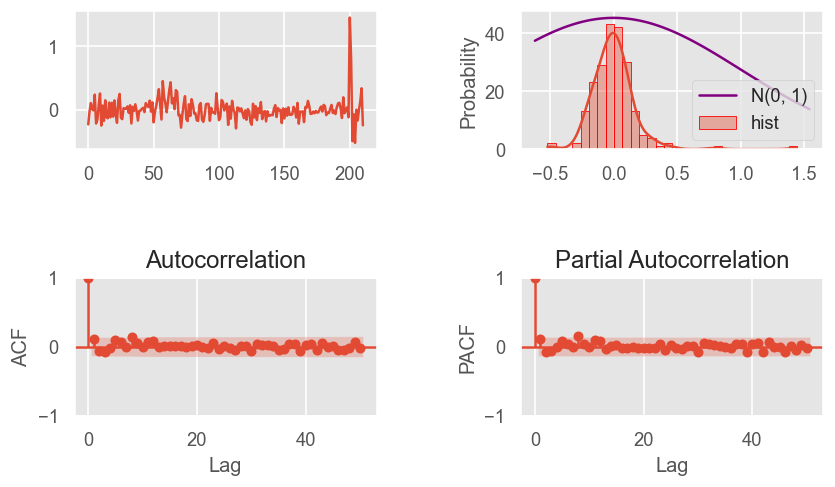

In [47]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

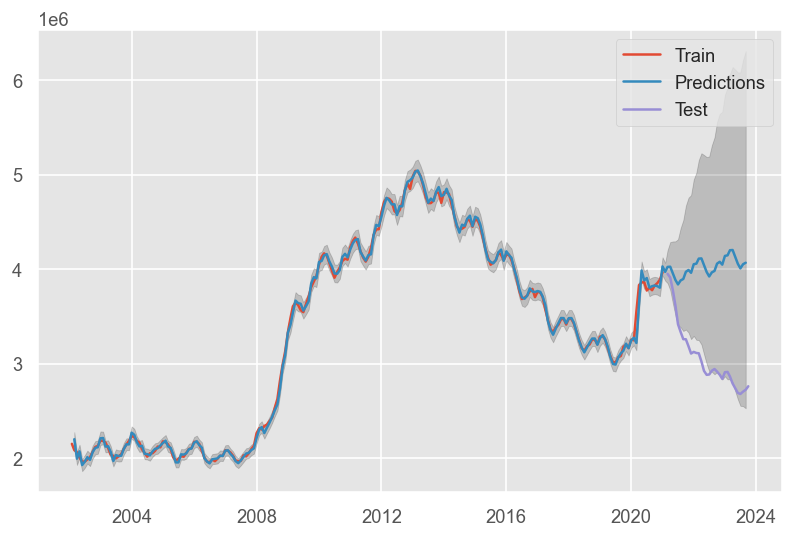

In [48]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [49]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX DUMMY -1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMAX DUMMY -1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX DUMMY -1: 950181.913648992
Test RMSE SARIMAX DUMMY -1: 1027931.5202822859


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

# SARIMAX TIME VARYING COEFS.

In [84]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1
#df.loc[periodo_covid_fin_1:periodo_covid_fin_2, 'COVID'] =-1


prop_train=0.88#Proporción de datos usada para entrenamiento o test

df['COVID'].describe() 

count    274.000000
mean       0.062044
std        0.241676
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COVID, dtype: float64

In [51]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create 88/12 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating i

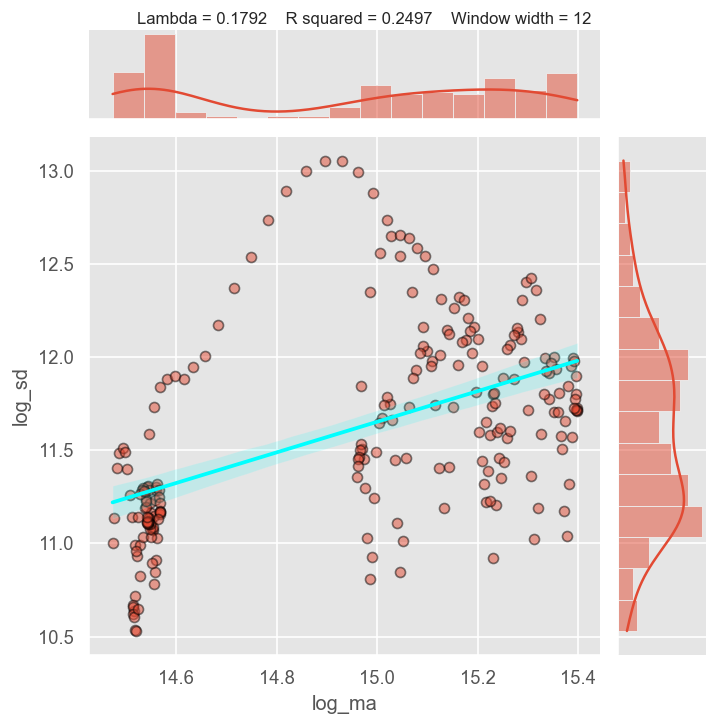

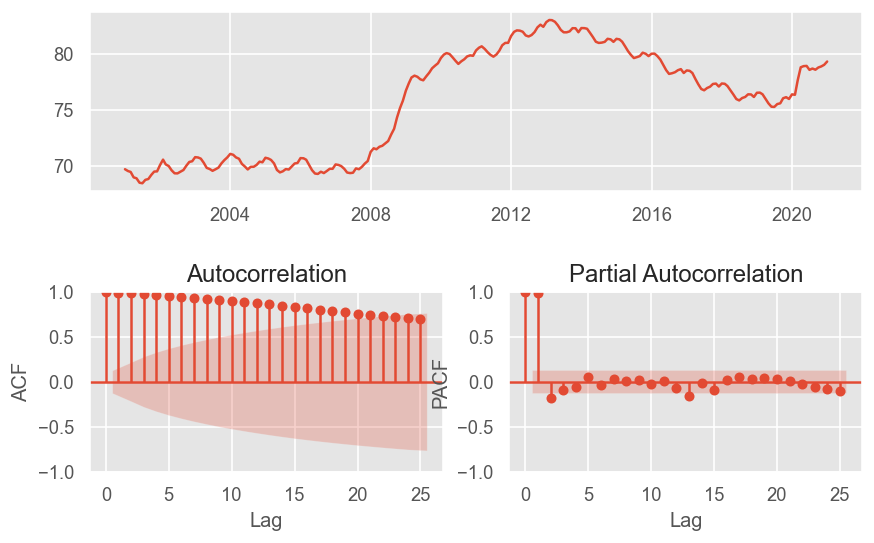

In [52]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)


# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [53]:
#time_varying_regression
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=True,
                            mle_regression=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  99.073
Date:                            Thu, 30 Nov 2023   AIC                           -188.147
Time:                                    09:12:42   BIC                           -171.022
Sample:                                01-01-2001   HQIC                          -181.237
                                     - 01-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7688      0.040     19.125      0.000       0.690       0.848
ma.L1          0.0970      0.075   

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  63.327612   0.097612


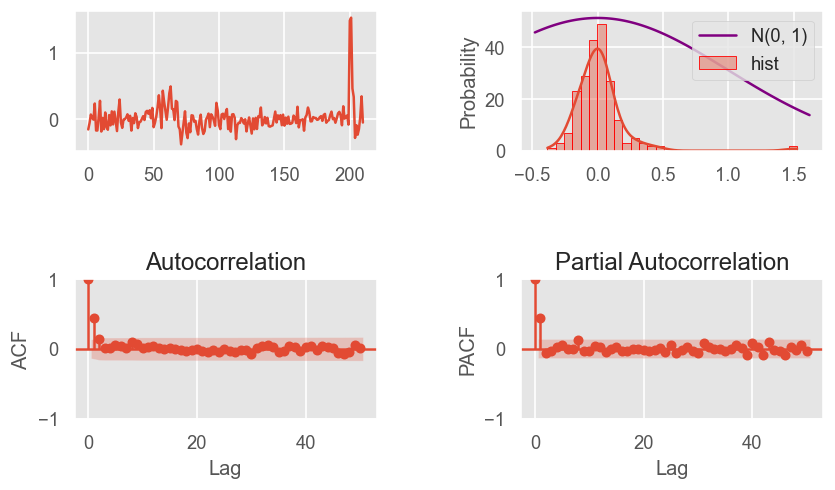

In [54]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)

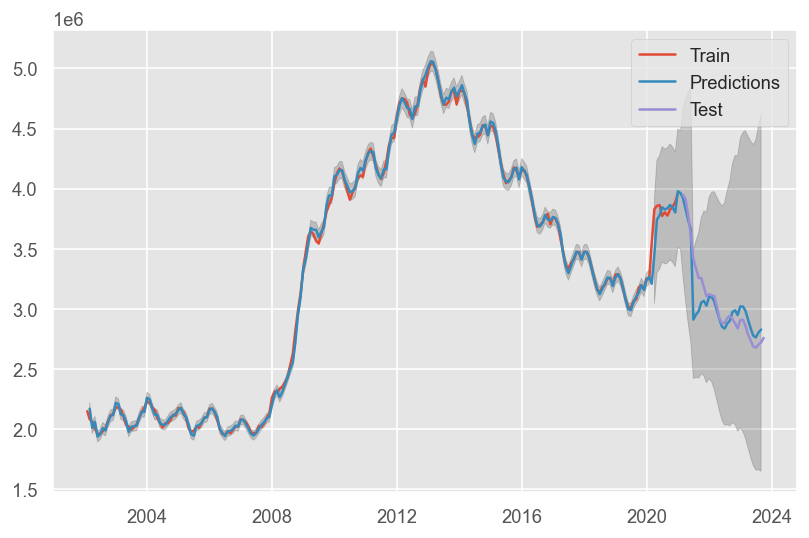

In [55]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [57]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

#Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMAX TVC:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA TVC:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMAX TVC: 105386.12927127442
Test RMSE SARIMA TVC: 149080.47325155718


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

# MLP_SIN_COVID

In [58]:
# Assuming 'DATE' is the index in your DataFrame
df.index = pd.to_datetime(df.index)

# Extract year and month
df['YEAR'] = df.index.year.astype('category')
df['MONTH'] = df.index.month.astype('category')


In [59]:
df

TOTAL  COVID  CRISIS  YEAR MONTH
DATE                                          
2001-01-01  2017389      0       0  2001     1
2001-02-01  1993273      0       0  2001     2
2001-03-01  1981006      0       0  2001     3
2001-04-01  1910453      0       0  2001     4
2001-05-01  1898285      0       0  2001     5
...             ...    ...     ...   ...   ...
2023-06-01  2688842      0       0  2023     6
2023-07-01  2677874      0       0  2023     7
2023-08-01  2702700      0       0  2023     8
2023-09-01  2722468      0       0  2023     9
2023-10-01  2759404      0       0  2023    10

[274 rows x 5 columns]

In [60]:
###Include lagged variables
dfT = df[['TOTAL','MONTH','YEAR']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
#dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL MONTH  YEAR  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3
DATE                                                               
2001-01-01  2017389     1  2001         NaN         NaN         NaN
2001-02-01  1993273     2  2001   2017389.0         NaN         NaN
2001-03-01  1981006     3  2001   1993273.0   2017389.0         NaN
2001-04-01  1910453     4  2001   1981006.0   1993273.0   2017389.0
2001-05-01  1898285     5  2001   1910453.0   1981006.0   1993273.0

In [61]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL MONTH  YEAR  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3
DATE                                                               
2001-04-01  1910453     4  2001   1981006.0   1993273.0   2017389.0
2001-05-01  1898285     5  2001   1910453.0   1981006.0   1993273.0
2001-06-01  1842556     6  2001   1898285.0   1910453.0   1981006.0
2001-07-01  1835738     7  2001   1842556.0   1898285.0   1910453.0
2001-08-01  1878513     8  2001   1835738.0   1842556.0   1898285.0

In [71]:
# Define input and output matrices
INPUTS= ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3']
#INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','MONTH','YEAR']

OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.64*y.shape[0])]
X_test = X.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity

X_train.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3
DATE                                          
2001-04-01   1981006.0   1993273.0   2017389.0
2001-05-01   1910453.0   1981006.0   1993273.0
2001-06-01   1898285.0   1910453.0   1981006.0
2001-07-01   1842556.0   1898285.0   1910453.0
2001-08-01   1835738.0   1842556.0   1898285.0

In [72]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3']
INPUTS_MLP_CAT=[]
#INPUTS_MLP_CAT = ['MONTH','YEAR'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.0001,0.001,0.01,0.1,1], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(15,),(20,),(25,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid
print("MLP Trained")

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

MLP Trained


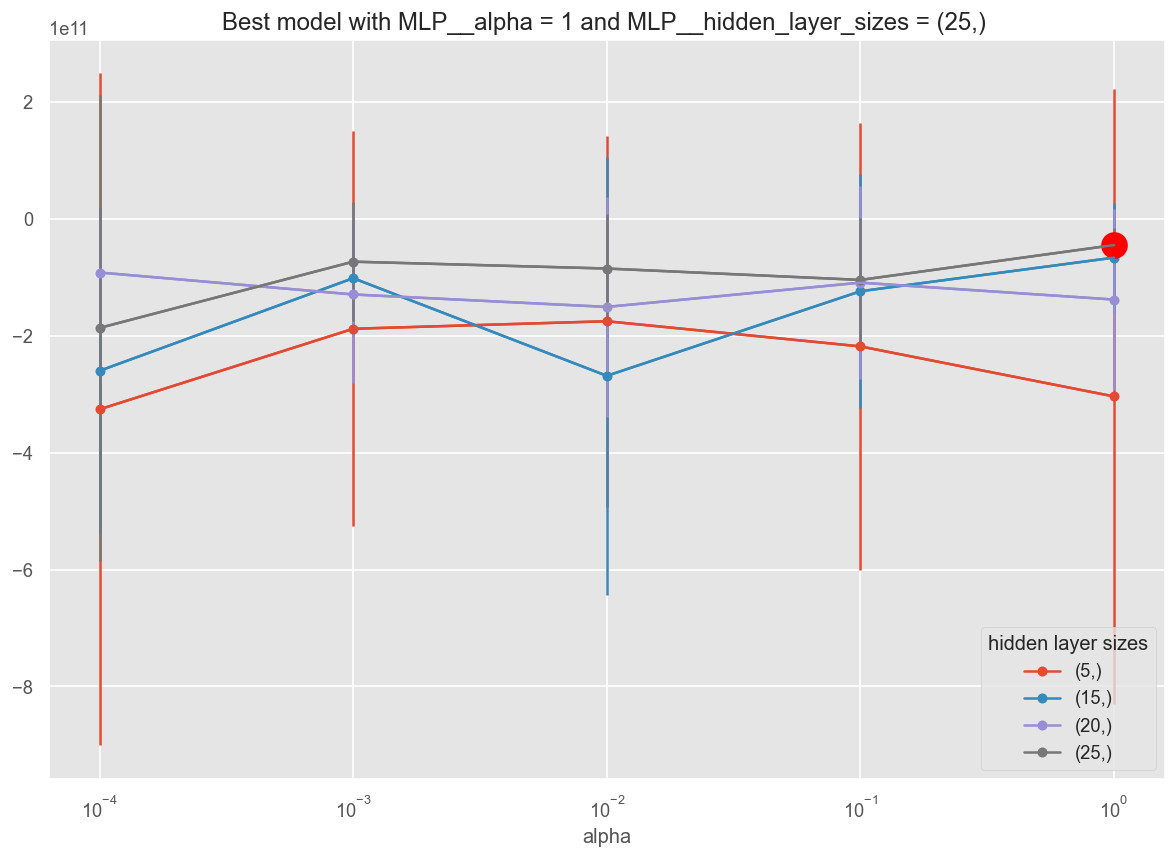

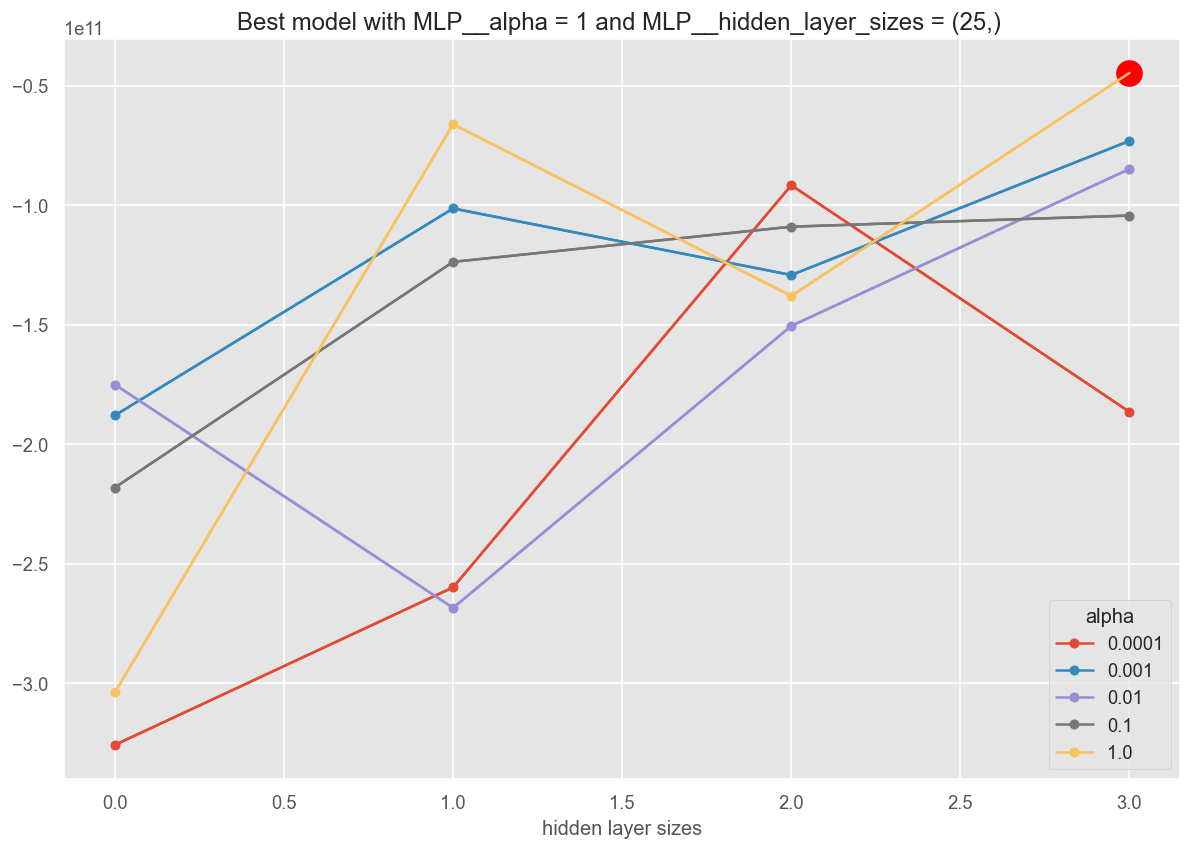

In [73]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [76]:
X

numpy.ndarray

In [78]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)

#X = pd.DataFrame(X.toarray(), columns=coefnames)
y = pd.DataFrame(y_train, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [3, 25, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                         mean           std  mean_squared
num__TOTAL_lag1 -3.325245e+06  7.241456e+07  7.249087e+07
num__TOTAL_lag2 -4.288342e+06  7.502053e+07  7.514299e+07
num__TOTAL_lag3 -4.865926e+06  7.517959e+07  7.533690e+07


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\neuralsens\partial_derivatives.py:1472: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(sens_out["mean"][i], sens_out["std"][i]),
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


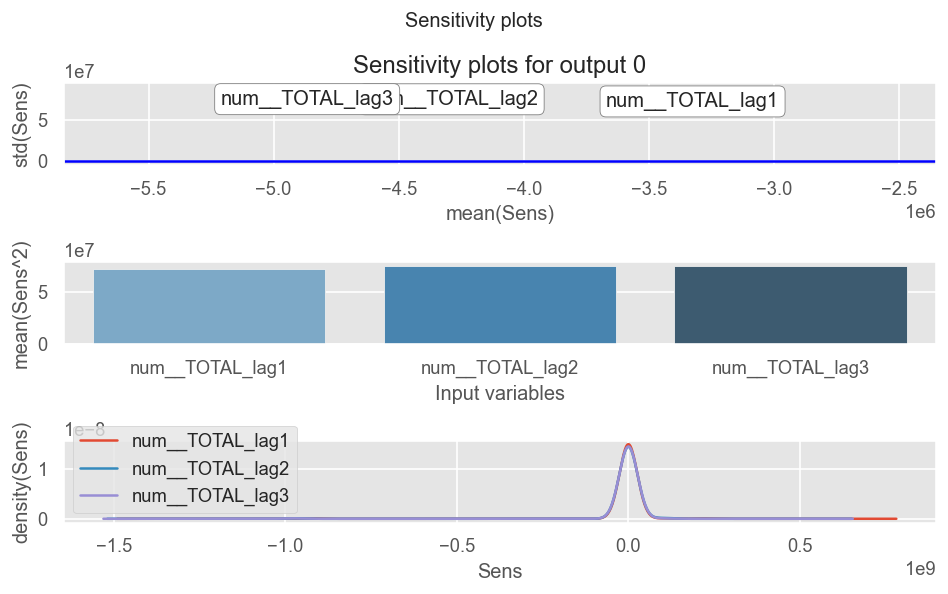

In [79]:
sensmlp.plot()

In [80]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 112137.41342726027
Test MAE: 194718.33073171062
Training RMSE: 144329.8817627077
Test RMSE: 258921.426600225
Training R2: 0.9844469770112161
Test R2: 0.33253803146999794


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

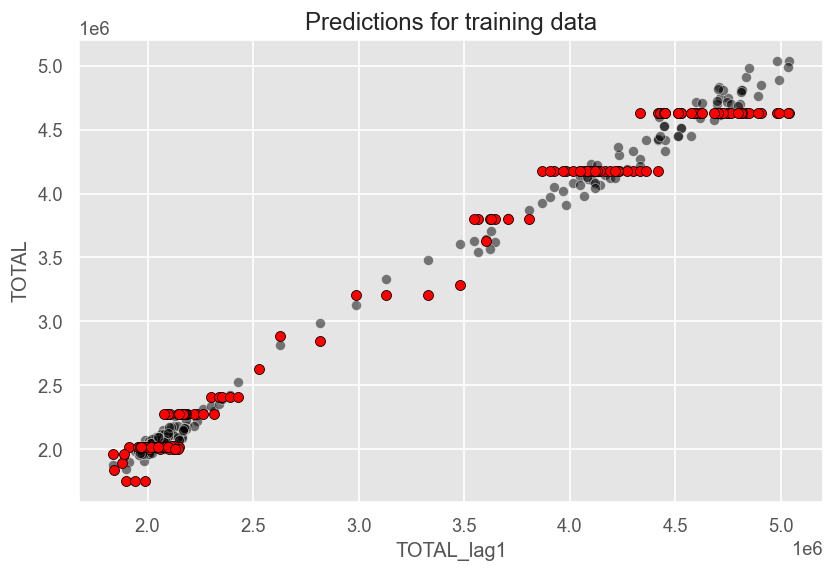

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

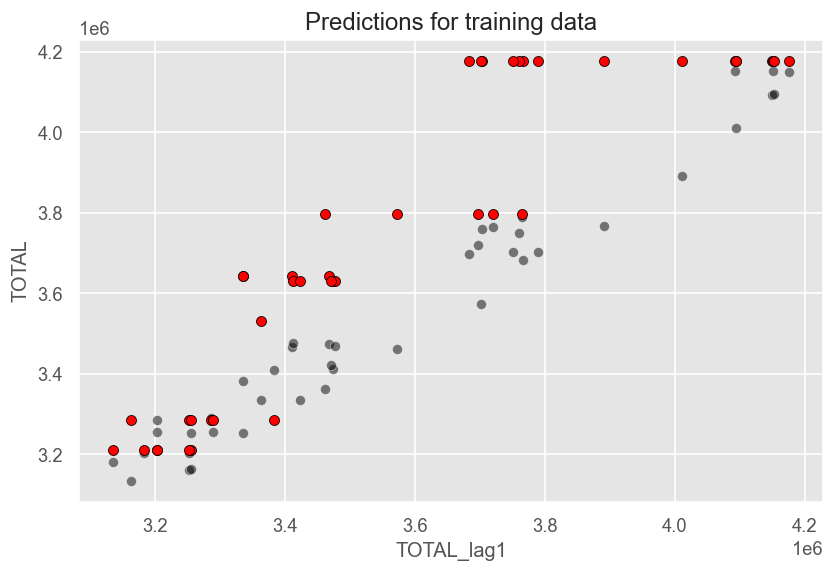

In [81]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

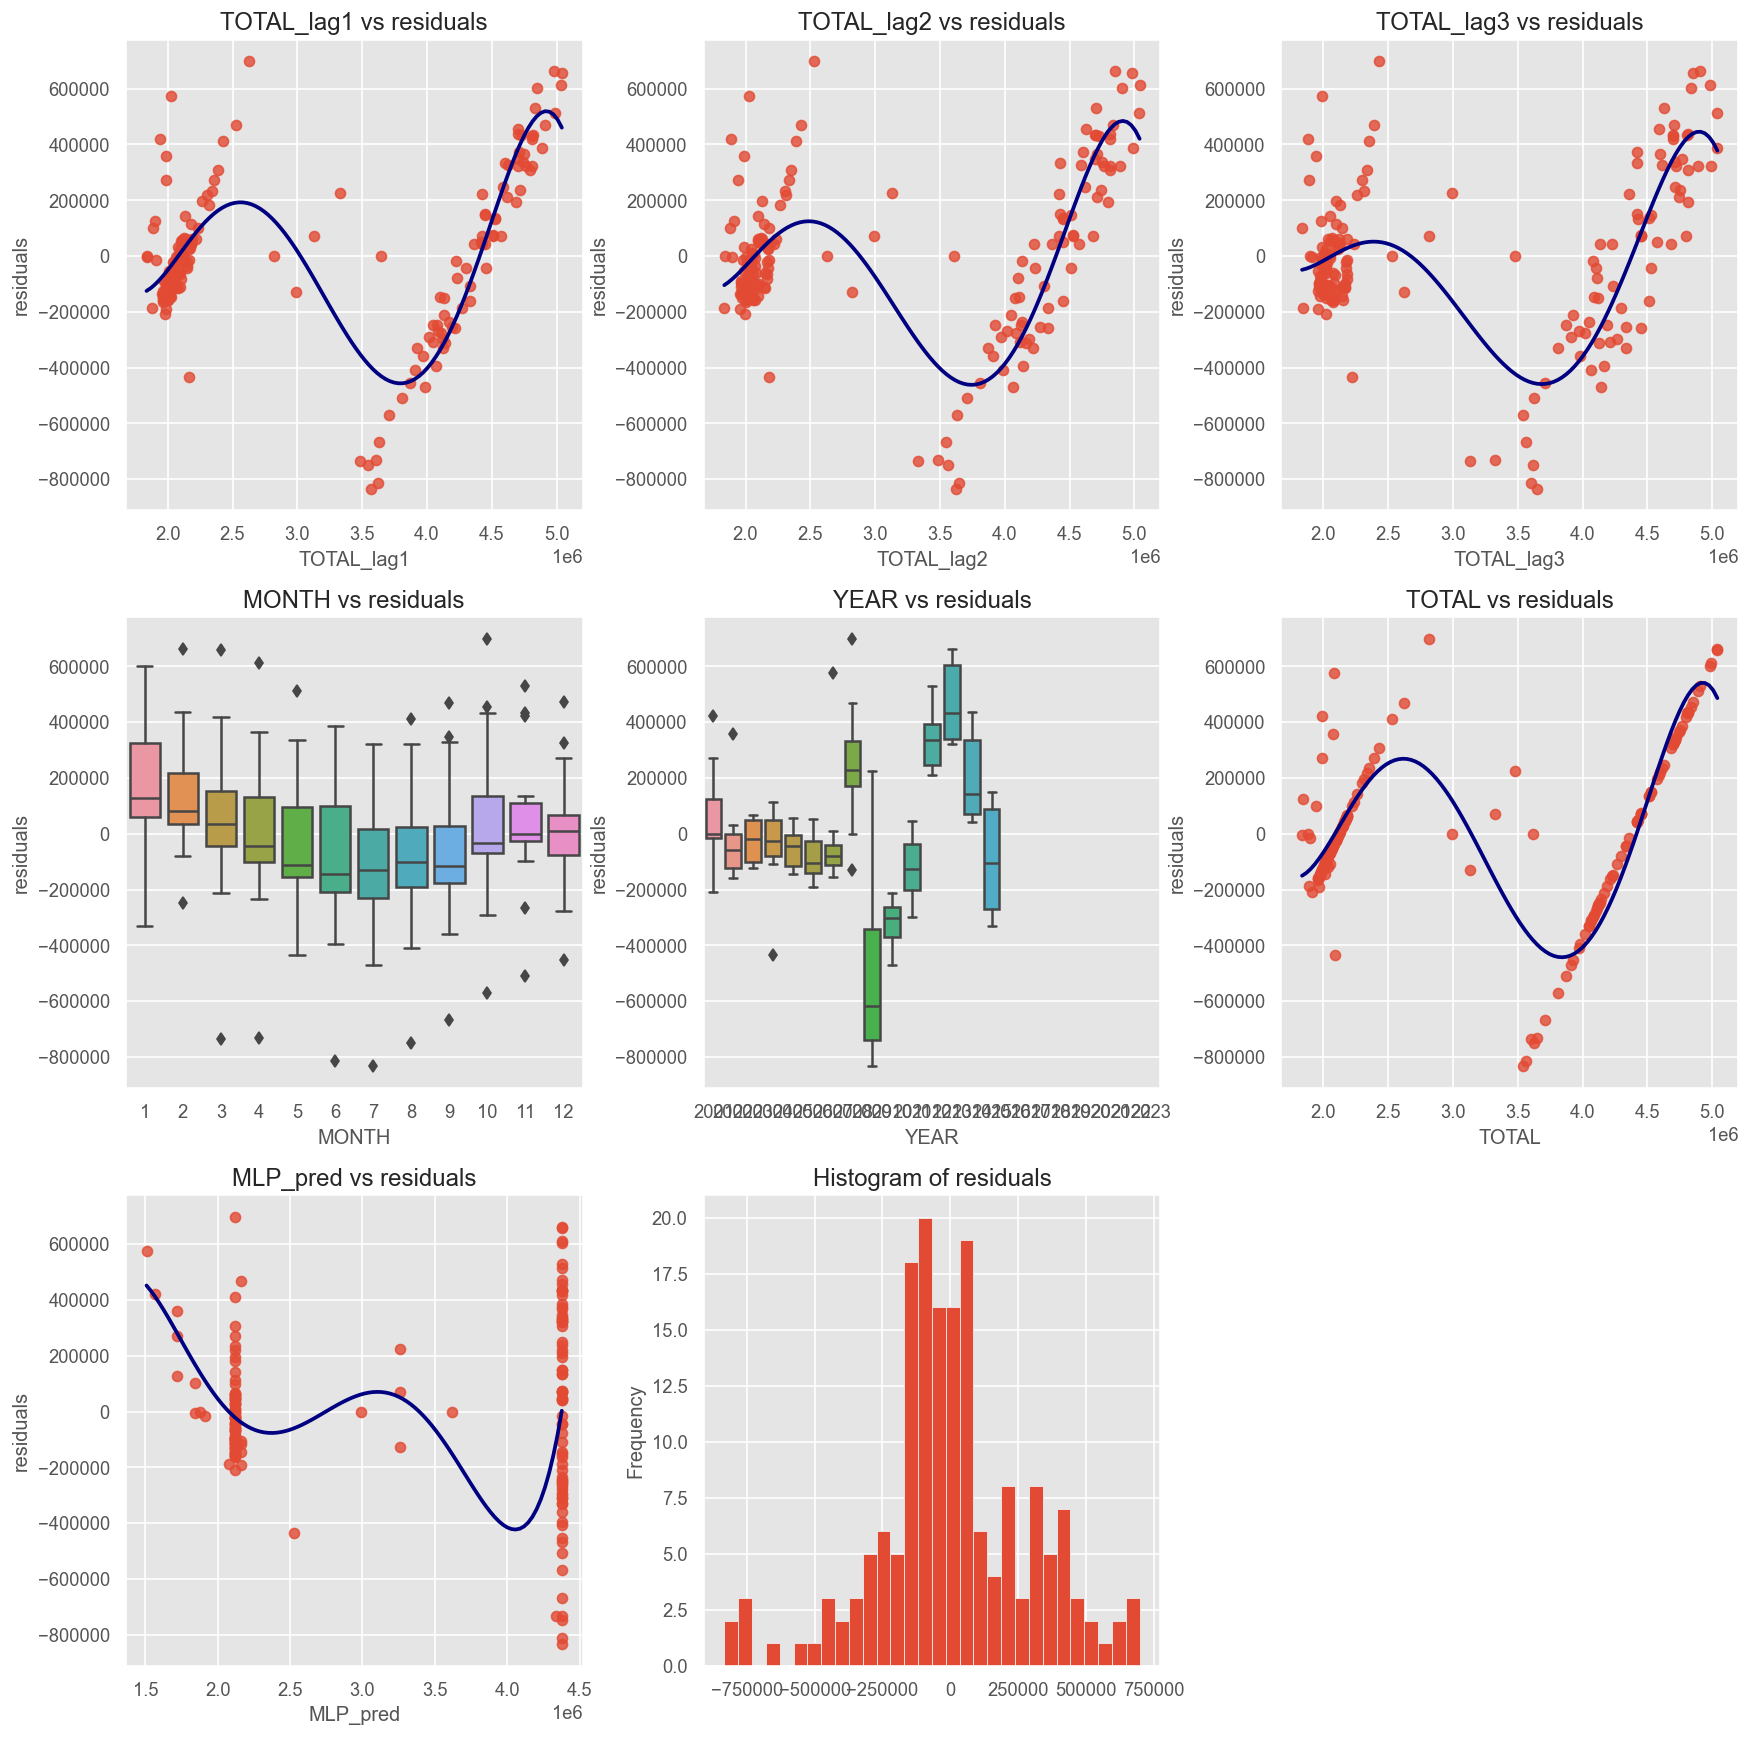

In [56]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

# MLP_Con_Covid

In [90]:
# Extract year and month
df['COVID'] = df.COVID.astype('category')

In [93]:
###Include lagged variables
dfT = df[['TOTAL','COVID','MONTH','YEAR']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
#dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL COVID MONTH  YEAR  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3
DATE                                                                     
2001-01-01  2017389     0     1  2001         NaN         NaN         NaN
2001-02-01  1993273     0     2  2001   2017389.0         NaN         NaN
2001-03-01  1981006     0     3  2001   1993273.0   2017389.0         NaN
2001-04-01  1910453     0     4  2001   1981006.0   1993273.0   2017389.0
2001-05-01  1898285     0     5  2001   1910453.0   1981006.0   1993273.0

In [94]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL COVID MONTH  YEAR  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3
DATE                                                                     
2001-04-01  1910453     0     4  2001   1981006.0   1993273.0   2017389.0
2001-05-01  1898285     0     5  2001   1910453.0   1981006.0   1993273.0
2001-06-01  1842556     0     6  2001   1898285.0   1910453.0   1981006.0
2001-07-01  1835738     0     7  2001   1842556.0   1898285.0   1910453.0
2001-08-01  1878513     0     8  2001   1835738.0   1842556.0   1898285.0

In [131]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','COVID','MONTH','YEAR']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  COVID MONTH  YEAR
DATE                                                             
2004-04-01   2181546.0   2219300.0   2232560.0      0     4  2004
2004-05-01   2162406.0   2181546.0   2219300.0      0     5  2004
2004-06-01   2090702.0   2162406.0   2181546.0      0     6  2004
2004-07-01   2054113.0   2090702.0   2162406.0      0     7  2004
2004-08-01   2014218.0   2054113.0   2090702.0      0     8  2004

In [61]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3']
INPUTS_MLP_CAT = ['MONTH','YEAR','COVID'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.001, 0.01,0.1,1,10], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(3,), (5,),(5,5),(10,),(20,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train2[INPUTS_MLP], y_train2) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24089D+12    |proj g|=  3.39449D+06

At iterate    1    f=  6.24054D+12    |proj g|=  1.89762D+07

At iterate    2    f=  1.89869D+12    |proj g|=  1.46304D+06

At iterate    3    f=  1.09214D+12    |proj g|=  5.96509D+05

At iterate    4    f=  3.11229D+11    |proj g|=  4.58476D+05

At iterate    5    f=  1.92916D+11    |proj g|=  3.19838D+05

At iterate    6    f=  1.44987D+11    |proj g|=  2.69469D+04

At iterate    7    f=  1.44436D+11    |proj g|=  1.86218D+04

At iterate    8    f=  1.42182D+11    |proj g|=  2.33366D+04

At iterate    9    f=  1.41787D+11    |proj g|=  6.05649D+03

At iterate   10    f=  1.41768D+11    |proj g|=  3.99439D+02

At iterate   11    f=  1.41768D+11    |proj g|=  2.42599D+01

At iterate   12    f=  1.41768D+11    |proj g|=  2.16009D+00
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations

ate    3    f=  2.21184D+12    |proj g|=  1.84663D+06

At iterate    4    f=  4.24766D+11    |proj g|=  3.21225D+05

At iterate    5    f=  3.52939D+11    |proj g|=  2.87665D+05

At iterate    6    f=  1.85815D+11    |proj g|=  7.94271D+04

At iterate    7    f=  1.78103D+11    |proj g|=  5.38797D+04

At iterate    8    f=  1.68270D+11    |proj g|=  4.24071D+04

At iterate    9    f=  1.65624D+11    |proj g|=  4.24876D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          109     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23421D+12    |proj g|=  3.39100D+06

At iterate    1    f=  6.23419D+12    |proj g|=  3.39100D+06

At iterate   10    f=  1.65218D+11    |proj g|=  2.40726D+06
  ys=-1.985E+08  -gs= 4.052E+08 BFGS update SKIPPED
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          109     M =           10

At X0         0 variables are exactly at the bounds

A

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning

At iterate   39    f=  5.65061D+10    |proj g|=  1.01433D+02

At iterate  363    f=  1.57766D+11    |proj g|=  1.55865D+06

At iterate   40    f=  5.65060D+10    |proj g|=  2.29451D+01

At iterate  364    f=  1.57766D+11    |proj g|=  1.42223D+06

At iterate   41    f=  5.65060D+10    |proj g|=  4.71669D+00

At iterate  365    f=  1.57766D+11    |proj g|=  1.71222D+06

At iterate  366    f=  1.57766D+11    |proj g|=  3.76582D+06

At iterate   42    f=  5.65060D+10    |proj g|=  2.69926D+00

At iterate  367    f=  1.57766D+11    |proj g|=  1.34394D+06

At iterate   43    f=  5.65060D+10    |proj g|=  4.76960D+00

At iterate  368    f=  1.57766D+11    |proj g|=  4.74625D+05

At iterate  369    f=  1.57766D+11    |proj g|=  3.81562D+05

At iterate  370    f=  1.57766D+11    |proj g|=  3.78993D+05

At iterate   44    f=  5.65060D+10    |proj g|=  1.34840D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 Projg        F
  103     17     25      1     0     0   1.626D+00   8.951D+10
  F =   89513746153.524643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          211     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25696D+12    |proj g|=  3.09919D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          211     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11442D+12    |proj g|=  3.34379D+06

At iterate    1    f=  3.66172D+12    |proj g|=  2.53269D+06

At iterate    2    f=  4.54466D+11    |proj g|=  2.78748D+00

At iterate    1    f=  4.38062D+12    |proj g|=  2.77729D+06

At iterate    2    f=  5.23960D+11    |proj g|=  3.03723D+00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          211     M =           10

At X0 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


kipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  211      8     34      1     0     0   9.640D-02   4.622D+11
  F =   462223890427.90826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          351     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24089D+12    |proj g|=  3.39449D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          211     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58884D+12    |proj g|=  3.17654D+06

At iterate    1    f=  3.94978D+12    |proj g|=  2.61004D+06

At iterate    2    f=  5.43633D+11    |proj g|=  2.86625D+00

At iterate    1    f=  6.24077D+12  

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate   67    f=  6.21839D+10    |proj g|=  5.47113D+04

At iterate   68    f=  5.43908D+10    |proj g|=  4.45318D+04

At iterate   69    f=  8.10056D+10    |proj g|=  1.07931D+08

At iterate   70    f=  8.02257D+10    |proj g|=  1.53211D+08

At iterate   71    f=  7.91243D+10    |proj g|=  7.88409D+06

At iterate  101    f=  1.01997D+11    |proj g|=  3.02063D+05

At iterate   19    f=  7.11957D+10    |proj g|=  8.56779D+06

At iterate   72    f=  7.90616D+10    |proj g|=  2.08585D+07

At iterate  102    f=  1.01997D+11    |proj g|=  3.28645D+05


At iterate   73    f=  7.82868D+10    |proj g|=  2.01213D+07
At iterate   20    f=  7.01112D+10    |proj g|=  6.31173D+04

At iterate   74    f=  7.81012D+10    |proj g|=  7.42974D+06

At iterate   21    f=  7.01103D+10    |proj g|=  7.52263D+04

At iterate   75    f=  7.78284D+10    |proj g|=  5.21035D+06

At iterate   76    f=  7.77362D+10    |proj g|=  5.66199D+06

At iterate   69    f=  5.40172D+10    |proj g|=  4.06011D+04
  ys=-2.

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line sear

59958D+06

At iterate   13    f=  2.15608D+11    |proj g|=  4.92275D+06

At iterate   66    f=  2.54588D+10    |proj g|=  3.66052D+02

At iterate  171    f=  9.54784D+10    |proj g|=  1.27069D+07

At iterate   14    f=  2.09222D+11    |proj g|=  3.01128D+06

At iterate   67    f=  2.54588D+10    |proj g|=  2.18873D+02

At iterate  172    f=  9.54719D+10    |proj g|=  1.98162D+07

At iterate  151    f=  6.42001D+10    |proj g|=  3.45345D+06

At iterate   68    f=  2.54588D+10    |proj g|=  1.41235D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  341     68    145      2     0     0   1.412D+01   2.546D+10
  F =   254

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


3    f=  6.41866D+10    |proj g|=  3.53324D+05

At iterate  183    f=  8.60651D+10    |proj g|=  4.98102D+07

At iterate  164    f=  6.41864D+10    |proj g|=  3.33892D+05

At iterate  165    f=  6.41859D+10    |proj g|=  1.03968D+06

At iterate  184    f=  8.57161D+10    |proj g|=  1.31599D+06

At iterate  185    f=  8.55102D+10    |proj g|=  1.13774D+05

At iterate  166    f=  6.41858D+10    |proj g|=  2.29693D+06

At iterate   23    f=  4.99579D+10    |proj g|=  2.68524D+06

At iterate   24    f=  4.94526D+10    |proj g|=  1.91939D+06

At iterate   25    f=  4.93329D+10    |proj g|=  1.62869D+07

At iterate  186    f=  8.54385D+10    |proj g|=  1.56847D+05

At iterate   26    f=  4.91091D+10    |proj g|=  3.88552D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          721     M =           10

At X0         0 variables are exactly at the bounds


At iterate  167    f=  6.41530D+10    |proj g|=  7.22583D+06
At iterate    0    f=  5.25696D+12    |pr

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


455D+10    |proj g|=  9.05353D+04

At iterate  203    f=  6.41455D+10    |proj g|=  1.08721D+05

At iterate  204    f=  6.41455D+10    |proj g|=  1.56950D+05

At iterate  205    f=  6.41455D+10    |proj g|=  4.03373D+05

At iterate   42    f=  4.58699D+10    |proj g|=  5.24752D+06

At iterate  206    f=  6.41454D+10    |proj g|=  1.90222D+05

At iterate  212    f=  8.49105D+10    |proj g|=  1.73402D+07
  ys=-1.340E+08  -gs= 2.587E+07 BFGS update SKIPPED

At iterate  207    f=  6.41454D+10    |proj g|=  3.72024D+05

At iterate   23    f=  2.35184D+11    |proj g|=  2.16157D+05

At iterate   43    f=  4.58690D+10    |proj g|=  5.41457D+06

At iterate  208    f=  6.41454D+10    |proj g|=  9.05812D+05

At iterate  209    f=  6.41454D+10    |proj g|=  1.31542D+06

At iterate  213    f=  8.49096D+10    |proj g|=  1.88146D+07

At iterate  210    f=  6.41453D+10    |proj g|=  8.01868D+05

At iterate  214    f=  8.49022D+10    |proj g|=  3.05641D+07

At iterate  215    f=  8.48721D+10    |proj g

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


terate   80    f=  5.18203D+10    |proj g|=  1.21388D+06

At iterate  288    f=  6.27679D+10    |proj g|=  4.33518D+05

At iterate   81    f=  5.17761D+10    |proj g|=  4.27285D+06
  ys=-1.942E+06  -gs= 6.621E+05 BFGS update SKIPPED


At iterate  289    f=  6.27679D+10    |proj g|=  4.32025D+05
At iterate  274    f=  8.36318D+10    |proj g|=  2.60484D+07

At iterate  290    f=  6.27679D+10    |proj g|=  9.18922D+05

At iterate  275    f=  8.36193D+10    |proj g|=  9.21993D+06

At iterate  291    f=  6.27679D+10    |proj g|=  3.54711D+05

At iterate  276    f=  8.36141D+10    |proj g|=  4.67938D+06

At iterate  292    f=  6.27678D+10    |proj g|=  3.75587D+05

At iterate   82    f=  5.17761D+10    |proj g|=  4.33818D+06

At iterate  293    f=  6.27678D+10    |proj g|=  9.60982D+05

At iterate  277    f=  8.36128D+10    |proj g|=  1.50045D+07

At iterate   83    f=  5.17760D+10    |proj g|=  2.77874D+06


At iterate  278    f=  8.36109D+10    |proj g|=  1.01963D+07
At iterate  294    f= 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


29    f=  7.41420D+10    |proj g|=  1.09991D+05

At iterate  276    f=  2.65349D+10    |proj g|=  8.22432D+06

At iterate  277    f=  2.65340D+10    |proj g|=  4.76895D+06

At iterate   17    f=  2.77860D+11    |proj g|=  5.19553D+07
  ys=-1.714E+09  -gs= 7.018E+08 BFGS update SKIPPED

At iterate  278    f=  2.65321D+10    |proj g|=  6.94647D+06

At iterate  162    f=  5.18531D+10    |proj g|=  4.06536D+06

At iterate   18    f=  2.75402D+11    |proj g|=  4.71580D+08

At iterate  279    f=  2.65303D+10    |proj g|=  7.81946D+06


At iterate   30    f=  7.40921D+10    |proj g|=  1.57493D+05
At iterate   19    f=  2.74779D+11    |proj g|=  2.53180D+08

At iterate  163    f=  5.18514D+10    |proj g|=  3.65574D+06

At iterate  280    f=  2.65262D+10    |proj g|=  3.11814D+06

At iterate   20    f=  2.72658D+11    |proj g|=  9.71403D+07

At iterate  281    f=  2.65248D+10    |proj g|=  3.87532D+06

At iterate  164    f=  5.18485D+10    |proj g|=  7.07297D+06

At iterate   21    f=  2.69891D

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


  5.80849D+05

At iterate  295    f=  2.65213D+10    |proj g|=  2.46782D+06

At iterate   36    f=  7.16669D+10    |proj g|=  1.68048D+07

At iterate  296    f=  2.65213D+10    |proj g|=  1.77483D+06

At iterate   30    f=  4.77768D+10    |proj g|=  3.25676D+07

At iterate  297    f=  2.65210D+10    |proj g|=  3.41128D+06

At iterate   37    f=  7.10699D+10    |proj g|=  3.35451D+04

At iterate  298    f=  2.65206D+10    |proj g|=  6.46756D+06

At iterate  299    f=  2.65197D+10    |proj g|=  1.11229D+07

At iterate   38    f=  7.08557D+10    |proj g|=  2.88975D+04

At iterate  171    f=  5.16020D+10    |proj g|=  1.06001D+07

At iterate   31    f=  4.72513D+10    |proj g|=  8.77171D+04

At iterate  300    f=  2.65191D+10    |proj g|=  1.24000D+07

At iterate   39    f=  7.04602D+10    |proj g|=  2.42979D+04

At iterate  172    f=  5.15993D+10    |proj g|=  1.52668D+07

At iterate  173    f=  5.15969D+10    |proj g|=  1.19503D+07

At iterate  301    f=  2.65189D+10    |proj g|=  1.2109

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 g|=  2.68989D+07

At iterate   52    f=  6.47504D+10    |proj g|=  4.04377D+06

At iterate  336    f=  2.59007D+10    |proj g|=  9.30488D+07

At iterate   53    f=  6.47379D+10    |proj g|=  2.43947D+06

At iterate  337    f=  2.57927D+10    |proj g|=  5.11823D+07

At iterate   54    f=  6.45269D+10    |proj g|=  2.78187D+04

At iterate   42    f=  4.00149D+10    |proj g|=  3.02088D+06

At iterate  338    f=  2.57105D+10    |proj g|=  3.39336D+07

At iterate  198    f=  5.12021D+10    |proj g|=  3.03947D+07

At iterate  339    f=  2.57006D+10    |proj g|=  3.85892D+07

At iterate   55    f=  6.45248D+10    |proj g|=  2.91394D+04

At iterate  340    f=  2.56922D+10    |proj g|=  1.14718D+07

At iterate  199    f=  5.12019D+10    |proj g|=  3.01496D+07

At iterate  341    f=  2.56909D+10    |proj g|=  3.20695D+06

At iterate  200    f=  5.11954D+10    |proj g|=  1.33254D+07

At iterate   56    f=  6.45238D+10    |proj g|=  6.49283D+04

At iterate  201    f=  5.11937D+10    |proj g|=  3.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


e exactly at the bounds

At iterate  231    f=  5.08789D+10    |proj g|=  2.16179D+06

At iterate    0    f=  5.58884D+12    |proj g|=  3.17654D+06

At iterate   80    f=  5.71531D+10    |proj g|=  1.05311D+05

At iterate  232    f=  5.07548D+10    |proj g|=  5.26436D+06

At iterate   59    f=  3.58894D+10    |proj g|=  1.21484D+07

At iterate   60    f=  3.58893D+10    |proj g|=  1.09809D+07

At iterate   61    f=  3.58861D+10    |proj g|=  7.44811D+05

At iterate   62    f=  3.58849D+10    |proj g|=  6.14804D+05

At iterate  233    f=  5.07427D+10    |proj g|=  1.19990D+07

At iterate  234    f=  5.07418D+10    |proj g|=  1.31017D+07

At iterate   81    f=  5.68496D+10    |proj g|=  4.28861D+07

At iterate   63    f=  3.58817D+10    |proj g|=  1.60546D+06

At iterate   64    f=  3.58816D+10    |proj g|=  1.36984D+06

At iterate   65    f=  3.58814D+10    |proj g|=  1.15494D+06

At iterate   66    f=  3.58805D+10    |proj g|=  7.92522D+05

At iterate  235    f=  5.07397D+10    |proj g

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


5.03145D+10    |proj g|=  3.01724D+05

At iterate   86    f=  3.53405D+10    |proj g|=  2.67220D+07

At iterate   20    f=  7.09955D+10    |proj g|=  6.94122D+06

At iterate  263    f=  5.03143D+10    |proj g|=  2.50206D+05

At iterate   98    f=  4.74639D+10    |proj g|=  1.62432D+07

At iterate  264    f=  5.03142D+10    |proj g|=  2.33106D+06

At iterate   21    f=  7.05954D+10    |proj g|=  1.51345D+07

At iterate  265    f=  5.03142D+10    |proj g|=  1.97394D+05

At iterate   22    f=  7.01742D+10    |proj g|=  4.36002D+05

At iterate   99    f=  4.74408D+10    |proj g|=  1.56339D+07

At iterate  266    f=  5.03142D+10    |proj g|=  8.40224D+04

At iterate  100    f=  4.72239D+10    |proj g|=  2.24093D+05

At iterate  267    f=  5.03142D+10    |proj g|=  9.00835D+04

At iterate  101    f=  4.71203D+10    |proj g|=  5.78417D+05

At iterate  268    f=  5.03141D+10    |proj g|=  2.83288D+05

At iterate  269    f=  5.03141D+10    |proj g|=  3.19719D+05

At iterate  270    f=  5.03140D

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform.

ate  424    f=  2.10055D+10    |proj g|=  4.08200D+06

At iterate   26    f=  1.60492D+11    |proj g|=  3.74898D+07

At iterate   63    f=  3.86631D+10    |proj g|=  1.91731D+04

At iterate   27    f=  1.60479D+11    |proj g|=  1.35109D+07

At iterate  425    f=  2.10043D+10    |proj g|=  2.55417D+06


At iterate  325    f=  3.39625D+10    |proj g|=  1.63697D+07
At iterate   28    f=  1.60470D+11    |proj g|=  4.12357D+07

At iterate   29    f=  1.60454D+11    |proj g|=  3.12927D+07




At iterate   64    f=  3.86539D+10    |proj g|=  1.92769D+04
At iterate  326    f=  3.39573D+10    |proj g|=  1.23036D+07
At iterate   30    f=  1.60397D+11    |proj g|=  1.60915D+07
At iterate  426    f=  2.10038D+10    |proj g|=  2.57158D+06

At iterate   31    f=  1.60256D+11    |proj g|=  2.71583D+07

At iterate  327    f=  3.39543D+10    |proj g|=  5.40570D+06

At iterate  427    f=  2.10037D+10    |proj g|=  1.90889D+06

At iterate   32    f=  1.60002D+11    |proj g|=  3.45394D+07

At iterate  328

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line sear

28D+06

At iterate  364    f=  3.39418D+10    |proj g|=  9.35189D+05

At iterate  365    f=  3.39417D+10    |proj g|=  5.47381D+05

At iterate  366    f=  3.39417D+10    |proj g|=  1.10781D+05

At iterate   50    f=  1.08773D+11    |proj g|=  1.64607D+05

At iterate  367    f=  3.39417D+10    |proj g|=  8.16175D+04

At iterate   51    f=  1.08773D+11    |proj g|=  2.93975D+05

At iterate   52    f=  1.08765D+11    |proj g|=  1.04649D+05

At iterate  368    f=  3.39417D+10    |proj g|=  1.23053D+05



RUNNING THE L-BFGS-B CODE

At iterate  369    f=  3.39417D+10    |proj g|=  1.99593D+04
At iterate   53    f=  1.08761D+11    |proj g|=  5.03695D+04
           * * *

Machine precision = 2.220D-16
 N =          109     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23421D+12    |proj g|=  3.39100D+06

At iterate   54    f=  1.08754D+11    |proj g|=  1.30913D+04

At iterate  370    f=  3.39417D+10    |proj g|=  1.45011D+04

           * * *



/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


S update SKIPPED

At iterate   43    f=  3.13975D+10    |proj g|=  1.84463D+04

At iterate   44    f=  3.13911D+10    |proj g|=  1.94875D+04

At iterate   45    f=  3.13858D+10    |proj g|=  2.14703D+04

At iterate   46    f=  3.13834D+10    |proj g|=  2.18995D+04

At iterate   47    f=  3.13695D+10    |proj g|=  2.29821D+04

At iterate   55    f=  1.76460D+11    |proj g|=  1.23684D+07

At iterate   56    f=  1.76456D+11    |proj g|=  5.88084D+06

At iterate   57    f=  1.76433D+11    |proj g|=  1.13016D+07
  ys=-3.093E+05  -gs= 7.239E+06 BFGS update SKIPPED

At iterate   58    f=  1.76433D+11    |proj g|=  1.12675D+07

At iterate   59    f=  1.76433D+11    |proj g|=  1.23874D+07

At iterate   60    f=  1.76432D+11    |proj g|=  6.42509D+06

At iterate   61    f=  1.76431D+11    |proj g|=  4.07296D+06

At iterate   62    f=  1.76430D+11    |proj g|=  1.33623D+07

At iterate   63    f=  1.76425D+11    |proj g|=  2.16383D+07

At iterate   64    f=  1.76419D+11    |proj g|=  3.24670D+07



 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in 

7

At iterate  114    f=  8.11423D+10    |proj g|=  1.78383D+07

At iterate  115    f=  8.11415D+10    |proj g|=  9.35383D+06

At iterate  116    f=  8.11412D+10    |proj g|=  4.26737D+06

At iterate   53    f=  1.66443D+11    |proj g|=  3.20004D+07

At iterate  117    f=  8.11410D+10    |proj g|=  3.42306D+06

At iterate   54    f=  1.63680D+11    |proj g|=  6.58255D+06

At iterate   21    f=  8.94307D+10    |proj g|=  5.50379D+05

At iterate  118    f=  8.11408D+10    |proj g|=  5.62277D+06

At iterate   22    f=  8.93970D+10    |proj g|=  6.46570D+03

At iterate  119    f=  8.11403D+10    |proj g|=  7.72375D+06

At iterate   11    f=  4.45129D+11    |proj g|=  1.11299D+05

At iterate   55    f=  1.63679D+11    |proj g|=  6.57568D+06

At iterate   23    f=  8.93754D+10    |proj g|=  4.10872D+03

At iterate  120    f=  8.11390D+10    |proj g|=  1.06785D+07

At iterate   12    f=  3.72115D+11    |proj g|=  1.86524D+05

At iterate  121    f=  8.11360D+10    |proj g|=  1.27228D+07

At it

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom

rate   99    f=  4.23385D+10    |proj g|=  5.53616D+07

At iterate  341    f=  4.63940D+10    |proj g|=  5.07037D+06

At iterate  100    f=  4.23184D+10    |proj g|=  5.03200D+07

At iterate  342    f=  4.63937D+10    |proj g|=  3.86655D+06

At iterate  343    f=  4.63934D+10    |proj g|=  3.62494D+06

At iterate  101    f=  4.22911D+10    |proj g|=  2.40682D+07

At iterate  344    f=  4.63926D+10    |proj g|=  5.87414D+06

At iterate  102    f=  4.22685D+10    |proj g|=  1.60088D+07

At iterate  345    f=  4.63909D+10    |proj g|=  9.65687D+06
At iterate   13    f=  1.36147D+11    |proj g|=  5.00663D+07

At iterate  346    f=  4.63897D+10    |proj g|=  2.78983D+07

At iterate  103    f=  4.22476D+10    |proj g|=  3.93738D+07

At iterate  347    f=  4.63877D+10    |proj g|=  8.19777D+06

At iterate  104    f=  4.22360D+10    |proj g|=  7.31757D+07

At iterate  348    f=  4.63869D+10    |proj g|=  8.33647D+06

At iterate  105    f=  4.22213D+10    |proj g|=  5.55384D+07
  ys=-8.131E+08 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


4066D+06

At iterate   46    f=  4.66222D+10    |proj g|=  3.47235D+05

At iterate   47    f=  4.66222D+10    |proj g|=  2.52215D+04

At iterate   48    f=  4.66222D+10    |proj g|=  2.18080D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  181     48    206      2     3     0   2.181D+03   4.662D+10
  F =   46622197525.288734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   13    f=  4.12640D+11    |proj g|=  1.64153D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          181     M =           10

At X0         0 variables are exactly at the bounds

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


16    f=  1.27040D+11    |proj g|=  8.67093D+06

At iterate   59    f=  3.45658D+11    |proj g|=  5.39516D+04

At iterate   17    f=  1.27039D+11    |proj g|=  4.04150D+06

At iterate   35    f=  9.65046D+10    |proj g|=  4.98818D+03

At iterate   18    f=  1.27019D+11    |proj g|=  4.82437D+05


At iterate   60    f=  3.45658D+11    |proj g|=  5.39491D+04
At iterate   36    f=  9.62653D+10    |proj g|=  2.46061D+03

At iterate   19    f=  1.27017D+11    |proj g|=  9.17686D+05

At iterate   20    f=  1.27017D+11    |proj g|=  3.28395D+05

At iterate   21    f=  1.27017D+11    |proj g|=  4.04388D+04

At iterate   22    f=  1.27017D+11    |proj g|=  1.27952D+05

At iterate   23    f=  1.27017D+11    |proj g|=  6.46537D+05

At iterate   24    f=  1.27017D+11    |proj g|=  1.33811D+06

At iterate   25    f=  1.27017D+11    |proj g|=  2.45638D+06

At iterate   61    f=  3.45638D+11    |proj g|=  5.17308D+04

At iterate   26    f=  1.27017D+11    |proj g|=  4.22257D+06

At iterate   27    f=

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


+08

At iterate   70    f=  4.46372D+11    |proj g|=  9.14731D+07

At iterate   15    f=  8.30820D+10    |proj g|=  5.98110D+05

At iterate   71    f=  4.46262D+11    |proj g|=  3.44797D+07

At iterate   29    f=  1.12308D+11    |proj g|=  1.21456D+04

At iterate   16    f=  8.12064D+10    |proj g|=  1.18835D+06

At iterate   72    f=  4.46235D+11    |proj g|=  1.86706D+07

At iterate   73    f=  4.46212D+11    |proj g|=  3.93317D+07

At iterate   74    f=  4.46182D+11    |proj g|=  3.63525D+07




At iterate   75    f=  4.46118D+11    |proj g|=  6.10668D+07
At iterate   17    f=  8.11744D+10    |proj g|=  7.45615D+05

At iterate   76    f=  4.45969D+11    |proj g|=  5.66399D+07

At iterate   18    f=  8.11728D+10    |proj g|=  1.66460D+06
At iterate   15    f=  2.87404D+11    |proj g|=  8.04221D+06
At iterate   30    f=  1.12241D+11    |proj g|=  9.15881D+03

At iterate   19    f=  8.11507D+10    |proj g|=  1.64268D+06

At iterate   31    f=  1.12055D+11    |proj g|=  4.73734D+06

At 

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


  81    f=  4.32426D+11    |proj g|=  1.62177D+08

At iterate   38    f=  1.11238D+11    |proj g|=  2.70384D+03

At iterate   21    f=  8.11414D+10    |proj g|=  1.14783D+06

At iterate   82    f=  4.32183D+11    |proj g|=  9.70042D+07

At iterate   22    f=  8.11309D+10    |proj g|=  1.26159D+06

At iterate   39    f=  1.11171D+11    |proj g|=  2.46515D+03

At iterate   83    f=  4.32042D+11    |proj g|=  7.69489D+07

At iterate   23    f=  8.11229D+10    |proj g|=  4.15046D+05




At iterate   21    f=  1.44682D+11    |proj g|=  7.67850D+04
At iterate   24    f=  8.11223D+10    |proj g|=  1.25820D+05
At iterate   40    f=  1.11064D+11    |proj g|=  2.16916D+03
At iterate   84    f=  4.31753D+11    |proj g|=  9.92793D+07


At iterate   25    f=  8.11222D+10    |proj g|=  6.08194D+04

At iterate   26    f=  8.11221D+10    |proj g|=  9.92776D+04

At iterate   27    f=  8.11220D+10    |proj g|=  1.30743D+05
At iterate   22    f=  1.35431D+11    |proj g|=  5.42705D+04

At iterate   28    

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in 

oj g|=  6.15965D+04

At iterate   46    f=  7.03235D+10    |proj g|=  1.38249D+07

At iterate   71    f=  1.10937D+11    |proj g|=  1.16403D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  361     71    297      2     1     0   1.164D+04   1.109D+11
  F =   110936522711.56064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  123    f=  1.39504D+11    |proj g|=  1.20359D+08

At iterate   16    f=  2.45167D+11    |proj g|=  5.16177D+07

At iterate   17    f=  2.37489D+11    |proj g|=  2.54571D+07
At iterate   47    f=  7.02706D+10    |proj g|=  2.83608D+07

At iterate   18    f=  2.37430

 This problem is unconstrained.


|proj g|=  6.91127D+04
At iterate  141    f=  1.10760D+11    |proj g|=  2.14014D+08

At iterate   69    f=  6.98597D+10    |proj g|=  1.50173D+07

At iterate   70    f=  6.98577D+10    |proj g|=  1.08111D+07

At iterate  142    f=  1.10209D+11    |proj g|=  2.33627D+08

At iterate   32    f=  1.56801D+11    |proj g|=  9.16157D+07

At iterate   71    f=  6.98533D+10    |proj g|=  2.82563D+06

At iterate  143    f=  1.09967D+11    |proj g|=  6.12285D+07

At iterate    9    f=  4.31641D+11    |proj g|=  3.69345D+06




At iterate   33    f=  1.38337D+11    |proj g|=  4.30735D+04
At iterate  144    f=  1.09044D+11    |proj g|=  5.42376D+06

At iterate  145    f=  1.09040D+11    |proj g|=  6.04511D+06
At iterate   72    f=  6.98467D+10    |proj g|=  4.11452D+06

At iterate   73    f=  6.98388D+10    |proj g|=  2.42160D+07

At iterate   10    f=  4.31334D+11    |proj g|=  3.41181D+04

At iterate   74    f=  6.98140D+10    |proj g|=  9.38771D+06

At iterate   75    f=  6.96159D+10    |proj g|

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


e  274    f=  1.00411D+11    |proj g|=  1.24084D+08

At iterate   97    f=  7.96954D+10    |proj g|=  7.34610D+07

At iterate   87    f=  1.17385D+11    |proj g|=  1.34134D+06

At iterate  275    f=  1.00342D+11    |proj g|=  8.92444D+07

At iterate  189    f=  5.93059D+10    |proj g|=  4.17102D+07

At iterate   98    f=  7.96467D+10    |proj g|=  3.71733D+07

At iterate   88    f=  1.17305D+11    |proj g|=  9.92958D+06

At iterate  276    f=  1.00290D+11    |proj g|=  5.11210D+07

At iterate   99    f=  7.95981D+10    |proj g|=  2.32934D+07

At iterate  277    f=  1.00265D+11    |proj g|=  2.98476D+07

At iterate   89    f=  1.17271D+11    |proj g|=  1.46820D+05

At iterate  278    f=  1.00258D+11    |proj g|=  1.11313D+07

At iterate  190    f=  5.93003D+10    |proj g|=  1.86215D+06

At iterate  191    f=  5.92989D+10    |proj g|=  1.30985D+05

At iterate  279    f=  1.00257D+11    |proj g|=  9.52232D+06

At iterate  100    f=  7.94828D+10    |proj g|=  8.63884D+07

At iterate   90  

 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


D+10    |proj g|=  1.33171D+08

At iterate  306    f=  1.00214D+11    |proj g|=  8.10833D+06

At iterate  114    f=  7.13775D+10    |proj g|=  4.65291D+08

At iterate  307    f=  1.00214D+11    |proj g|=  1.21796D+07

At iterate  115    f=  7.02929D+10    |proj g|=  1.15810D+08

At iterate  308    f=  1.00213D+11    |proj g|=  4.42024D+06

At iterate  309    f=  1.00212D+11    |proj g|=  4.19764D+06

At iterate  116    f=  7.02218D+10    |proj g|=  1.18444D+08

At iterate  117    f=  6.99932D+10    |proj g|=  9.44229D+07

At iterate  118    f=  6.75726D+10    |proj g|=  1.25376D+08

At iterate  310    f=  1.00211D+11    |proj g|=  6.49859D+06

At iterate  311    f=  1.00210D+11    |proj g|=  9.09619D+06

At iterate   97    f=  1.14720D+11    |proj g|=  2.53063D+05

At iterate  312    f=  1.00206D+11    |proj g|=  1.24923D+07

At iterate  313    f=  1.00197D+11    |proj g|=  2.07857D+07

At iterate  119    f=  6.74933D+10    |proj g|=  1.47027D+08

At iterate  120    f=  6.74128D+10    

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.




At iterate  294    f=  2.76254D+10    |proj g|=  3.34985D+06

At iterate  295    f=  2.76249D+10    |proj g|=  7.73865D+06

At iterate   76    f=  4.94643D+10    |proj g|=  3.26578D+06

At iterate  296    f=  2.76244D+10    |proj g|=  2.88446D+06

At iterate  297    f=  2.76242D+10    |proj g|=  6.54410D+05

At iterate   77    f=  4.94614D+10    |proj g|=  2.92212D+06

At iterate  298    f=  2.76241D+10    |proj g|=  1.41706D+06

At iterate  299    f=  2.76240D+10    |proj g|=  2.82948D+06

At iterate  300    f=  2.76239D+10    |proj g|=  1.09484D+06

At iterate   78    f=  4.94537D+10    |proj g|=  3.74409D+06

At iterate  301    f=  2.76239D+10    |proj g|=  5.69682D+05

At iterate   79    f=  4.94365D+10    |proj g|=  2.64121D+06

At iterate  302    f=  2.76239D+10    |proj g|=  2.22375D+05

At iterate  303    f=  2.76239D+10    |proj g|=  2.76305D+05

At iterate  304    f=  2.76239D+10    |proj g|=  3.91212D+05

At iterate  305    f=  2.76237D+10    |proj g|=  1.62586D+06

At iter

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. 

    f=  4.94094D+10    |proj g|=  4.61245D+06

At iterate   83    f=  4.93374D+10    |proj g|=  4.98082D+06

At iterate  202    f=  6.31902D+10    |proj g|=  6.85684D+06

At iterate  248    f=  3.53309D+10    |proj g|=  5.63668D+05

At iterate  249    f=  3.53309D+10    |proj g|=  6.62247D+05

At iterate  203    f=  6.31826D+10    |proj g|=  1.44623D+07

At iterate  250    f=  3.53309D+10    |proj g|=  1.77376D+06

At iterate  204    f=  6.31813D+10    |proj g|=  1.49357D+07

At iterate  251    f=  3.53308D+10    |proj g|=  1.77406D+06

At iterate  252    f=  3.53304D+10    |proj g|=  2.75555D+06

At iterate  205    f=  6.31717D+10    |proj g|=  1.47470D+07

At iterate  311    f=  2.76101D+10    |proj g|=  5.40252D+06

At iterate   84    f=  4.92390D+10    |proj g|=  5.37215D+06

At iterate  253    f=  3.53301D+10    |proj g|=  3.38577D+06

At iterate  312    f=  2.76087D+10    |proj g|=  5.40263D+06

At iterate  254    f=  3.53292D+10    |proj g|=  3.26222D+06

At iterate  313    f=  

nknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories i

  1.99204D+06

At iterate  334    f=  2.73641D+10    |proj g|=  1.06984D+07

At iterate   92    f=  4.90931D+10    |proj g|=  1.44427D+07

At iterate  335    f=  2.73607D+10    |proj g|=  3.65871D+06

At iterate  336    f=  2.73587D+10    |proj g|=  2.50448D+06

At iterate   93    f=  4.90870D+10    |proj g|=  6.11673D+06

At iterate   94    f=  4.90849D+10    |proj g|=  2.28807D+06

At iterate  268    f=  2.94157D+10    |proj g|=  4.76498D+07

At iterate   95    f=  4.90840D+10    |proj g|=  5.56271D+05

At iterate   96    f=  4.90819D+10    |proj g|=  3.41844D+06

At iterate  269    f=  2.92624D+10    |proj g|=  3.59638D+07
  ys=-1.325E+10  -gs= 2.244E+09 BFGS update SKIPPED

At iterate   97    f=  4.90811D+10    |proj g|=  3.32284D+06

At iterate  214    f=  6.31398D+10    |proj g|=  5.82135D+06

At iterate   98    f=  4.90808D+10    |proj g|=  5.78575D+06

At iterate  215    f=  6.31397D+10    |proj g|=  5.10410D+06

At iterate  337    f=  2.73570D+10    |proj g|=  5.05607D+05

At 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


D+10    |proj g|=  3.55096D+06

At iterate  106    f=  7.31128D+10    |proj g|=  5.96611D+06

At iterate  442    f=  5.35522D+10    |proj g|=  2.45561D+06

At iterate  318    f=  2.78491D+10    |proj g|=  4.58891D+05

At iterate  319    f=  2.78491D+10    |proj g|=  5.97649D+05

At iterate  320    f=  2.78490D+10    |proj g|=  5.63049D+04

At iterate  107    f=  7.31111D+10    |proj g|=  1.71350D+07

At iterate  443    f=  5.35223D+10    |proj g|=  7.35131D+06

At iterate  321    f=  2.78490D+10    |proj g|=  6.22022D+04

At iterate  444    f=  5.35046D+10    |proj g|=  1.05233D+07

At iterate  322    f=  2.78490D+10    |proj g|=  7.90830D+04

At iterate  323    f=  2.78490D+10    |proj g|=  1.22900D+04

At iterate  324    f=  2.78490D+10    |proj g|=  1.26989D+04

At iterate  445    f=  5.04093D+10    |proj g|=  3.06365D+07

At iterate  325    f=  2.78490D+10    |proj g|=  1.37871D+04

At iterate  326    f=  2.78490D+10    |proj g|=  2.24770D+04

At iterate  327    f=  2.78490D+10    

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


0    |proj g|=  5.54782D+04

At iterate   50    f=  9.30819D+10    |proj g|=  1.20826D+07

At iterate  209    f=  6.76247D+10    |proj g|=  1.70587D+07

At iterate   51    f=  9.30740D+10    |proj g|=  1.22521D+07

At iterate   49    f=  5.46996D+10    |proj g|=  1.27897D+07

At iterate   61    f=  4.41996D+10    |proj g|=  1.92250D+07

At iterate   52    f=  9.30655D+10    |proj g|=  8.66179D+06

At iterate   62    f=  4.38125D+10    |proj g|=  1.88865D+07

At iterate   53    f=  9.30620D+10    |proj g|=  9.20043D+06




At iterate   50    f=  5.40076D+10    |proj g|=  3.52174D+05
At iterate   63    f=  4.38064D+10    |proj g|=  1.71550D+07
At iterate  210    f=  6.76233D+10    |proj g|=  2.71122D+07
At iterate   54    f=  9.30566D+10    |proj g|=  6.88816D+06


At iterate   51    f=  5.28373D+10    |proj g|=  4.09411D+04
At iterate  211    f=  6.76033D+10    |proj g|=  2.77357D+07

At iterate   55    f=  9.30220D+10    |proj g|=  1.35395D+07

At iterate   64    f=  4.37886D+10    |pr


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


f=  4.36616D+10    |proj g|=  5.58054D+06

At iterate  233    f=  6.69636D+10    |proj g|=  2.49133D+06

At iterate   80    f=  4.36615D+10    |proj g|=  5.07092D+06

At iterate   62    f=  4.88407D+10    |proj g|=  3.27650D+06

At iterate   81    f=  4.36611D+10    |proj g|=  6.73543D+05

At iterate  234    f=  6.69636D+10    |proj g|=  5.64005D+05

At iterate   63    f=  4.88256D+10    |proj g|=  1.90782D+06

At iterate   91    f=  9.28715D+10    |proj g|=  3.98999D+07
  ys=-1.624E+07  -gs= 1.599E+06 BFGS update SKIPPED




At iterate   64    f=  4.88109D+10    |proj g|=  1.50318D+06
At iterate  235    f=  6.69635D+10    |proj g|=  4.85864D+05
At iterate   82    f=  4.36611D+10    |proj g|=  2.05505D+05
At iterate   92    f=  9.28715D+10    |proj g|=  4.00650D+07

At iterate  236    f=  6.69635D+10    |proj g|=  4.75695D+05

At iterate   83    f=  4.36611D+10    |proj g|=  1.23168D+05

At iterate  237    f=  6.69634D+10    |proj g|=  5.12867D+05

At iterate   93    f=  9.28499D+10   

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


533D+06

At iterate   94    f=  4.36608D+10    |proj g|=  1.53230D+06

At iterate  104    f=  9.28118D+10    |proj g|=  6.98833D+05

At iterate   95    f=  4.36606D+10    |proj g|=  5.51673D+06

At iterate  105    f=  9.28118D+10    |proj g|=  1.83361D+05

At iterate  247    f=  6.69519D+10    |proj g|=  2.43412D+07

At iterate   96    f=  4.36604D+10    |proj g|=  4.85943D+06


At iterate  106    f=  9.28118D+10    |proj g|=  1.31389D+05
At iterate   68    f=  4.86641D+10    |proj g|=  2.02185D+07




At iterate  107    f=  9.28118D+10    |proj g|=  3.17274D+05
At iterate  248    f=  6.69508D+10    |proj g|=  2.41095D+07
At iterate   97    f=  4.36603D+10    |proj g|=  4.67097D+06
At iterate   69    f=  4.86639D+10    |proj g|=  2.06471D+07


At iterate   70    f=  4.86515D+10    |proj g|=  2.09966D+07
At iterate  108    f=  9.28118D+10    |proj g|=  2.80004D+05

At iterate   98    f=  4.36603D+10    |proj g|=  4.38362D+06

At iterate  249    f=  6.69507D+10    |proj g|=  2.28898D+07


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is un

f=  4.57373D+10    |proj g|=  1.86080D+05

At iterate  199    f=  4.35293D+10    |proj g|=  4.60426D+06

At iterate  342    f=  6.03917D+10    |proj g|=  4.37984D+07

At iterate  224    f=  9.25170D+10    |proj g|=  4.80168D+05

At iterate  179    f=  4.57371D+10    |proj g|=  4.33927D+05

At iterate  200    f=  4.35258D+10    |proj g|=  1.01759D+07

At iterate  180    f=  4.57368D+10    |proj g|=  7.47943D+05

At iterate  225    f=  9.25169D+10    |proj g|=  4.37317D+05

At iterate  201    f=  4.35115D+10    |proj g|=  2.49568D+07

At iterate  181    f=  4.57357D+10    |proj g|=  1.30657D+06

At iterate  343    f=  6.03353D+10    |proj g|=  4.46241D+07

At iterate  226    f=  9.25168D+10    |proj g|=  6.97432D+05

At iterate  202    f=  4.29061D+10    |proj g|=  3.56241D+07

At iterate  227    f=  9.25167D+10    |proj g|=  1.44568D+06

At iterate  182    f=  4.55826D+10    |proj g|=  1.39078D+06

At iterate  344    f=  6.03266D+10    |proj g|=  4.45912D+07

At iterate  228    f=  9.25

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


+10    |proj g|=  3.99788D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  721    267    427      1     2     0   3.998D+04   9.248D+10
  F =   92478367822.404510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  212    f=  4.52957D+10    |proj g|=  2.93206D+05

At iterate  367    f=  5.98917D+10    |proj g|=  1.18810D+08

At iterate  368    f=  5.98492D+10    |proj g|=  1.45159D+08

At iterate  213    f=  4.52956D+10    |proj g|=  2.02194D+05

At iterate  369    f=  5.97974D+10    |proj g|=  1.81648D+07

At iterate  214    f=  4.52955D+10    |proj g|=  1.98918D+05

At iterate  370    f


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zero

t iterate  231    f=  4.45590D+10    |proj g|=  1.83224D+06

At iterate    3    f=  4.02232D+11    |proj g|=  5.05453D+08

At iterate  239    f=  4.04128D+10    |proj g|=  5.80298D+06

At iterate  383    f=  5.95255D+10    |proj g|=  4.99972D+07

At iterate    4    f=  3.29580D+11    |proj g|=  3.73335D+06

At iterate    5    f=  2.99303D+11    |proj g|=  1.68832D+08

At iterate  384    f=  5.95198D+10    |proj g|=  7.31866D+07

At iterate  385    f=  5.95141D+10    |proj g|=  4.54688D+07




At iterate  240    f=  4.04118D+10    |proj g|=  5.06708D+06
At iterate    6    f=  2.98686D+11    |proj g|=  9.43217D+07
At iterate  386    f=  5.94842D+10    |proj g|=  1.79000D+07

At iterate  387    f=  5.94789D+10    |proj g|=  2.19078D+07

At iterate  232    f=  4.45568D+10    |proj g|=  1.33552D+06

At iterate  241    f=  4.04108D+10    |proj g|=  1.27049D+07
At iterate    7    f=  2.96426D+11    |proj g|=  3.88179D+05

At iterate  242    f=  4.04066D+10    |proj g|=  3.65664D+06

At iterat


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


ate  417    f=  5.82102D+10    |proj g|=  4.00203D+07

At iterate  244    f=  4.45345D+10    |proj g|=  4.95349D+05

At iterate  418    f=  5.81905D+10    |proj g|=  2.36672D+07

At iterate  245    f=  4.45344D+10    |proj g|=  3.45146D+05

At iterate  419    f=  5.81673D+10    |proj g|=  3.84283D+07

At iterate   23    f=  1.06948D+11    |proj g|=  1.79478D+05

At iterate   24    f=  9.67224D+10    |proj g|=  1.37019D+05

At iterate  420    f=  5.81563D+10    |proj g|=  3.59096D+07

At iterate  421    f=  5.81370D+10    |proj g|=  4.44450D+07

At iterate  422    f=  5.81131D+10    |proj g|=  4.17573D+07

At iterate  246    f=  4.45327D+10    |proj g|=  2.45025D+06

At iterate  267    f=  4.02215D+10    |proj g|=  8.40511D+06

At iterate  247    f=  4.45327D+10    |proj g|=  2.54352D+06

At iterate  268    f=  4.02195D+10    |proj g|=  8.40031D+06

At iterate  248    f=  4.45316D+10    |proj g|=  3.77375D+06

At iterate  269    f=  4.02192D+10    |proj g|=  8.97036D+06

At iterate  249


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


+06

At iterate  273    f=  4.44545D+10    |proj g|=  1.31099D+06

At iterate  291    f=  4.00271D+10    |proj g|=  2.14355D+07

At iterate  436    f=  5.61862D+10    |proj g|=  1.06405D+08

At iterate   31    f=  7.66162D+10    |proj g|=  1.65344D+06

At iterate  274    f=  4.44541D+10    |proj g|=  7.18426D+05

At iterate  437    f=  5.61836D+10    |proj g|=  1.06794D+08

At iterate   32    f=  7.23969D+10    |proj g|=  1.83990D+05


At iterate  292    f=  4.00212D+10    |proj g|=  1.38264D+07
At iterate  438    f=  5.61774D+10    |proj g|=  1.15395D+08

At iterate   33    f=  7.03708D+10    |proj g|=  1.08193D+07

At iterate  439    f=  5.61220D+10    |proj g|=  3.58788D+07

At iterate   34    f=  5.69236D+10    |proj g|=  1.50180D+05

At iterate  293    f=  4.00119D+10    |proj g|=  1.34565D+07

At iterate  440    f=  5.61100D+10    |proj g|=  6.71551D+06

At iterate  275    f=  4.44538D+10    |proj g|=  6.81576D+05

At iterate  294    f=  4.00024D+10    |proj g|=  1.16941D+07

At 

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


44240D+10    |proj g|=  8.54484D+06

At iterate  314    f=  4.43979D+10    |proj g|=  4.32875D+06

At iterate  334    f=  3.99330D+10    |proj g|=  5.16502D+05

At iterate  335    f=  3.99330D+10    |proj g|=  1.10893D+06

At iterate  336    f=  3.99330D+10    |proj g|=  8.67480D+05

At iterate  337    f=  3.99329D+10    |proj g|=  1.56238D+06

At iterate  338    f=  3.99328D+10    |proj g|=  9.16902D+05

At iterate  339    f=  3.99327D+10    |proj g|=  1.11927D+06

At iterate  315    f=  4.43978D+10    |proj g|=  4.19120D+06



At iterate  316    f=  4.43961D+10    |proj g|=  4.05812D+06
At iterate  340    f=  3.99327D+10    |proj g|=  9.45753D+05

At iterate  317    f=  4.43952D+10    |proj g|=  7.22930D+05

At iterate  341    f=  3.99326D+10    |proj g|=  1.55648D+06

At iterate  318    f=  4.43950D+10    |proj g|=  3.59327D+05

At iterate   48    f=  5.22912D+10    |proj g|=  5.93572D+04
At iterate  319    f=  4.43950D+10    |proj g|=  3.31022D+05

At iterate  320    f=  4.43949D+1

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


=  3.01013D+06

At iterate  362    f=  3.99009D+10    |proj g|=  8.10028D+05

At iterate  340    f=  4.43875D+10    |proj g|=  2.66111D+05

At iterate  363    f=  3.99009D+10    |proj g|=  1.19844D+06


At iterate  364    f=  3.99009D+10    |proj g|=  1.05126D+06
At iterate  341    f=  4.43874D+10    |proj g|=  3.04501D+05

At iterate  365    f=  3.99008D+10    |proj g|=  8.60659D+05

At iterate  366    f=  3.99007D+10    |proj g|=  1.34619D+06

At iterate  342    f=  4.43874D+10    |proj g|=  1.51768D+05

At iterate  367    f=  3.99006D+10    |proj g|=  2.01608D+06

At iterate  343    f=  4.43874D+10    |proj g|=  2.18684D+05

At iterate  368    f=  3.99003D+10    |proj g|=  2.71915D+06

At iterate  344    f=  4.43874D+10    |proj g|=  3.92554D+05

At iterate  369    f=  3.98995D+10    |proj g|=  1.00008D+07

At iterate  345    f=  4.43874D+10    |proj g|=  5.07947D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          109     M =           10

At

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.




At iterate  369    f=  4.43791D+10    |proj g|=  3.67852D+06

At iterate   13    f=  1.63219D+11    |proj g|=  1.35236D+05

At iterate  404    f=  3.98023D+10    |proj g|=  5.51039D+06

At iterate   65    f=  5.02422D+10    |proj g|=  4.48399D+06

At iterate  370    f=  4.43790D+10    |proj g|=  4.54785D+06

At iterate  371    f=  4.43761D+10    |proj g|=  3.93188D+06

At iterate  372    f=  4.43758D+10    |proj g|=  8.35088D+05

At iterate   66    f=  5.02415D+10    |proj g|=  6.93097D+06




At iterate  373    f=  4.43756D+10    |proj g|=  5.82563D+05
At iterate   67    f=  5.02401D+10    |proj g|=  4.78725D+05
At iterate  405    f=  3.98012D+10    |proj g|=  5.72828D+06
At iterate   14    f=  1.63194D+11    |proj g|=  3.61395D+06

At iterate   15    f=  1.52885D+11    |proj g|=  1.00425D+07

At iterate   68    f=  5.02400D+10    |proj g|=  1.12096D+06

At iterate   16    f=  1.41883D+11    |proj g|=  1.85361D+07

At iterate  406    f=  3.98011D+10    |proj g|=  5.54822D+06

At iter

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in 

t iterate   62    f=  2.02277D+11    |proj g|=  1.04963D+08

At iterate   48    f=  1.46728D+11    |proj g|=  7.04015D+06

At iterate   63    f=  2.02262D+11    |proj g|=  1.22783D+08

At iterate    1    f=  5.58872D+12    |proj g|=  3.17667D+06

At iterate   49    f=  1.46726D+11    |proj g|=  3.61160D+06

At iterate   50    f=  1.46725D+11    |proj g|=  1.54239D+06

At iterate   64    f=  2.02259D+11    |proj g|=  5.10772D+07

At iterate   51    f=  1.46725D+11    |proj g|=  1.17214D+06


At iterate   65    f=  2.02253D+11    |proj g|=  2.31739D+07
At iterate   52    f=  1.46725D+11    |proj g|=  2.60533D+05

At iterate   53    f=  1.46725D+11    |proj g|=  9.28825D+05

At iterate   66    f=  2.02252D+11    |proj g|=  1.86630D+07

At iterate    2    f=  4.41524D+12    |proj g|=  2.76781D+06

At iterate   54    f=  1.46725D+11    |proj g|=  1.99125D+06


At iterate   55    f=  1.46725D+11    |proj g|=  3.98813D+06

At iterate    3    f=  3.12249D+12    |proj g|=  1.89132D+06
At iterat

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


57    f=  2.70641D+10    |proj g|=  4.25381D+06

At iterate   62    f=  4.38983D+10    |proj g|=  1.46288D+05

At iterate    6    f=  5.37134D+11    |proj g|=  6.98458D+06

At iterate   63    f=  4.38982D+10    |proj g|=  2.60879D+05

At iterate   58    f=  2.70621D+10    |proj g|=  1.71532D+06

At iterate   64    f=  4.38930D+10    |proj g|=  1.46941D+06
  ys=-1.421E+08  -gs= 3.034E+05 BFGS update SKIPPED

At iterate    1    f=  3.71198D+12    |proj g|=  2.55166D+06

At iterate    2    f=  6.87499D+11    |proj g|=  5.02241D+05


At iterate    3    f=  4.43503D+11    |proj g|=  1.50629D+05
At iterate   65    f=  4.38924D+10    |proj g|=  1.18017D+06

At iterate    7    f=  5.37044D+11    |proj g|=  7.97146D+06

At iterate   59    f=  2.70601D+10    |proj g|=  1.38044D+06
  ys=-1.528E+06  -gs= 6.870E+05 BFGS update SKIPPED

At iterate    4    f=  4.41330D+11    |proj g|=  6.22082D+08

At iterate   66    f=  4.38923D+10    |proj g|=  8.04346D+05

At iterate    8    f=  5.37037D+11    |pr

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning

.30020D+10    |proj g|=  1.23341D+06

At iterate   29    f=  3.51598D+10    |proj g|=  9.22669D+03

At iterate  158    f=  6.07230D+10    |proj g|=  9.92983D+04

At iterate    7    f=  4.93590D+11    |proj g|=  6.62766D-01

At iterate   30    f=  3.50638D+10    |proj g|=  1.11005D+04

At iterate   31    f=  3.49620D+10    |proj g|=  4.28399D+03

At iterate  159    f=  5.96701D+10    |proj g|=  1.42854D+06

At iterate   32    f=  3.49265D+10    |proj g|=  2.56659D+03

At iterate   33    f=  3.49003D+10    |proj g|=  5.19643D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          211     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23420D+12    |proj g|=  3.39100D+06

At iterate    8    f=  4.93590D+11    |proj g|=  8.22806D-02

At iterate  160    f=  5.85515D+10    |proj g|=  2.40855D+07

At iterate   34    f=  3.48992D+10    |proj g|=  3.46235D+04

At iterate   35    f=  3.48955D+10    |proj g|=  2.

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


.45056D+05

At iterate  246    f=  5.78015D+10    |proj g|=  9.01317D+05

At iterate  247    f=  5.78015D+10    |proj g|=  1.27523D+06

At iterate  248    f=  5.78015D+10    |proj g|=  1.00915D+06

At iterate  249    f=  5.78015D+10    |proj g|=  6.94191D+05

At iterate    8    f=  4.62224D+11    |proj g|=  5.66424D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  211      8     30      1     0     0   5.664D+00   4.622D+11
  F =   462223891665.16510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  250    f=  5.78015D+10    |proj g|=  1.96399D+05

At iterate  251    f=  5.78015D+10    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1    |proj g|=  1.26585D+07

At iterate  148    f=  1.62074D+11    |proj g|=  1.04221D+07

At iterate  149    f=  1.62073D+11    |proj g|=  7.40130D+06

At iterate  150    f=  1.62072D+11    |proj g|=  3.33099D+06

At iterate  151    f=  1.62072D+11    |proj g|=  1.08482D+06

At iterate  152    f=  1.62072D+11    |proj g|=  5.98841D+05

At iterate  153    f=  1.62072D+11    |proj g|=  8.98356D+05

At iterate   52    f=  1.04332D+11    |proj g|=  1.00446D+05

At iterate  154    f=  1.62072D+11    |proj g|=  1.80825D+06

At iterate  155    f=  1.62072D+11    |proj g|=  2.98998D+06

At iterate  156    f=  1.62072D+11    |proj g|=  3.70866D+06

At iterate   53    f=  1.04332D+11    |proj g|=  1.00442D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the f

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  wa



   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  361     55    116      1     0     0   1.342D+05   5.387D+10
  F =   53865257023.956451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  125    f=  1.20970D+11    |proj g|=  2.13702D+06

At iterate  370    f=  1.16024D+11    |proj g|=  2.89544D+08

At iterate  371    f=  1.16022D+11    |proj g|=  2.87803D+08

At iterate  372    f=  1.15807D+11    |proj g|=  1.35583D+08

At iterate  373    f=  1.15775D+11    |proj g|=  3.37090D+07

At iterate  374    f=  1.15766D+11    |proj g|=  2.91821D+07

At iterate  126    f=  1.20927D+11    |proj g|=  5.13220D+06

At iterate  375    f=  1.15755D+11    |proj g|=  4.04951D+07

At iterate  376    f=  1.15742D+11    |proj g|=  1.41393D+07

At iterate  377    f=  1.15738D+11    |proj g|=  8.25990D+06

At iterate  138    f=  7.03410D+10    |proj g|=  3.88411D+06

At iterate  127    f=  1.20915D+11    |proj g|=  8.15998D+06

At iterate  378    f=  1.15736D+11    

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


t iterate    0    f=  5.78981D+12    |proj g|=  3.23267D+06

At iterate   29    f=  1.79312D+11    |proj g|=  1.27388D+06

At iterate   30    f=  1.79312D+11    |proj g|=  8.52336D+05

At iterate   31    f=  1.79312D+11    |proj g|=  1.86507D+05

At iterate   32    f=  1.79311D+11    |proj g|=  8.08290D+05

At iterate  219    f=  6.84195D+10    |proj g|=  2.40142D+07
  ys=-1.671E+08  -gs= 4.279E+06 BFGS update SKIPPED

At iterate   33    f=  1.79311D+11    |proj g|=  2.52831D+06

At iterate   34    f=  1.79310D+11    |proj g|=  4.42901D+06

At iterate   35    f=  1.79308D+11    |proj g|=  6.80787D+06

At iterate  173    f=  1.17364D+11    |proj g|=  1.62320D+07
  ys=-9.743E+06  -gs= 2.397E+06 BFGS update SKIPPED

At iterate  220    f=  6.84182D+10    |proj g|=  1.59745D+07

At iterate   36    f=  1.79305D+11    |proj g|=  9.76381D+06

At iterate    1    f=  3.88513D+12    |proj g|=  2.05263D+08

At iterate    2    f=  7.64871D+11    |proj g|=  1.26084D+08

At iterate    3    f=  7.0817


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate   64    f=  9.93135D+10    |proj g|=  8.48779D+05

At iterate   15    f=  3.17373D+11    |proj g|=  5.96090D+07

At iterate  322    f=  6.80921D+10    |proj g|=  1.59312D+07

At iterate   93    f=  1.68356D+11    |proj g|=  4.39857D+07

At iterate   65    f=  9.93132D+10    |proj g|=  7.44328D+05

At iterate   94    f=  1.68342D+11    |proj g|=  6.06468D+07

At iterate   66    f=  9.93125D+10    |proj g|=  8.01476D+05

At iterate   16    f=  3.09174D+11    |proj g|=  1.27969D+08

At iterate  323    f=  6.80905D+10    |proj g|=  9.30323D+06

At iterate   95    f=  1.68319D+11    |proj g|=  5.75816D+07

At iterate  324    f=  6.80897D+10    |proj g|=  3.02380D+06

At iterate   17    f=  3.08801D+11    |proj g|=  4.23378D+07

At iterate   18    f=  3.06166D+11    |proj g|=  9.55442D+07

At iterate   67    f=  9.93120D+10    |proj g|=  1.08664D+06

At iterate  325    f=  6.80886D+10    |proj g|=  6.17447D+06

At iterate   68    f=  9.93119D+10    |proj g|=  6.02949D+05

At iter

 This problem is unconstrained.


 0    f=  6.22018D+12    |proj g|=  3.38426D+06

At iterate   36    f=  1.06398D+11    |proj g|=  5.49984D+07

At iterate  101    f=  9.76297D+10    |proj g|=  2.54453D+06

At iterate  102    f=  9.76130D+10    |proj g|=  6.76866D+06

At iterate  116    f=  1.66287D+11    |proj g|=  1.63088D+08

At iterate  103    f=  9.75994D+10    |proj g|=  2.03008D+06

At iterate   37    f=  1.05199D+11    |proj g|=  1.36763D+07

At iterate  117    f=  1.66204D+11    |proj g|=  5.56192D+06

At iterate   38    f=  1.03743D+11    |proj g|=  1.43115D+08

At iterate  104    f=  9.75970D+10    |proj g|=  6.07595D+05

At iterate    1    f=  3.42688D+12    |proj g|=  5.26564D+08

At iterate   39    f=  1.03724D+11    |proj g|=  1.08005D+08

At iterate    2    f=  4.13414D+11    |proj g|=  1.81279D+08

At iterate   40    f=  1.03704D+11    |proj g|=  1.13985D+06

At iterate    3    f=  3.56718D+11    |proj g|=  3.41801D+05


At iterate    4    f=  3.25045D+11    |proj g|=  2.82966D+05
At iterate   41    f=

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is un

  4.40358D+10    |proj g|=  1.04885D+07

At iterate  152    f=  2.26861D+10    |proj g|=  2.77543D+05

At iterate  370    f=  4.24183D+10    |proj g|=  2.17055D+06

At iterate  153    f=  2.26860D+10    |proj g|=  1.76610D+05

At iterate   52    f=  2.29994D+11    |proj g|=  2.06734D+07

At iterate  154    f=  2.26860D+10    |proj g|=  3.92065D+05

At iterate  371    f=  4.24180D+10    |proj g|=  7.67276D+05

At iterate  116    f=  4.39459D+10    |proj g|=  1.25930D+07

At iterate  155    f=  2.26859D+10    |proj g|=  1.60707D+05

At iterate   53    f=  2.29992D+11    |proj g|=  9.00455D+06


At iterate  372    f=  4.24179D+10    |proj g|=  3.39758D+05
At iterate  156    f=  2.26859D+10    |proj g|=  2.01324D+04

At iterate  157    f=  2.26859D+10    |proj g|=  4.39561D+04

At iterate  373    f=  4.24179D+10    |proj g|=  4.01176D+05

At iterate  374    f=  4.24179D+10    |proj g|=  2.55595D+05

At iterate  375    f=  4.24179D+10    |proj g|=  1.88067D+05

At iterate  158    f=  2.2685


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


0    |proj g|=  1.80889D+06

At iterate  413    f=  4.22875D+10    |proj g|=  7.97364D+05

At iterate  414    f=  4.22875D+10    |proj g|=  2.05027D+05

At iterate  190    f=  2.26848D+10    |proj g|=  2.04822D+04

At iterate  140    f=  4.27563D+10    |proj g|=  4.35706D+06

At iterate  191    f=  2.26848D+10    |proj g|=  6.34118D+05

At iterate  141    f=  4.27547D+10    |proj g|=  5.66141D+06

At iterate  192    f=  2.26848D+10    |proj g|=  5.68101D+05

At iterate  142    f=  4.27466D+10    |proj g|=  6.34104D+06


At iterate   75    f=  1.34643D+11    |proj g|=  1.46710D+05
At iterate  415    f=  4.22875D+10    |proj g|=  5.56602D+04

At iterate  193    f=  2.26847D+10    |proj g|=  4.85385D+04

At iterate   76    f=  1.13151D+11    |proj g|=  2.02709D+05

At iterate  416    f=  4.22875D+10    |proj g|=  6.11627D+04

At iterate  194    f=  2.26847D+10    |proj g|=  1.02158D+04

At iterate   77    f=  1.06794D+11    |proj g|=  2.91085D+06

At iterate  195    f=  2.26847D+10    |pr

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate   49    f=  3.76224D+10    |proj g|=  5.37491D+06

At iterate   47    f=  6.69504D+10    |proj g|=  3.14310D+07

At iterate  141    f=  2.57944D+10    |proj g|=  9.85350D+05

At iterate  153    f=  4.63745D+10    |proj g|=  3.07167D+04

At iterate  142    f=  2.57357D+10    |proj g|=  2.64394D+04

At iterate   48    f=  6.69445D+10    |proj g|=  2.26166D+07

At iterate   49    f=  6.69442D+10    |proj g|=  1.80011D+06

At iterate   50    f=  6.69305D+10    |proj g|=  3.26702D+06

At iterate  143    f=  2.57314D+10    |proj g|=  2.27478D+05

At iterate  154    f=  4.63569D+10    |proj g|=  3.05955D+04

At iterate   51    f=  6.69164D+10    |proj g|=  3.91363D+06

At iterate   50    f=  3.74819D+10    |proj g|=  4.84358D+06

At iterate  144    f=  2.57304D+10    |proj g|=  2.55156D+06

At iterate   52    f=  6.69143D+10    |proj g|=  3.43919D+06

At iterate   53    f=  6.69135D+10    |proj g|=  3.26451D+06

At iterate   54    f=  6.69120D+10    |proj g|=  2.70621D+06

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: 

04168D+06

At iterate   68    f=  3.70655D+10    |proj g|=  4.00522D+06

At iterate  155    f=  2.56385D+10    |proj g|=  1.60879D+06

At iterate  163    f=  4.59507D+10    |proj g|=  1.45515D+07

At iterate  156    f=  2.56365D+10    |proj g|=  1.46997D+06

At iterate   67    f=  6.02568D+10    |proj g|=  2.75712D+07

At iterate   68    f=  6.02244D+10    |proj g|=  7.72911D+06

At iterate  164    f=  4.59495D+10    |proj g|=  1.46245D+07

At iterate  157    f=  2.56301D+10    |proj g|=  4.49630D+06

At iterate   69    f=  6.02212D+10    |proj g|=  1.61059D+07

At iterate   69    f=  3.70650D+10    |proj g|=  3.89330D+06

At iterate   70    f=  3.70601D+10    |proj g|=  1.58262D+06

At iterate  158    f=  2.56264D+10    |proj g|=  2.35860D+06

At iterate   70    f=  6.01869D+10    |proj g|=  1.57307D+07

At iterate   71    f=  3.70579D+10    |proj g|=  1.80560D+06

At iterate  159    f=  2.56147D+10    |proj g|=  1.35569D+06

At iterate  160    f=  2.56053D+10    |proj g|=  3.04589D+0

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=  2.29495D+10    |proj g|=  2.71412D+06

At iterate  172    f=  5.67151D+10    |proj g|=  3.46359D+07
  ys=-1.342E+08  -gs= 7.826E+06 BFGS update SKIPPED

At iterate  230    f=  2.29493D+10    |proj g|=  1.71402D+06

At iterate  231    f=  2.29492D+10    |proj g|=  1.53448D+06

At iterate  232    f=  2.29485D+10    |proj g|=  2.07280D+06

At iterate  221    f=  4.15777D+10    |proj g|=  1.83757D+06

At iterate  233    f=  2.29452D+10    |proj g|=  6.07392D+06

At iterate  234    f=  2.29377D+10    |proj g|=  9.59505D+06

At iterate  235    f=  2.29050D+10    |proj g|=  1.31370D+07

At iterate  222    f=  4.15775D+10    |proj g|=  1.89797D+06

At iterate  223    f=  4.15734D+10    |proj g|=  2.07265D+06

At iterate  173    f=  5.67142D+10    |proj g|=  3.57647D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          106     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24089D+12    |proj g|=  3.39449D

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 g|=  8.97973D+06

At iterate  276    f=  2.27763D+10    |proj g|=  4.54397D+05

At iterate  277    f=  2.27763D+10    |proj g|=  7.53445D+04

At iterate  278    f=  2.27763D+10    |proj g|=  4.98732D+05

At iterate  279    f=  2.27762D+10    |proj g|=  7.67889D+05

At iterate  280    f=  2.27761D+10    |proj g|=  1.65909D+06

At iterate  242    f=  4.13351D+10    |proj g|=  1.21494D+07

At iterate  281    f=  2.27760D+10    |proj g|=  2.93451D+06

At iterate  282    f=  2.27744D+10    |proj g|=  2.74770D+06

At iterate  283    f=  2.27669D+10    |proj g|=  5.77024D+06

At iterate  284    f=  2.27499D+10    |proj g|=  1.07186D+07

At iterate  243    f=  4.13295D+10    |proj g|=  1.25081D+07

At iterate  204    f=  5.58537D+10    |proj g|=  8.91132D+06
  ys=-1.270E+07  -gs= 9.020E+06 BFGS update SKIPPED

At iterate  205    f=  5.58534D+10    |proj g|=  8.93479D+06

At iterate  285    f=  2.27066D+10    |proj g|=  7.30196D+06

           * * *

Tit   = total number of iterations
Tnf   = 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zero

proj g|=  1.47739D+05

At iterate  311    f=  2.14962D+10    |proj g|=  2.02780D+05

At iterate  264    f=  4.11938D+10    |proj g|=  1.34171D+06

At iterate  229    f=  5.58073D+10    |proj g|=  1.99478D+06

At iterate  312    f=  2.14961D+10    |proj g|=  4.47450D+05

At iterate  230    f=  5.58064D+10    |proj g|=  1.84025D+06

At iterate  313    f=  2.14960D+10    |proj g|=  7.20488D+05


At iterate  314    f=  2.14958D+10    |proj g|=  9.23740D+05
At iterate  231    f=  5.58063D+10    |proj g|=  7.37842D+06

At iterate    2    f=  5.89838D+12    |proj g|=  3.28730D+06

At iterate    3    f=  2.21452D+12    |proj g|=  1.84722D+06

At iterate    4    f=  4.25019D+11    |proj g|=  3.18085D+05

At iterate  232    f=  5.58058D+10    |proj g|=  9.55481D+05

At iterate  315    f=  2.14953D+10    |proj g|=  5.34619D+06


At iterate  233    f=  5.58057D+10    |proj g|=  9.35734D+05
At iterate    5    f=  3.61314D+11    |proj g|=  2.91161D+05

At iterate    6    f=  2.03968D+11    |proj g|=


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


   |proj g|=  7.25937D+05

At iterate   63    f=  1.31037D+11    |proj g|=  7.44847D+04

At iterate  326    f=  5.49680D+10    |proj g|=  1.55053D+06

At iterate  327    f=  5.49680D+10    |proj g|=  2.11144D+06


At iterate   18    f=  2.64414D+11    |proj g|=  9.95402D+07
At iterate  321    f=  3.91275D+10    |proj g|=  3.41003D+06
  ys=-4.125E+09  -gs= 1.130E+09 BFGS update SKIPPED

At iterate  328    f=  5.49679D+10    |proj g|=  4.55648D+05

At iterate  329    f=  5.49678D+10    |proj g|=  1.53467D+06

At iterate   19    f=  2.64396D+11    |proj g|=  7.00533D+07

At iterate  330    f=  5.49678D+10    |proj g|=  7.75632D+05

At iterate  331    f=  5.49677D+10    |proj g|=  5.33764D+05

At iterate  332    f=  5.49677D+10    |proj g|=  9.38188D+05

At iterate   64    f=  1.30985D+11    |proj g|=  7.44390D+04

At iterate  333    f=  5.49676D+10    |proj g|=  1.57712D+06

At iterate  322    f=  3.91232D+10    |proj g|=  2.79091D+06

At iterate  334    f=  5.49676D+10    |proj g|=  1.78


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/p

t iterate  447    f=  2.25051D+11    |proj g|=  4.74800D+06

At iterate  448    f=  2.25051D+11    |proj g|=  7.20802D+06

At iterate  449    f=  2.25051D+11    |proj g|=  4.61680D+06

At iterate   45    f=  3.13047D+11    |proj g|=  5.06722D+05

At iterate  450    f=  2.25051D+11    |proj g|=  1.52587D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped



At iterate   58    f=  9.04575D+10    |proj g|=  1.78413D+08
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *
At iterate   46    f=  2.02574D+11    |proj g|=  1.43517D+05

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  ys=-2.668E+10  -gs= 2.314E+06 BFGS update SKIPPED
At iterate   11    f=  1.71384D+11    |proj g|=  7.57613D+04

At iterate   47    f=  1.90349D+1

                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This p

  1.24176D+11    |proj g|=  7.45449D+03

At iterate   23    f=  1.23347D+11    |proj g|=  1.73255D+04

At iterate    1    f=  4.53087D+12    |proj g|=  2.57310D+08

At iterate   24    f=  1.22446D+11    |proj g|=  2.17589D+04

At iterate   25    f=  1.19381D+11    |proj g|=  3.10337D+04

At iterate    2    f=  3.51762D+11    |proj g|=  1.97258D+05

At iterate   26    f=  1.18242D+11    |proj g|=  7.06306D+03

At iterate    3    f=  3.51534D+11    |proj g|=  2.01916D+05

At iterate   27    f=  1.17963D+11    |proj g|=  3.95519D+03

At iterate   28    f=  1.17926D+11    |proj g|=  1.05053D+03

At iterate    4    f=  3.43167D+11    |proj g|=  5.99946D+08

At iterate   69    f=  5.12449D+10    |proj g|=  3.74859D+07
  ys=-4.489E+08  -gs= 1.043E+05 BFGS update SKIPPED

At iterate   29    f=  1.17925D+11    |proj g|=  1.54330D+02

At iterate    5    f=  3.27547D+11    |proj g|=  1.56399D+06

At iterate   30    f=  1.17925D+11    |proj g|=  1.53107D+02

At iterate    6    f=  3.07929D+11    |

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


proj g|=  5.54398D+07

At iterate   31    f=  1.17924D+11    |proj g|=  6.78872D+02

At iterate    7    f=  1.80206D+11    |proj g|=  1.21182D+05

At iterate    8    f=  1.63439D+11    |proj g|=  9.66038D+06

At iterate    9    f=  1.62488D+11    |proj g|=  7.83545D+04

At iterate   32    f=  1.17923D+11    |proj g|=  8.37397D+02

At iterate   10    f=  1.44266D+11    |proj g|=  3.14363D+04

At iterate   11    f=  1.41552D+11    |proj g|=  1.81390D+05

At iterate   70    f=  5.12430D+10    |proj g|=  1.46312D+07

At iterate   71    f=  5.12316D+10    |proj g|=  3.96068D+05

At iterate   72    f=  5.12316D+10    |proj g|=  3.41767D+04

At iterate   73    f=  5.12316D+10    |proj g|=  2.96345D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final p

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate   59    f=  2.19193D+11    |proj g|=  2.98356D+06

At iterate  134    f=  1.58997D+11    |proj g|=  3.96353D+07

At iterate   60    f=  2.19193D+11    |proj g|=  5.44706D+05

At iterate   61    f=  2.19193D+11    |proj g|=  2.37516D+05

At iterate   47    f=  5.72398D+10    |proj g|=  8.70773D+06

At iterate   62    f=  2.19193D+11    |proj g|=  4.81441D+05

At iterate   48    f=  5.72386D+10    |proj g|=  1.41425D+07

At iterate   63    f=  2.19193D+11    |proj g|=  8.32999D+05

At iterate   64    f=  2.19193D+11    |proj g|=  3.44720D+05

At iterate   39    f=  1.42669D+11    |proj g|=  3.31252D+07

At iterate   65    f=  2.19193D+11    |proj g|=  4.00918D+05

At iterate  135    f=  1.58827D+11    |proj g|=  3.31612D+07

At iterate   66    f=  2.19193D+11    |proj g|=  4.62113D+05

At iterate   67    f=  2.19193D+11    |proj g|=  2.01176D+05

At iterate   68    f=  2.19193D+11    |proj g|=  3.46620D+05

At iterate   69    f=  2.19193D+11    |proj g|=  6.37977D+05

At iter

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


1.41351D+11    |proj g|=  2.93357D+07

At iterate   63    f=  5.72098D+10    |proj g|=  1.02003D+07

At iterate   74    f=  2.19192D+11    |proj g|=  1.55597D+06

At iterate   64    f=  5.72085D+10    |proj g|=  6.28428D+06

At iterate   65    f=  5.72079D+10    |proj g|=  2.19778D+06

At iterate   75    f=  2.19192D+11    |proj g|=  1.27598D+06

At iterate   47    f=  1.41218D+11    |proj g|=  2.22364D+07

At iterate   66    f=  5.72078D+10    |proj g|=  1.68547D+06

At iterate   48    f=  1.40803D+11    |proj g|=  1.46562D+07

At iterate   67    f=  5.72078D+10    |proj g|=  6.31905D+05

At iterate  144    f=  1.58805D+11    |proj g|=  2.16382D+07

At iterate   49    f=  1.40801D+11    |proj g|=  1.29758D+07

At iterate   68    f=  5.72078D+10    |proj g|=  5.64840D+05

At iterate   50    f=  1.40778D+11    |proj g|=  9.24486D+06

At iterate   69    f=  5.72078D+10    |proj g|=  9.09443D+05

At iterate   76    f=  2.19188D+11    |proj g|=  8.85690D+06

At iterate   70    f=  5.72078D

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


369D+11    |proj g|=  1.63764D+08

At iterate   99    f=  2.19168D+11    |proj g|=  2.02099D+06

At iterate  163    f=  1.57227D+11    |proj g|=  1.27362D+08

At iterate   86    f=  1.40759D+11    |proj g|=  6.70437D+04

At iterate  100    f=  2.19168D+11    |proj g|=  1.07380D+06

At iterate  164    f=  1.56992D+11    |proj g|=  6.07873D+07

At iterate   87    f=  1.40759D+11    |proj g|=  4.38094D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  361     87    238      1     0     0   4.381D+04   1.408D+11
  F =   140759016555.43088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  165 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is un

354D+06

At iterate  255    f=  1.43125D+11    |proj g|=  5.34451D+06

At iterate  151    f=  5.26788D+10    |proj g|=  3.91101D+06

At iterate  256    f=  1.43125D+11    |proj g|=  6.97002D+06

At iterate  152    f=  5.26787D+10    |proj g|=  2.99311D+06

At iterate  257    f=  1.43125D+11    |proj g|=  5.27503D+06

At iterate  153    f=  5.26785D+10    |proj g|=  3.92692D+06

At iterate  258    f=  1.43125D+11    |proj g|=  2.95832D+06

At iterate  259    f=  1.43124D+11    |proj g|=  2.92953D+06

At iterate  154    f=  5.26784D+10    |proj g|=  2.64609D+06

At iterate  260    f=  1.43124D+11    |proj g|=  4.40443D+06

At iterate   39    f=  1.21487D+11    |proj g|=  5.25475D+06

At iterate  155    f=  5.26783D+10    |proj g|=  3.54212D+06

At iterate  196    f=  2.19088D+11    |proj g|=  3.70396D+06

At iterate  197    f=  2.19087D+11    |proj g|=  3.23674D+06

At iterate   40    f=  1.21481D+11    |proj g|=  2.45435D+06

At iterate  261    f=  1.43115D+11    |proj g|=  5.20186D+07


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.




At iterate  232    f=  1.90562D+11    |proj g|=  8.09421D+06

At iterate  195    f=  5.26585D+10    |proj g|=  7.15550D+06

At iterate  196    f=  5.26585D+10    |proj g|=  5.49208D+06

At iterate  298    f=  1.24180D+11    |proj g|=  2.08316D+07

At iterate  233    f=  1.90459D+11    |proj g|=  2.73052D+06

At iterate  197    f=  5.26583D+10    |proj g|=  1.86371D+06

At iterate  198    f=  5.26582D+10    |proj g|=  8.37391D+05

At iterate  299    f=  1.24179D+11    |proj g|=  2.78362D+06

At iterate  199    f=  5.26582D+10    |proj g|=  6.87907D+05

At iterate  200    f=  5.26582D+10    |proj g|=  2.88941D+05

At iterate  201    f=  5.26582D+10    |proj g|=  4.95254D+05

At iterate  234    f=  1.90459D+11    |proj g|=  5.69238D+05

At iterate  202    f=  5.26582D+10    |proj g|=  1.02996D+06

At iterate  235    f=  1.90458D+11    |proj g|=  4.42675D+04

At iterate  203    f=  5.26582D+10    |proj g|=  1.50860D+06

At iterate  204    f=  5.26581D+10    |proj g|=  2.42072D+06

At ite


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


iterate  259    f=  1.90339D+11    |proj g|=  1.32001D+07

At iterate  234    f=  5.26444D+10    |proj g|=  8.02294D+05

At iterate  235    f=  5.26444D+10    |proj g|=  1.66164D+06

At iterate  236    f=  5.26444D+10    |proj g|=  2.94375D+06

At iterate  237    f=  5.26442D+10    |proj g|=  5.05321D+06

At iterate  238    f=  5.26440D+10    |proj g|=  6.35692D+06

At iterate  239    f=  5.26436D+10    |proj g|=  7.91691D+06

At iterate    6    f=  4.38193D+11    |proj g|=  1.19302D+07

At iterate    7    f=  4.38192D+11    |proj g|=  1.11304D+07

At iterate    8    f=  4.38103D+11    |proj g|=  1.75347D+04

At iterate    9    f=  4.35249D+11    |proj g|=  1.00283D+04

At iterate  240    f=  5.26435D+10    |proj g|=  7.15839D+06


At iterate  241    f=  5.26434D+10    |proj g|=  6.15361D+06
At iterate  260    f=  1.90225D+11    |proj g|=  2.80750D+07

At iterate  320    f=  1.21012D+11    |proj g|=  1.98856D+08

At iterate  242    f=  5.26430D+10    |proj g|=  1.78789D+06

At iterate 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


At iterate  118    f=  8.91575D+10    |proj g|=  8.53301D+06

At iterate  102    f=  1.23382D+11    |proj g|=  4.26449D+04

At iterate  119    f=  8.91565D+10    |proj g|=  8.70579D+06

At iterate  103    f=  1.23382D+11    |proj g|=  2.76108D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  361    103    247      1     2     0   2.761D+04   1.234D+11
  F =   123382315455.39430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate  120    f=  8.91558D+10    |proj g|=  8.96831D+06

At iterate   31    f=  1.01907D+11    |proj g|=  5.60984D+06

At iterate  121    f=  8.91544D+10    |proj g|=  7.

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessi


At iterate  194    f=  9.12653D+10    |proj g|=  1.23545D+07

At iterate  195    f=  9.12608D+10    |proj g|=  7.06758D+06

At iterate  208    f=  4.43330D+10    |proj g|=  7.75891D+04

At iterate   11    f=  2.89094D+11    |proj g|=  5.02034D+08

At iterate  196    f=  9.12568D+10    |proj g|=  3.46890D+06

At iterate   12    f=  2.89048D+11    |proj g|=  2.73633D+08

At iterate  197    f=  9.12552D+10    |proj g|=  2.06712D+06

At iterate   13    f=  2.86017D+11    |proj g|=  2.84396D+05

At iterate  198    f=  9.12534D+10    |proj g|=  3.66035D+06

At iterate   14    f=  2.85262D+11    |proj g|=  2.90937D+05

At iterate  199    f=  9.12500D+10    |proj g|=  8.94044D+06

At iterate  200    f=  9.12432D+10    |proj g|=  5.34694D+06

At iterate  201    f=  9.08406D+10    |proj g|=  2.50808D+07

At iterate  209    f=  4.43278D+10    |proj g|=  1.80021D+05

At iterate  202    f=  9.08382D+10    |proj g|=  1.22525D+07

At iterate   15    f=  2.68522D+11    |proj g|=  2.45108D+07

At iter

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


   |proj g|=  1.75987D+05

At iterate  285    f=  4.20569D+10    |proj g|=  8.60648D+05

At iterate  286    f=  4.20565D+10    |proj g|=  1.03199D+06

At iterate  350    f=  9.03784D+10    |proj g|=  5.14295D+05

At iterate  351    f=  9.03784D+10    |proj g|=  8.03549D+05

At iterate  287    f=  4.20558D+10    |proj g|=  1.66763D+06

At iterate   75    f=  6.83657D+10    |proj g|=  4.42962D+05

At iterate  352    f=  9.03783D+10    |proj g|=  1.16781D+06

At iterate   48    f=  6.91314D+10    |proj g|=  2.54484D+06

At iterate  353    f=  9.03782D+10    |proj g|=  1.36021D+06

At iterate   76    f=  6.83645D+10    |proj g|=  9.02960D+05

At iterate   49    f=  6.89790D+10    |proj g|=  2.39036D+06

At iterate  288    f=  4.20557D+10    |proj g|=  1.76017D+06

At iterate   50    f=  6.85956D+10    |proj g|=  4.39682D+04

At iterate  354    f=  9.03782D+10    |proj g|=  2.62900D+06

At iterate   51    f=  6.82203D+10    |proj g|=  4.57906D+04

At iterate  355    f=  9.03780D+10    |proj

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


f=  4.26868D+10    |proj g|=  8.88460D+04

At iterate  187    f=  9.65840D+10    |proj g|=  1.16259D+07

At iterate  193    f=  6.81441D+10    |proj g|=  1.16698D+06

At iterate  194    f=  4.24662D+10    |proj g|=  9.65987D+04

At iterate  194    f=  6.81440D+10    |proj g|=  1.14605D+06

At iterate  188    f=  9.65784D+10    |proj g|=  7.97040D+06

At iterate  195    f=  6.81439D+10    |proj g|=  9.21196D+05

At iterate  189    f=  9.65685D+10    |proj g|=  1.03911D+07




At iterate  196    f=  6.81438D+10    |proj g|=  9.63200D+05
At iterate  190    f=  9.65623D+10    |proj g|=  5.21466D+06
At iterate   34    f=  7.84080D+10    |proj g|=  1.14822D+07
At iterate  195    f=  4.18145D+10    |proj g|=  7.37839D+05

At iterate  197    f=  6.81433D+10    |proj g|=  1.46325D+06

At iterate   35    f=  7.84073D+10    |proj g|=  7.62739D+06

At iterate   36    f=  7.83990D+10    |proj g|=  2.81960D+06

At iterate  196    f=  4.08614D+10    |proj g|=  6.16619D+04

At iterate  198    f=  6.81

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is un

19    f=  9.61042D+10    |proj g|=  1.17490D+07

At iterate  233    f=  6.81400D+10    |proj g|=  3.76014D+04

At iterate  206    f=  3.39932D+10    |proj g|=  2.48196D+06

At iterate  220    f=  9.61014D+10    |proj g|=  5.48041D+06

At iterate  234    f=  6.81400D+10    |proj g|=  7.05528D+04

At iterate  235    f=  6.81400D+10    |proj g|=  1.35905D+05

At iterate  207    f=  3.39833D+10    |proj g|=  2.54329D+06

At iterate   62    f=  7.54559D+10    |proj g|=  5.04369D+05




At iterate  221    f=  9.61008D+10    |proj g|=  4.80000D+06
At iterate  236    f=  6.81400D+10    |proj g|=  1.85814D+05
At iterate   63    f=  7.54558D+10    |proj g|=  5.02352D+05
At iterate  208    f=  3.39769D+10    |proj g|=  2.50218D+06

At iterate  237    f=  6.81400D+10    |proj g|=  3.25555D+05

At iterate   64    f=  7.54557D+10    |proj g|=  3.95356D+05

At iterate  222    f=  9.61001D+10    |proj g|=  3.40148D+06

At iterate  238    f=  6.81400D+10    |proj g|=  3.83599D+05

At iterate   65    f=

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will b

76708D+10    |proj g|=  4.12633D+06

At iterate   98    f=  7.50518D+10    |proj g|=  1.26949D+05

At iterate  224    f=  3.36775D+10    |proj g|=  3.83504D+07

At iterate  253    f=  9.43598D+10    |proj g|=  1.53258D+07

At iterate  274    f=  6.76700D+10    |proj g|=  3.46782D+06

At iterate   99    f=  7.50518D+10    |proj g|=  1.20115D+05

At iterate  275    f=  6.76678D+10    |proj g|=  3.66392D+06

At iterate  100    f=  7.50517D+10    |proj g|=  2.32099D+05

At iterate  254    f=  9.39691D+10    |proj g|=  4.97687D+07

At iterate  255    f=  9.39287D+10    |proj g|=  2.85973D+07

At iterate  101    f=  7.50517D+10    |proj g|=  3.21752D+05

At iterate  276    f=  6.76645D+10    |proj g|=  5.22258D+06

At iterate  102    f=  7.50517D+10    |proj g|=  3.26720D+05

At iterate  277    f=  6.76592D+10    |proj g|=  4.73264D+06

At iterate  256    f=  9.39217D+10    |proj g|=  2.21500D+07

At iterate  103    f=  7.50517D+10    |proj g|=  6.09620D+05

At iterate  257    f=  9.38991D+1

4.51777D+10    |proj g|=  7.27435D+07

At iterate  404    f=  6.71227D+10    |proj g|=  9.01575D+05

At iterate  220    f=  7.48052D+10    |proj g|=  4.45725D+06

At iterate  405    f=  6.71226D+10    |proj g|=  1.05923D+06

At iterate  406    f=  6.71225D+10    |proj g|=  8.17782D+05

At iterate  407    f=  6.71224D+10    |proj g|=  9.20444D+05

At iterate  408    f=  6.71223D+10    |proj g|=  1.92211D+06

At iterate  221    f=  7.48046D+10    |proj g|=  4.96747D+06

At iterate  409    f=  6.71221D+10    |proj g|=  2.53643D+06

At iterate  325    f=  3.17521D+10    |proj g|=  1.68474D+07

At iterate  333    f=  4.49885D+10    |proj g|=  4.40099D+07

At iterate  334    f=  4.49881D+10    |proj g|=  4.31945D+07

At iterate  410    f=  6.71217D+10    |proj g|=  3.00275D+06

At iterate  326    f=  3.17463D+10    |proj g|=  1.68035D+07

At iterate  222    f=  7.48037D+10    |proj g|=  5.40350D+06

At iterate  223    f=  7.48036D+10    |proj g|=  5.42004D+06

At iterate  327    f=  3.17348D

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


+10    |proj g|=  1.69514D+06

At iterate  224    f=  7.48028D+10    |proj g|=  5.50282D+06

At iterate  225    f=  7.48023D+10    |proj g|=  5.74228D+06

At iterate  226    f=  7.48012D+10    |proj g|=  3.27136D+06

At iterate  227    f=  7.48007D+10    |proj g|=  1.75622D+06

At iterate  228    f=  7.48004D+10    |proj g|=  1.10082D+06

At iterate  229    f=  7.48002D+10    |proj g|=  1.11142D+06

At iterate  230    f=  7.48001D+10    |proj g|=  1.36879D+06

At iterate  328    f=  3.17340D+10    |proj g|=  1.06249D+06

At iterate  329    f=  3.17331D+10    |proj g|=  1.65703D+06

At iterate  411    f=  6.71209D+10    |proj g|=  3.06132D+06

At iterate  412    f=  6.71195D+10    |proj g|=  3.21817D+06

At iterate  335    f=  4.49825D+10    |proj g|=  1.01734D+07

At iterate  336    f=  4.49813D+10    |proj g|=  6.02032D+06

At iterate  231    f=  7.48000D+10    |proj g|=  9.31329D+05

At iterate  232    f=  7.48000D+10    |proj g|=  2.54137D+05

At iterate  337    f=  4.49802D+10    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Lin

4D+06

At iterate  243    f=  7.47998D+10    |proj g|=  1.27126D+05

At iterate  336    f=  3.17039D+10    |proj g|=  7.14562D+05

At iterate  421    f=  6.71025D+10    |proj g|=  1.91667D+06

At iterate  244    f=  7.47998D+10    |proj g|=  3.07028D+05

At iterate  346    f=  4.49161D+10    |proj g|=  2.65149D+07

At iterate  337    f=  3.17033D+10    |proj g|=  3.08782D+05

At iterate  422    f=  6.71016D+10    |proj g|=  1.82558D+06

At iterate  245    f=  7.47998D+10    |proj g|=  6.30386D+05

At iterate  423    f=  6.71009D+10    |proj g|=  4.31388D+06

At iterate  347    f=  4.49158D+10    |proj g|=  3.04150D+07



At iterate  424    f=  6.71002D+10    |proj g|=  3.58166D+06
At iterate  348    f=  4.49082D+10    |proj g|=  5.93337D+07
At iterate  246    f=  7.47998D+10    |proj g|=  3.25069D+05

At iterate  425    f=  6.70997D+10    |proj g|=  3.20168D+06

At iterate  247    f=  7.47998D+10    |proj g|=  1.00956D+05

At iterate  338    f=  3.16930D+10    |proj g|=  2.88575D+06

A

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



0    |proj g|=  4.27757D+06

At iterate  355    f=  3.16446D+10    |proj g|=  2.26998D+06

At iterate  440    f=  6.65238D+10    |proj g|=  7.28865D+06

At iterate  356    f=  3.16437D+10    |proj g|=  2.72589D+06

At iterate  441    f=  6.64879D+10    |proj g|=  9.57047D+06

At iterate  357    f=  3.16420D+10    |proj g|=  5.02237D+06

At iterate  367    f=  4.37040D+10    |proj g|=  6.35659D+07

At iterate  358    f=  3.16267D+10    |proj g|=  2.08111D+07

At iterate  359    f=  3.15976D+10    |proj g|=  3.96250D+07

At iterate  265    f=  7.47983D+10    |proj g|=  2.39374D+05

At iterate  266    f=  7.47983D+10    |proj g|=  5.84831D+05

At iterate  368    f=  4.37019D+10    |proj g|=  6.66562D+07

At iterate  442    f=  6.64874D+10    |proj g|=  1.27395D+07

At iterate  267    f=  7.47983D+10    |proj g|=  6.66258D+04

At iterate  443    f=  6.64821D+10    |proj g|=  7.35748D+06

At iterate  268    f=  7.47983D+10    |proj g|=  8.42753D+04

At iterate  444    f=  6.64741D+10    |pr

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


07D+07

At iterate  289    f=  7.47804D+10    |proj g|=  3.14602D+05

At iterate  382    f=  4.34618D+10    |proj g|=  2.27383D+07

At iterate  383    f=  4.34580D+10    |proj g|=  2.63682D+07

At iterate  290    f=  7.47803D+10    |proj g|=  4.40319D+05

At iterate  384    f=  4.34514D+10    |proj g|=  1.77200D+07

At iterate  291    f=  7.47802D+10    |proj g|=  6.15060D+05

At iterate  292    f=  7.47802D+10    |proj g|=  3.70358D+05

At iterate  385    f=  4.34487D+10    |proj g|=  9.40208D+06

At iterate  293    f=  7.47801D+10    |proj g|=  1.69541D+05

At iterate  294    f=  7.47801D+10    |proj g|=  1.70634D+05

At iterate  376    f=  2.59670D+10    |proj g|=  1.25754D+06

At iterate  295    f=  7.47801D+10    |proj g|=  1.03004D+06

At iterate  386    f=  4.34465D+10    |proj g|=  1.23254D+07

At iterate  296    f=  7.47799D+10    |proj g|=  4.16959D+05

At iterate  297    f=  7.47797D+10    |proj g|=  5.27978D+05

At iterate  377    f=  2.59660D+10    |proj g|=  4.12533D+06




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/

  3.85199D+10    |proj g|=  6.90434D+06

At iterate   23    f=  3.00403D+11    |proj g|=  2.62967D+07

At iterate  409    f=  2.53640D+10    |proj g|=  1.62736D+06

At iterate  428    f=  3.85192D+10    |proj g|=  4.02408D+06

At iterate  410    f=  2.53627D+10    |proj g|=  1.17172D+06

At iterate  429    f=  3.85080D+10    |proj g|=  2.13237D+07

At iterate  411    f=  2.53557D+10    |proj g|=  7.08959D+06

At iterate   24    f=  3.00009D+11    |proj g|=  2.70066D+07

At iterate  412    f=  2.53544D+10    |proj g|=  8.88237D+06


At iterate   25    f=  2.99823D+11    |proj g|=  2.55152D+08
At iterate  413    f=  2.53460D+10    |proj g|=  4.07767D+06


At iterate  330    f=  7.47155D+10    |proj g|=  2.37422D+07
At iterate  430    f=  3.84703D+10    |proj g|=  4.19108D+07

At iterate  414    f=  2.53373D+10    |proj g|=  4.30740D+05

At iterate   26    f=  2.99590D+11    |proj g|=  1.94635D+08

At iterate  415    f=  2.53342D+10    |proj g|=  9.33207D+06

At iterate  331    f=  7.4714


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zero

    866      1     4     0   1.723D+06   3.843D+10
  F =   38427894419.739433     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
At iterate   40    f=  2.54028D+11    |proj g|=  1.39489D+05
At iterate  421    f=  2.47572D+10    |proj g|=  1.04959D+07

At iterate  351    f=  7.46781D+10    |proj g|=  5.35574D+06

At iterate  422    f=  2.47553D+10    |proj g|=  1.82502D+06

At iterate  423    f=  2.47549D+10    |proj g|=  1.65459D+06

At iterate  352    f=  7.46772D+10    |proj g|=  4.65001D+06


At iterate  353    f=  7.46759D+10    |proj g|=  1.82367D+06
At iterate  424    f=  2.47542D+10    |proj g|=  1.78753D+05

At iterate   41    f=  2.51999D+11    |proj g|=  1.81143D+07

At iterate  354    f=  7.46758D+10    |proj g|=  7.74230D+05

At iterate  355    f=  7.46757D+10    |proj g|=  6.26628D+05

At iterate  425    f=  2.47541D+10    |proj g|=  1.28915D+06

At iterate  426    f=  2.47540D+10    |proj g|=  7.48318D+05

At iterate  356    f=  7.46754D+10    |proj g|=  1

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



At iterate   31    f=  1.93785D+11    |proj g|=  3.98766D+04

At iterate  402    f=  8.19001D+10    |proj g|=  8.38569D+06

At iterate   32    f=  1.92905D+11    |proj g|=  3.70589D+04

At iterate   33    f=  1.91719D+11    |proj g|=  2.66249D+04

At iterate  403    f=  8.18993D+10    |proj g|=  7.43163D+06

At iterate  404    f=  8.18932D+10    |proj g|=  8.22292D+06

At iterate   19    f=  1.03474D+11    |proj g|=  2.36178D+07
  ys=-1.904E+08  -gs= 1.329E+08 BFGS update SKIPPED

At iterate  405    f=  8.18881D+10    |proj g|=  9.27225D+06

At iterate  406    f=  8.18847D+10    |proj g|=  9.84253D+06

At iterate   81    f=  3.72879D+11    |proj g|=  3.30667D+06

At iterate  407    f=  8.18827D+10    |proj g|=  9.33662D+06

At iterate   34    f=  1.91659D+11    |proj g|=  2.39936D+04

At iterate  408    f=  8.18786D+10    |proj g|=  3.97729D+06

At iterate  409    f=  8.18760D+10    |proj g|=  8.79400D+06

At iterate  410    f=  8.18740D+10    |proj g|=  3.02684D+06

At iterate  411  

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/li

  f=  8.18727D+10    |proj g|=  2.81087D+06

At iterate  412    f=  8.18702D+10    |proj g|=  2.34212D+06

At iterate  413    f=  8.18692D+10    |proj g|=  5.96470D+06

At iterate   82    f=  3.72866D+11    |proj g|=  4.95492D+06

At iterate   35    f=  1.91644D+11    |proj g|=  2.38640D+04

At iterate  414    f=  8.18675D+10    |proj g|=  4.01605D+06

At iterate  415    f=  8.18647D+10    |proj g|=  3.17651D+06

At iterate  416    f=  8.18309D+10    |proj g|=  9.82444D+06

At iterate  417    f=  8.18281D+10    |proj g|=  5.46027D+06

At iterate   36    f=  1.91630D+11    |proj g|=  3.29277D+04

At iterate   37    f=  1.91438D+11    |proj g|=  2.15859D+04

At iterate  418    f=  8.18255D+10    |proj g|=  5.20961D+06

At iterate  419    f=  8.18203D+10    |proj g|=  6.86135D+06

At iterate   20    f=  1.03369D+11    |proj g|=  2.31509D+07

At iterate   38    f=  1.91428D+11    |proj g|=  1.91164D+06

At iterate   83    f=  3.72843D+11    |proj g|=  4.41725D+06

At iterate  420    f=  8.

 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate   10    f=  3.52731D+11    |proj g|=  1.81672D+05

At iterate   36    f=  2.36003D+11    |proj g|=  1.11894D+05

At iterate   45    f=  2.55999D+11    |proj g|=  1.48572D+08

At iterate   37    f=  2.36003D+11    |proj g|=  1.89736D+05

At iterate   25    f=  1.48938D+11    |proj g|=  1.15007D+07

At iterate   38    f=  2.36003D+11    |proj g|=  5.75975D+05

At iterate   39    f=  2.36003D+11    |proj g|=  1.38352D+06

At iterate   40    f=  2.36003D+11    |proj g|=  1.49160D+06

At iterate   26    f=  1.48798D+11    |proj g|=  6.69509D+06

At iterate   27    f=  1.16064D+11    |proj g|=  6.64477D+04

At iterate   41    f=  2.36003D+11    |proj g|=  1.04339D+05

At iterate   46    f=  2.55872D+11    |proj g|=  1.97203D+08
  ys=-2.548E+07  -gs= 6.148E+07 BFGS update SKIPPED

At iterate   28    f=  1.13375D+11    |proj g|=  3.18640D+04

At iterate   42    f=  2.36003D+11    |proj g|=  3.95911D+05

At iterate   29    f=  1.13184D+11    |proj g|=  3.05929D+04

At iterate   43  

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.



At iterate   45    f=  1.37942D+11    |proj g|=  8.78531D+07

At iterate   46    f=  1.37912D+11    |proj g|=  4.08504D+07

At iterate  138    f=  5.62834D+10    |proj g|=  1.94641D+07

At iterate   47    f=  1.37893D+11    |proj g|=  3.20004D+07

At iterate  139    f=  5.62554D+10    |proj g|=  3.10120D+07

At iterate  209    f=  1.83062D+11    |proj g|=  4.04372D+07

At iterate  140    f=  5.61970D+10    |proj g|=  1.61805D+07

At iterate   48    f=  1.37874D+11    |proj g|=  2.30343D+07

At iterate  210    f=  1.83034D+11    |proj g|=  5.58158D+07

At iterate  141    f=  5.61881D+10    |proj g|=  1.82959D+07

At iterate   49    f=  1.37849D+11    |proj g|=  2.55186D+07

At iterate  211    f=  1.83021D+11    |proj g|=  2.12022D+07

At iterate  142    f=  5.61822D+10    |proj g|=  2.14844D+07

At iterate  212    f=  1.83017D+11    |proj g|=  2.51708D+07

At iterate   50    f=  1.37841D+11    |proj g|=  2.11292D+07

At iterate  143    f=  5.61798D+10    |proj g|=  7.28283D+06

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.



At iterate  264    f=  5.35871D+10    |proj g|=  9.46226D+06

At iterate  154    f=  1.30112D+11    |proj g|=  1.93394D+06

At iterate  265    f=  5.35862D+10    |proj g|=  4.42362D+05

At iterate  155    f=  1.30112D+11    |proj g|=  2.60859D+05

At iterate  379    f=  1.65089D+11    |proj g|=  2.27459D+08

At iterate  266    f=  5.35861D+10    |proj g|=  9.71965D+05

At iterate  156    f=  1.30112D+11    |proj g|=  4.88558D+05

At iterate  189    f=  1.23877D+11    |proj g|=  2.64483D+05

At iterate  267    f=  5.35860D+10    |proj g|=  1.90983D+06

At iterate  157    f=  1.30112D+11    |proj g|=  5.90611D+05

At iterate  190    f=  1.23877D+11    |proj g|=  2.40907D+05

At iterate  268    f=  5.35855D+10    |proj g|=  3.50610D+06

At iterate  380    f=  1.65079D+11    |proj g|=  1.58127D+08

At iterate  158    f=  1.30112D+11    |proj g|=  6.12888D+05


At iterate  269    f=  5.35846D+10    |proj g|=  5.56935D+06
At iterate  381    f=  1.65053D+11    |proj g|=  7.93386D+07

At iter

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



At iterate  378    f=  5.20829D+10    |proj g|=  7.70987D+06

At iterate  262    f=  1.15837D+11    |proj g|=  1.48288D+06

At iterate  379    f=  5.20819D+10    |proj g|=  8.53190D+06

At iterate  251    f=  6.72237D+10    |proj g|=  1.22758D+06

At iterate  380    f=  5.20803D+10    |proj g|=  1.59846D+07

At iterate  381    f=  5.20787D+10    |proj g|=  1.23373D+07

At iterate  252    f=  6.72235D+10    |proj g|=  2.39753D+06

At iterate  382    f=  5.20776D+10    |proj g|=  5.97211D+06

At iterate  253    f=  6.72225D+10    |proj g|=  6.36180D+06

At iterate  383    f=  5.20774D+10    |proj g|=  2.90040D+06

At iterate  254    f=  6.72207D+10    |proj g|=  3.54194D+05

At iterate  384    f=  5.20773D+10    |proj g|=  1.84396D+06

At iterate  263    f=  1.15830D+11    |proj g|=  2.51262D+06

At iterate  255    f=  6.72197D+10    |proj g|=  1.03818D+07

At iterate  385    f=  5.20773D+10    |proj g|=  1.03933D+06

At iterate  256    f=  6.72183D+10    |proj g|=  2.42120D+06

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will b

At iterate  436    f=  1.11348D+11    |proj g|=  4.79115D+06

At iterate  437    f=  1.11347D+11    |proj g|=  2.78589D+06

At iterate   77    f=  1.12941D+11    |proj g|=  2.76497D+04

At iterate  438    f=  1.11347D+11    |proj g|=  9.47966D+05

At iterate  439    f=  1.11347D+11    |proj g|=  4.78561D+05

At iterate   78    f=  1.12939D+11    |proj g|=  1.87797D+05

At iterate  440    f=  1.11347D+11    |proj g|=  4.54963D+05

At iterate   79    f=  1.12935D+11    |proj g|=  1.45124D+06

At iterate  441    f=  1.11347D+11    |proj g|=  9.20193D+05

At iterate   80    f=  1.12933D+11    |proj g|=  7.22629D+04

At iterate  442    f=  1.11347D+11    |proj g|=  7.48121D+05

At iterate   81    f=  1.12932D+11    |proj g|=  7.37891D+04

At iterate  443    f=  1.11347D+11    |proj g|=  3.43426D+06

At iterate  444    f=  1.11346D+11    |proj g|=  2.87506D+06

At iterate   93    f=  1.52285D+11    |proj g|=  2.35637D+07

At iterate  445    f=  1.11346D+11    |proj g|=  2.58504D+06

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in co

At iterate  295    f=  1.03796D+11    |proj g|=  1.04473D+07

At iterate  318    f=  1.07419D+11    |proj g|=  1.85433D+05

At iterate  137    f=  1.57626D+11    |proj g|=  3.59307D+06

At iterate  296    f=  1.03789D+11    |proj g|=  1.24071D+07

At iterate  319    f=  1.07419D+11    |proj g|=  3.35001D+05

At iterate  138    f=  1.57625D+11    |proj g|=  3.56366D+06

At iterate  320    f=  1.07419D+11    |proj g|=  1.83657D+05

At iterate  139    f=  1.57624D+11    |proj g|=  2.86778D+06

At iterate  140    f=  1.57623D+11    |proj g|=  9.72612D+05

At iterate  321    f=  1.07419D+11    |proj g|=  1.61470D+05

At iterate  141    f=  1.57623D+11    |proj g|=  6.91814D+05

At iterate  322    f=  1.07419D+11    |proj g|=  2.07267D+05

At iterate  142    f=  1.57623D+11    |proj g|=  1.23450D+06

At iterate  323    f=  1.07419D+11    |proj g|=  5.37084D+05

At iterate  297    f=  1.03290D+11    |proj g|=  6.64148D+06

At iterate  143    f=  1.57623D+11    |proj g|=  6.08961D+05

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.


 iterate  404    f=  9.32324D+10    |proj g|=  2.73882D+07

At iterate    4    f=  5.85963D+11    |proj g|=  6.07177D+07

At iterate  263    f=  1.57196D+11    |proj g|=  1.16600D+07

At iterate  264    f=  1.57192D+11    |proj g|=  6.39579D+06

At iterate  265    f=  1.57190D+11    |proj g|=  3.06953D+06

At iterate    5    f=  5.84314D+11    |proj g|=  5.91202D+06

At iterate  266    f=  1.57190D+11    |proj g|=  7.48482D+05

At iterate  405    f=  9.32296D+10    |proj g|=  2.55300D+07

At iterate  267    f=  1.57190D+11    |proj g|=  6.85791D+05

At iterate  406    f=  9.32231D+10    |proj g|=  2.51971D+06

At iterate  407    f=  9.32228D+10    |proj g|=  1.28053D+06

At iterate  145    f=  7.53307D+10    |proj g|=  2.52275D+06

At iterate  268    f=  1.57190D+11    |proj g|=  4.87093D+05

At iterate  408    f=  9.32227D+10    |proj g|=  9.27485D+05

At iterate  269    f=  1.57190D+11    |proj g|=  6.00843D+05

At iterate  409    f=  9.32226D+10    |proj g|=  6.82199D+05

At iterate


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 iterate  221    f=  5.82868D+10    |proj g|=  6.78822D+06

At iterate   70    f=  7.77898D+10    |proj g|=  1.37441D+06

At iterate  432    f=  6.85388D+10    |proj g|=  8.29048D+06

At iterate   71    f=  7.63585D+10    |proj g|=  3.46875D+05

At iterate  433    f=  6.85348D+10    |proj g|=  8.00743D+06

At iterate  222    f=  5.82794D+10    |proj g|=  4.77517D+06

At iterate  434    f=  6.85327D+10    |proj g|=  8.92907D+06

At iterate  435    f=  6.85312D+10    |proj g|=  3.71306D+06




At iterate  223    f=  5.82749D+10    |proj g|=  5.44921D+06
At iterate  145    f=  2.55667D+11    |proj g|=  6.02355D+06
At iterate   72    f=  7.35598D+10    |proj g|=  3.11593D+06
At iterate  436    f=  6.85305D+10    |proj g|=  3.15862D+06

At iterate  437    f=  6.85279D+10    |proj g|=  6.39761D+06

At iterate  438    f=  6.85253D+10    |proj g|=  1.20149D+07

At iterate  224    f=  5.82692D+10    |proj g|=  1.25913D+06

At iterate  146    f=  2.55667D+11    |proj g|=  5.62758D+06

At iterate


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories 

At iterate   85    f=  6.90347D+10    |proj g|=  1.03997D+06

At iterate  337    f=  5.12487D+10    |proj g|=  1.04483D+07

At iterate   86    f=  6.90339D+10    |proj g|=  2.57882D+06

At iterate  223    f=  1.51987D+11    |proj g|=  1.77956D+07

At iterate  338    f=  5.12486D+10    |proj g|=  1.05140D+07

At iterate  339    f=  5.12456D+10    |proj g|=  6.48189D+06

At iterate  149    f=  6.35573D+10    |proj g|=  5.57954D+05

At iterate  340    f=  5.12424D+10    |proj g|=  5.40237D+06

At iterate  341    f=  5.12407D+10    |proj g|=  2.72956D+06

At iterate  342    f=  5.12401D+10    |proj g|=  1.23349D+06

At iterate  224    f=  1.51972D+11    |proj g|=  1.04577D+07

At iterate   87    f=  6.89478D+10    |proj g|=  1.42868D+07

At iterate  343    f=  5.12400D+10    |proj g|=  8.21204D+05

At iterate  225    f=  1.51951D+11    |proj g|=  5.57850D+05

At iterate  344    f=  5.12399D+10    |proj g|=  2.91686D+05

At iterate   88    f=  6.89478D+10    |proj g|=  1.40261D+07

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


At iterate  203    f=  1.23722D+11    |proj g|=  7.52255D+04

At iterate  271    f=  6.29724D+10    |proj g|=  1.76027D+05

At iterate  204    f=  1.23714D+11    |proj g|=  7.48555D+05

At iterate  272    f=  6.29724D+10    |proj g|=  6.68493D+05

At iterate  273    f=  6.29723D+10    |proj g|=  4.86146D+05

At iterate  274    f=  6.29722D+10    |proj g|=  1.08550D+06

At iterate  205    f=  1.23708D+11    |proj g|=  1.21441D+06

At iterate  275    f=  6.29721D+10    |proj g|=  8.88174D+05

At iterate  276    f=  6.29719D+10    |proj g|=  6.40927D+05

At iterate  206    f=  1.22870D+11    |proj g|=  4.05202D+06

At iterate  207    f=  1.22838D+11    |proj g|=  4.92039D+06

At iterate  277    f=  6.29719D+10    |proj g|=  9.19847D+05

At iterate  278    f=  6.29718D+10    |proj g|=  6.23055D+05

At iterate  279    f=  6.29718D+10    |proj g|=  1.34026D+05

At iterate  208    f=  1.22343D+11    |proj g|=  6.94207D+04

At iterate  280    f=  6.29718D+10    |proj g|=  6.13159D+04

At itera

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
 This problem is unconstrained.



At iterate   13    f=  1.96651D+11    |proj g|=  1.01403D+07

At iterate   14    f=  1.41500D+11    |proj g|=  1.57855D+06

At iterate   15    f=  1.04480D+11    |proj g|=  9.05682D+06

At iterate   16    f=  1.03415D+11    |proj g|=  4.29197D+06

At iterate   17    f=  9.44467D+10    |proj g|=  1.07569D+06

At iterate   18    f=  9.08568D+10    |proj g|=  1.20806D+05

At iterate   19    f=  8.86614D+10    |proj g|=  6.26753D+07

At iterate   20    f=  8.86591D+10    |proj g|=  2.97499D+07

At iterate   21    f=  8.83486D+10    |proj g|=  3.24123D+07

At iterate   22    f=  8.82449D+10    |proj g|=  2.94195D+07

At iterate   23    f=  8.79059D+10    |proj g|=  9.25945D+06

At iterate   24    f=  8.78938D+10    |proj g|=  6.75288D+06

At iterate   25    f=  8.78884D+10    |proj g|=  5.71582D+06

At iterate   26    f=  8.78843D+10    |proj g|=  4.50335D+06

At iterate   27    f=  8.78830D+10    |proj g|=  3.74571D+06

At iterate   28    f=  8.78814D+10    |proj g|=  2.82832D+06

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  741    104    228      2     0     0   2.309D+03   2.211D+10
  F =   22112644884.435860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


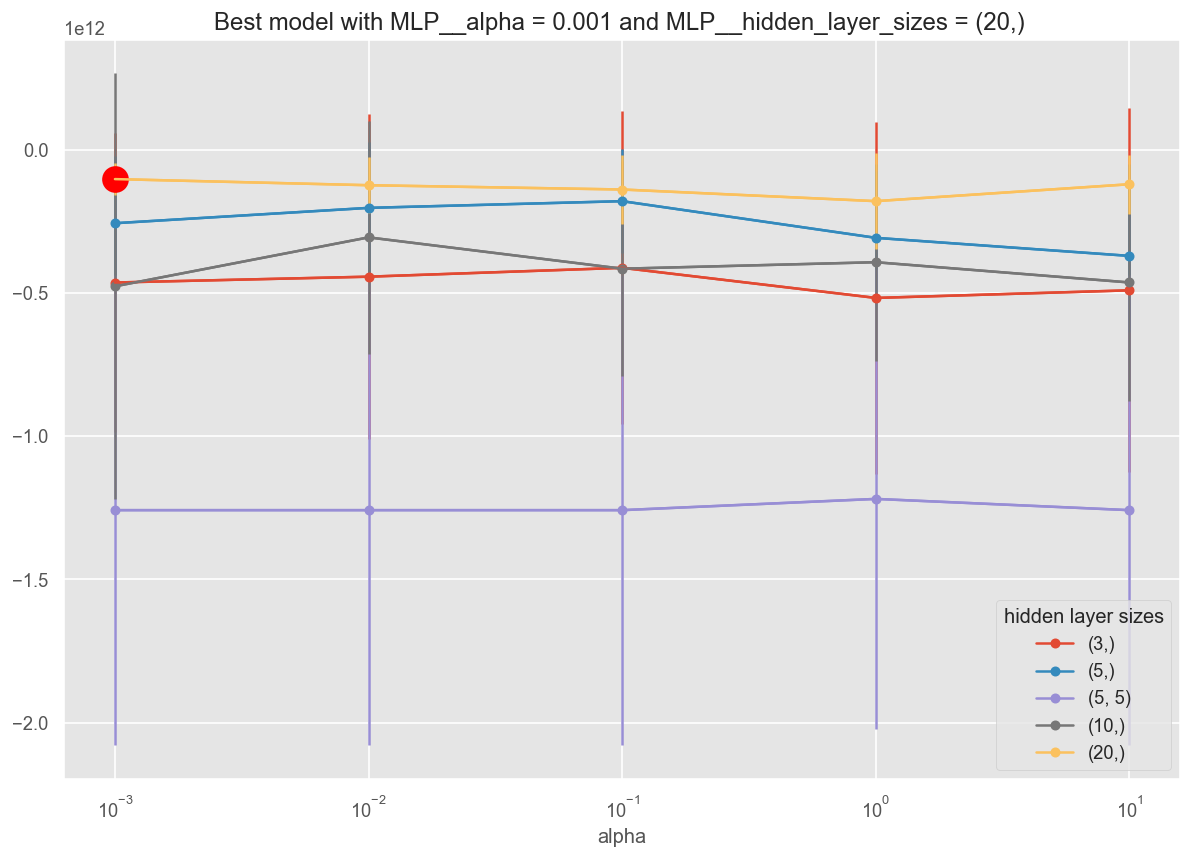

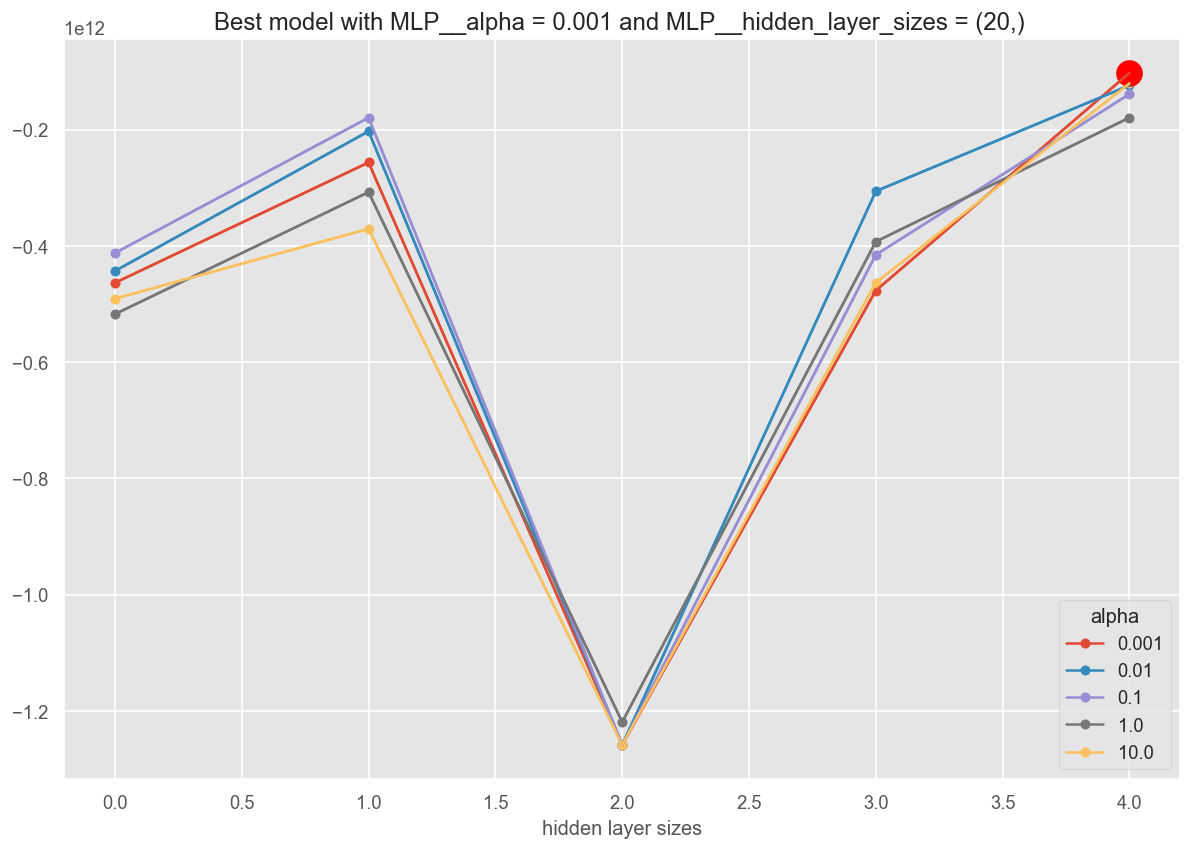

In [62]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [63]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train2) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X.toarray(), columns=coefnames)
y = pd.DataFrame(y_train2, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [35, 20, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                         mean           std  mean_squared
num__TOTAL_lag1 -1.931368e+06  2.973304e+07  2.979570e+07
num__TOTAL_lag2 -1.922403e+06  2.959502e+07  2.965739e+07
num__TOTAL_lag3 -1.910665e+06  2.941432e+07  2.947631e+07
cat__MONTH_2    -5.103648e+05  7.856966e+06  7.873525e+06
cat__MONTH_3    -5.047697e+05  7.770832e+06  7.787209e+06
cat__MONTH_4    -5.204986e+05  8.012975e+06  8.029862e+06
cat__MONTH_5    -5.076426e+05  7.815059e+06  7.831529e+06
cat__MONTH_6    -4.999070e+05  7.695970e+06  7.712189e+06
cat__MONTH_7    -4.952052e+05  7.623587e+06  7.639654e+06
cat__MONTH_8    -5.030327e+05  7.744090e+06  7.760411e+06
cat__MONTH_9    -5.073969e+05  7.811277e+06  7.827739e+06
cat__MONTH_10   -5.190495e+05  7.990665e+06  8.007505e+06
cat__MONTH_11   -5.156929e+05  7.938992e+06  7.955724e+06
cat__MONTH_12   -5.231663e+05  8.054044e+06  8.071017e+06
cat__YEAR_2002  -1.961345e+05  3.

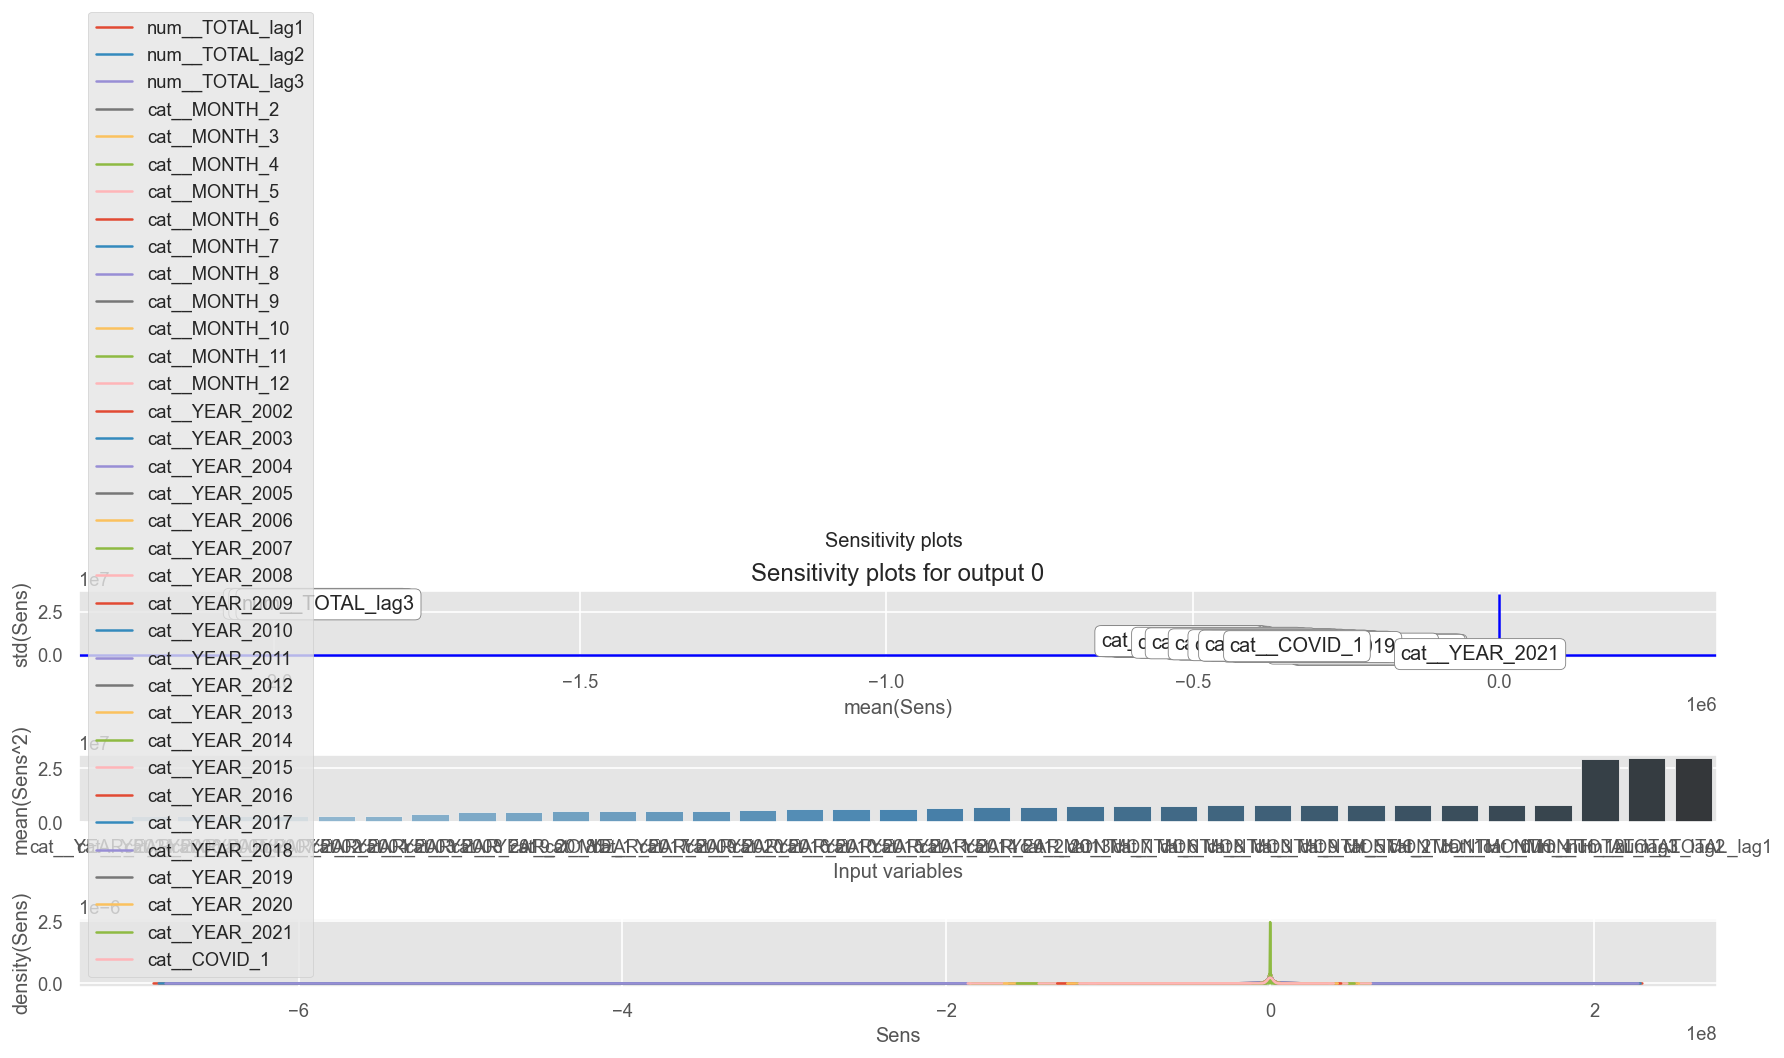

In [64]:
sensmlp.plot()

In [70]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train2)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test2)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 152215.9111222303
Test MAE: 336159.05054076057
Training RMSE: 210275.4816625916
Test RMSE: 381209.79203947604
Training R2: 0.9573542471400002
Test R2: -0.24256937007069945


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


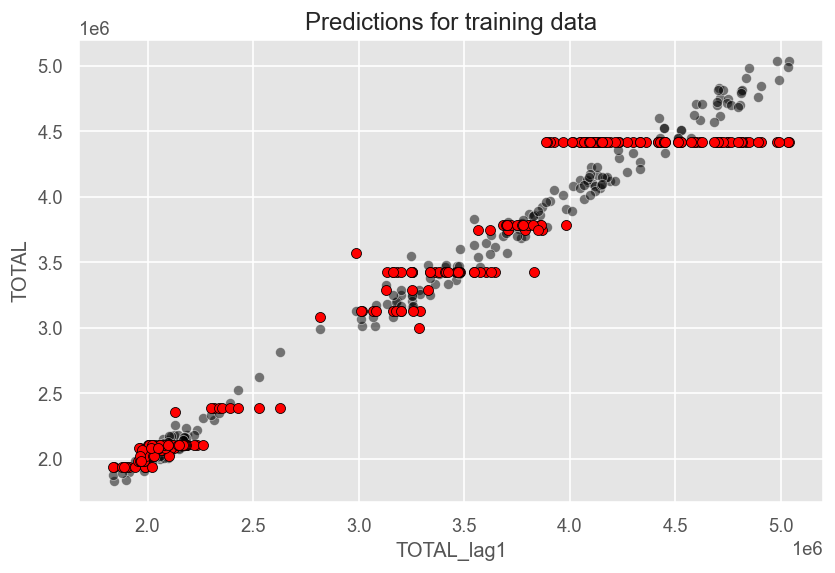

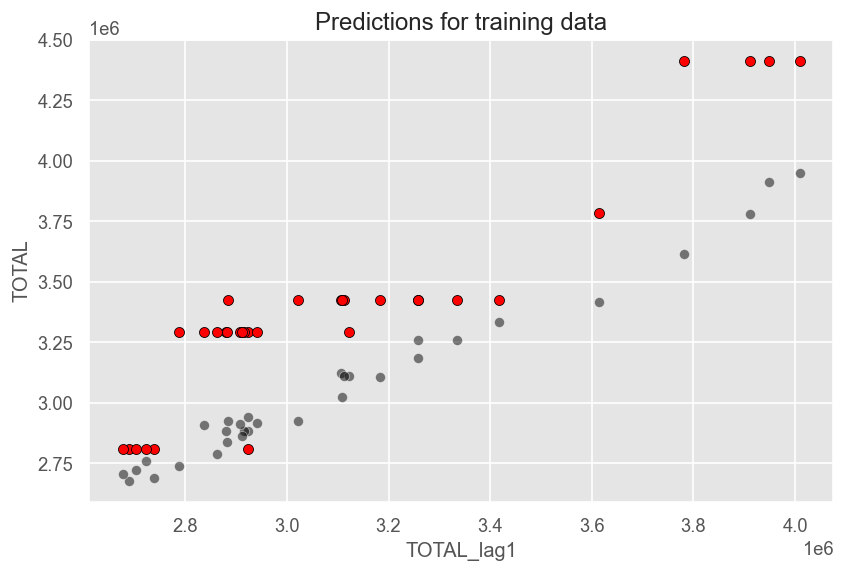

In [71]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

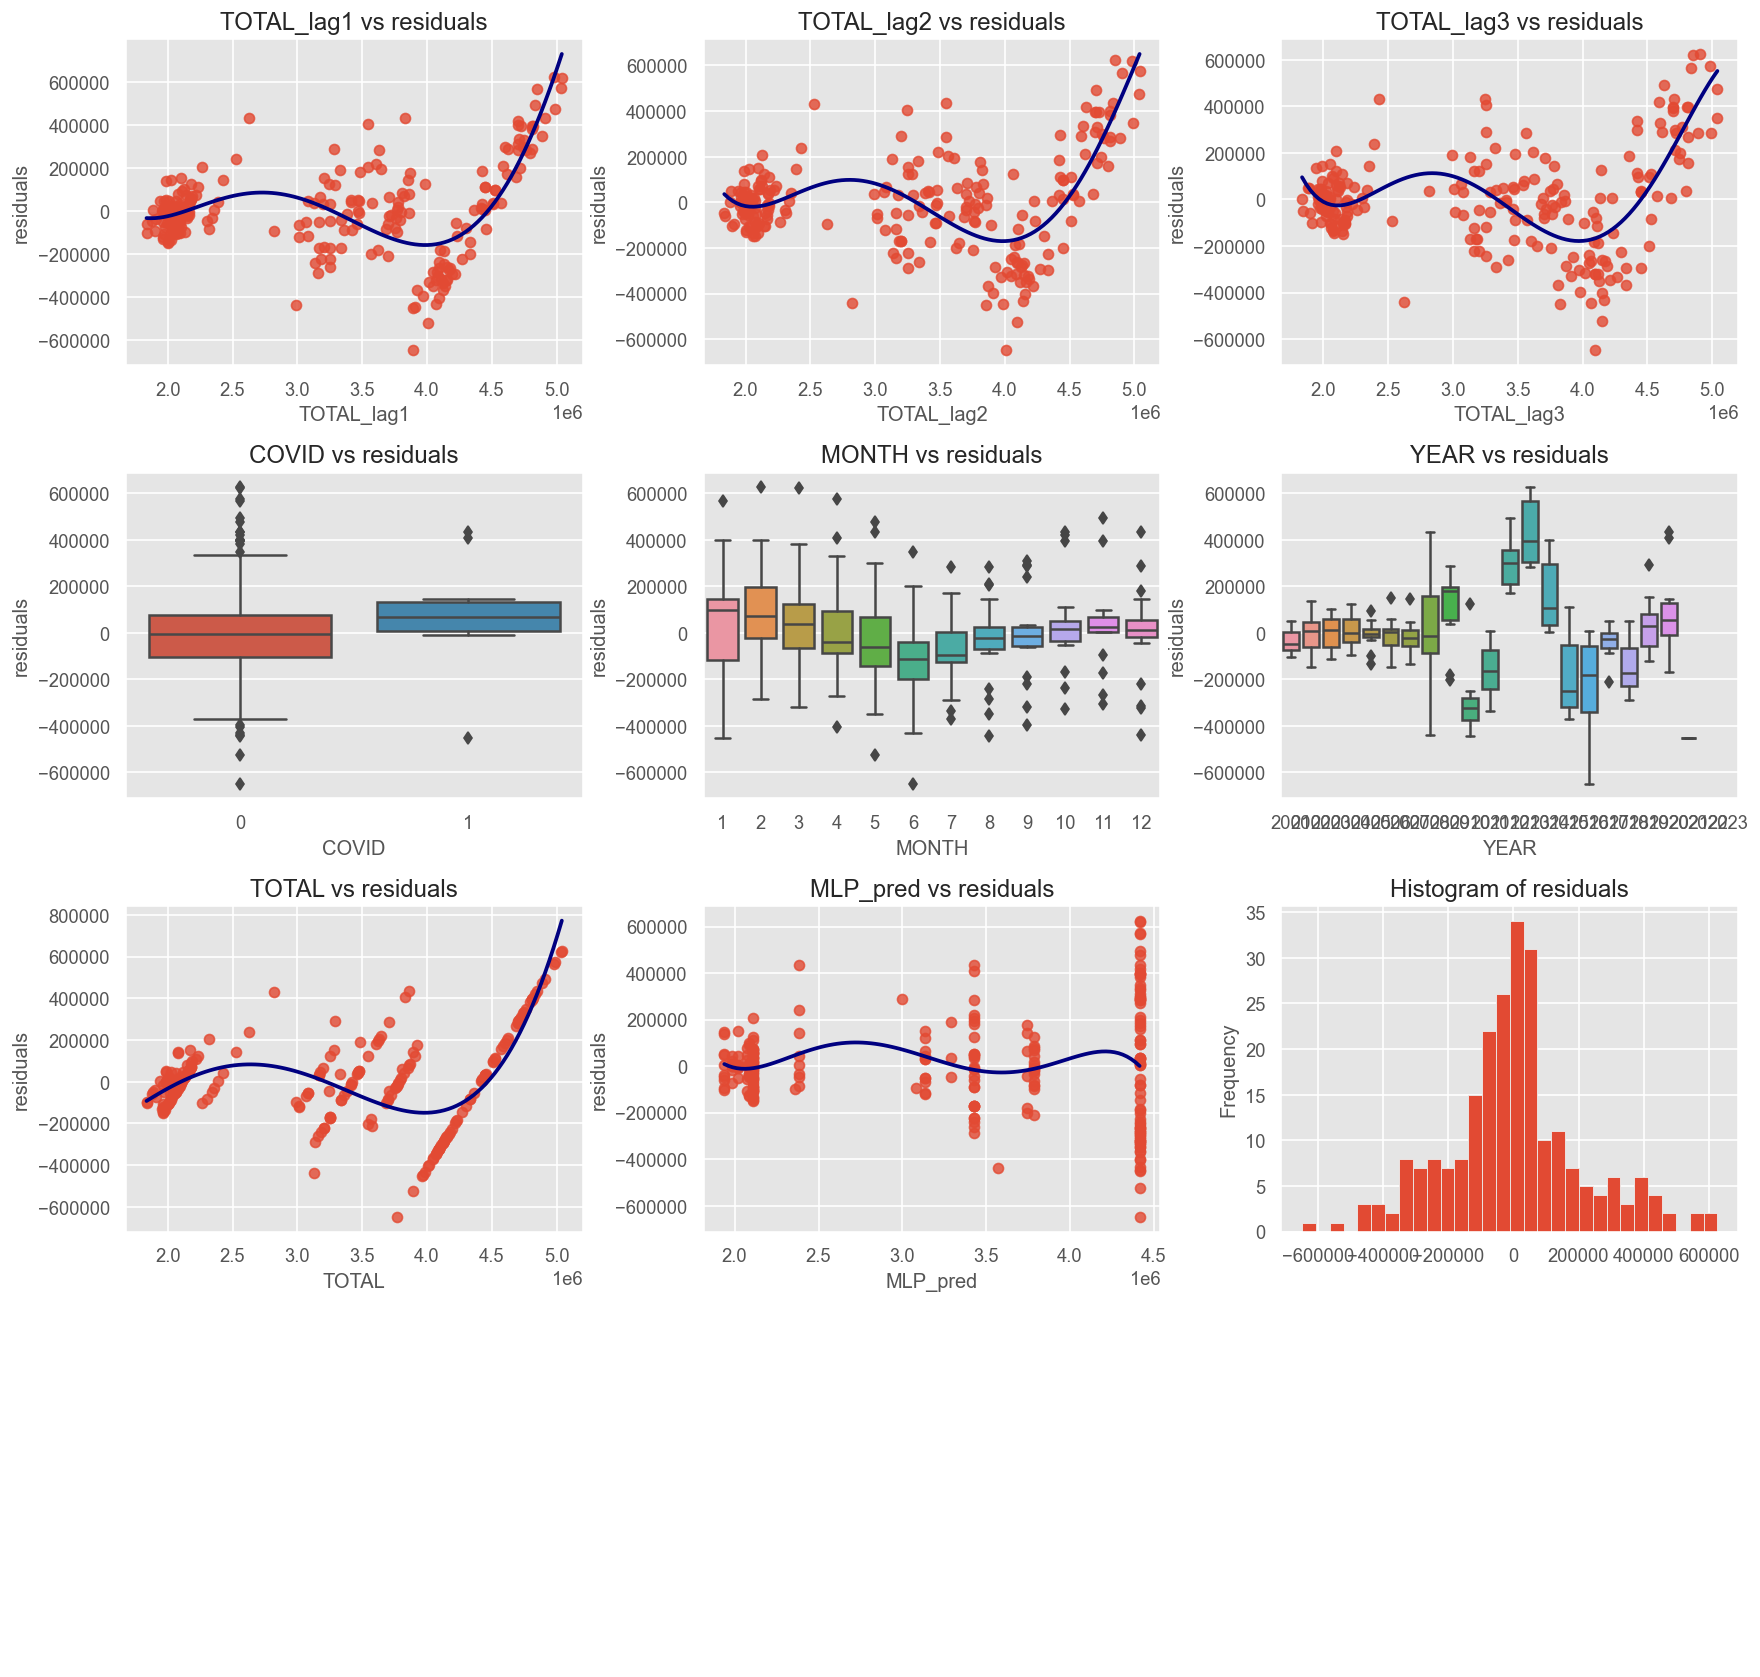

In [72]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

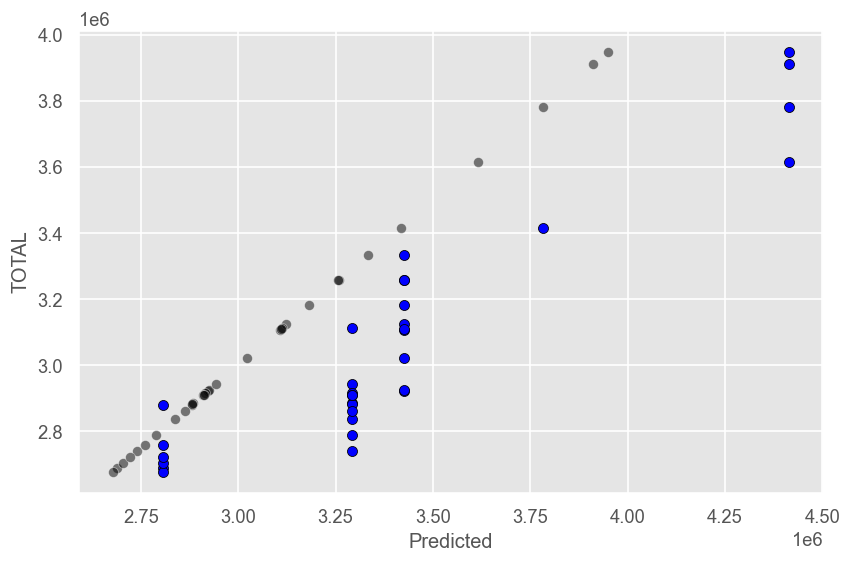

In [68]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 25 must be < 16.

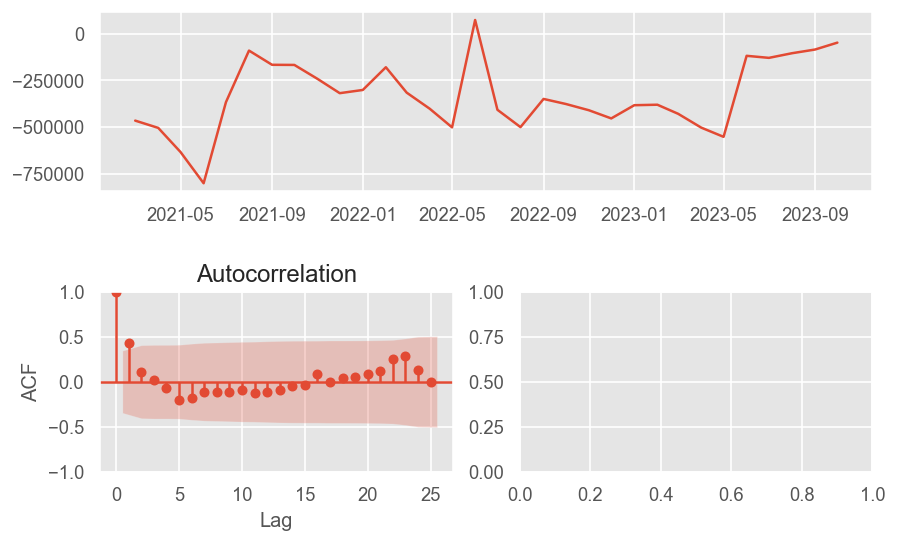

In [69]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'])

In [86]:
X_train 

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3 MONTH  YEAR
DATE                                                      
2001-04-01   1981006.0   1993273.0   2017389.0     4  2001
2001-05-01   1910453.0   1981006.0   1993273.0     5  2001
2001-06-01   1898285.0   1910453.0   1981006.0     6  2001
2001-07-01   1842556.0   1898285.0   1910453.0     7  2001
2001-08-01   1835738.0   1842556.0   1898285.0     8  2001
...                ...         ...         ...   ...   ...
2015-04-01   4451939.0   4512153.0   4525691.0     4  2015
2015-05-01   4333016.0   4451939.0   4512153.0     5  2015
2015-06-01   4215031.0   4333016.0   4451939.0     6  2015
2015-07-01   4120304.0   4215031.0   4333016.0     7  2015
2015-08-01   4046276.0   4120304.0   4215031.0     8  2015

[173 rows x 5 columns]

In [80]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity

In [74]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_SVG_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3']
INPUTS_SVG_CAT = ['MONTH','YEAR']
INPUTS_SVG = INPUTS_SVG_NUM + INPUTS_SVG_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop = 'first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_SVG_NUM),
        ('cat', categorical_transformer, INPUTS_SVG_CAT)
        ])

param = {'SVR__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVR__gamma':[0.0001,0.001,0.01,0.1,1,10,100,1000]} # Inverse width parameter in the Gaussian Radial Basis kernel 
pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('SVR', SVR(kernel='rbf')) # Gaussian kernel
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVR_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
SVR_fit.fit(X_train[INPUTS_SVG_NUM + INPUTS_SVG_CAT], y_train) # Search in grid
print("SVR Trained")

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
 

SVR Trained


/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
 

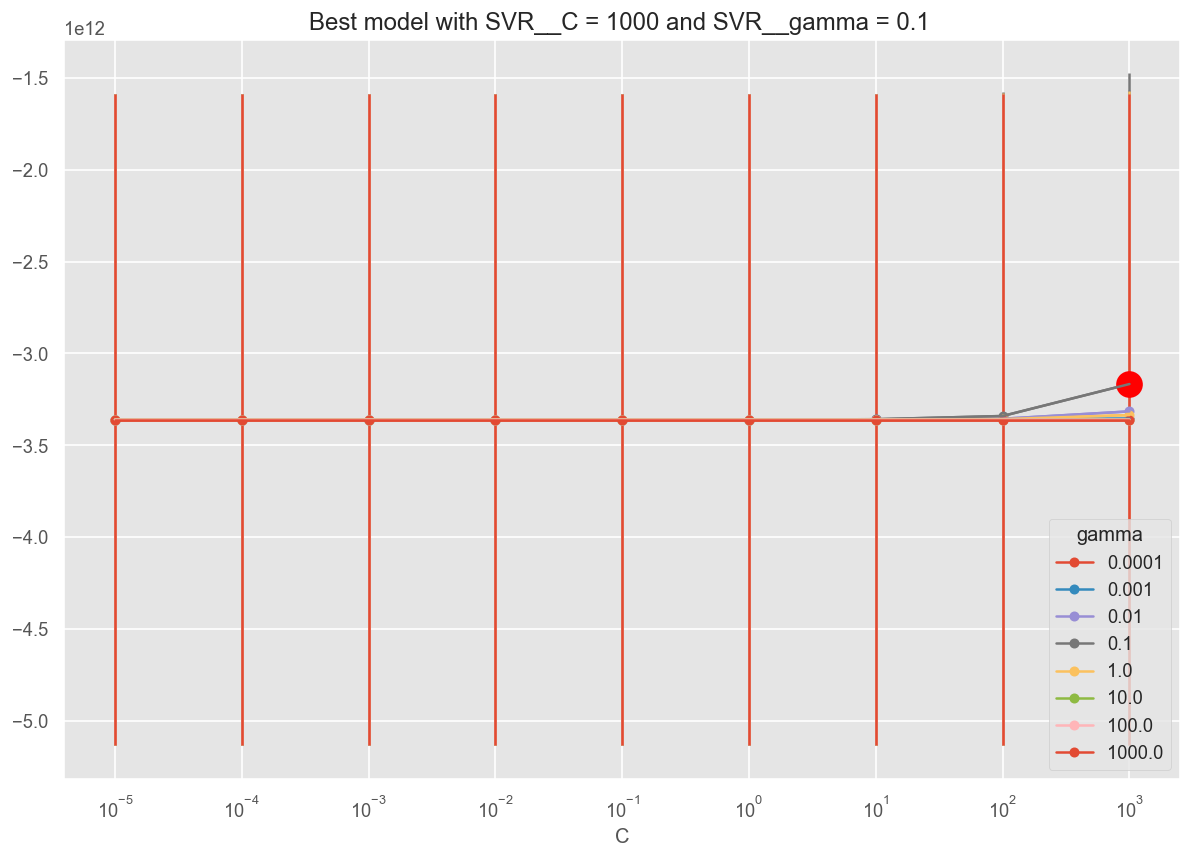

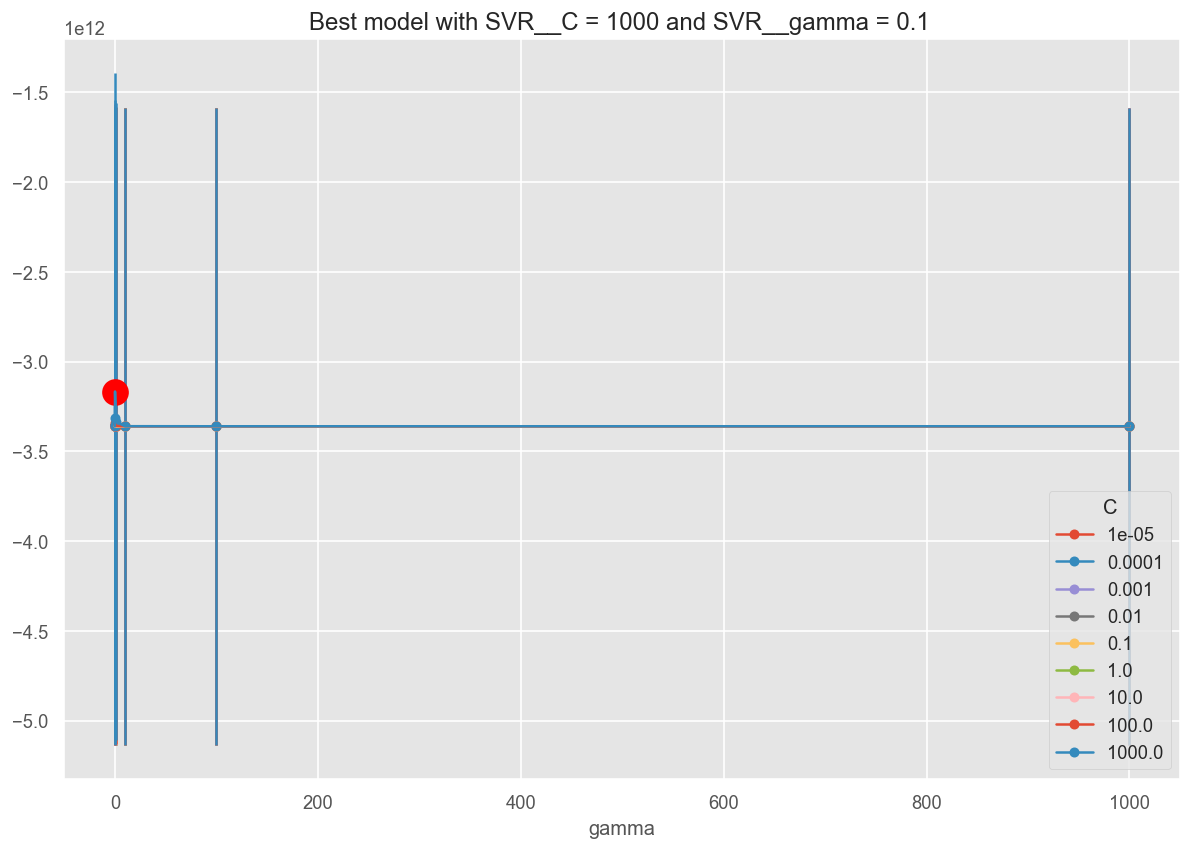

In [75]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(SVR_fit, xscale="log")

In [81]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['SVR_pred'] = SVR_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['SVR_pred'] = SVR_fit.predict(X_test)

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['SVR_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['SVR_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['SVR_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['SVR_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['SVR_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['SVR_pred']))

Training MAE: 1042723.5136197072
Test MAE: 1127048.8873412516
Training RMSE: 1336174.5644661358
Test RMSE: 1167694.928217127
Training R2: -0.33299555954533067
Test R2: -12.575296702130226


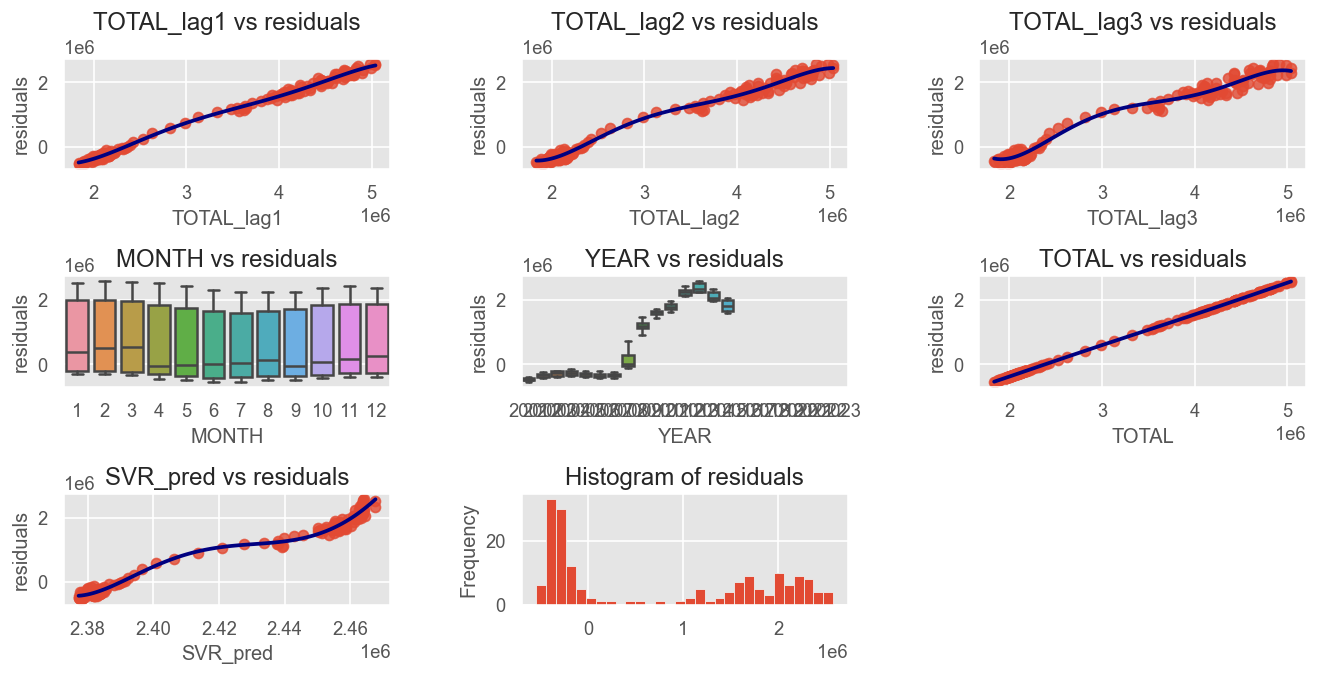

In [83]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'SVR_pred', 'TOTAL')

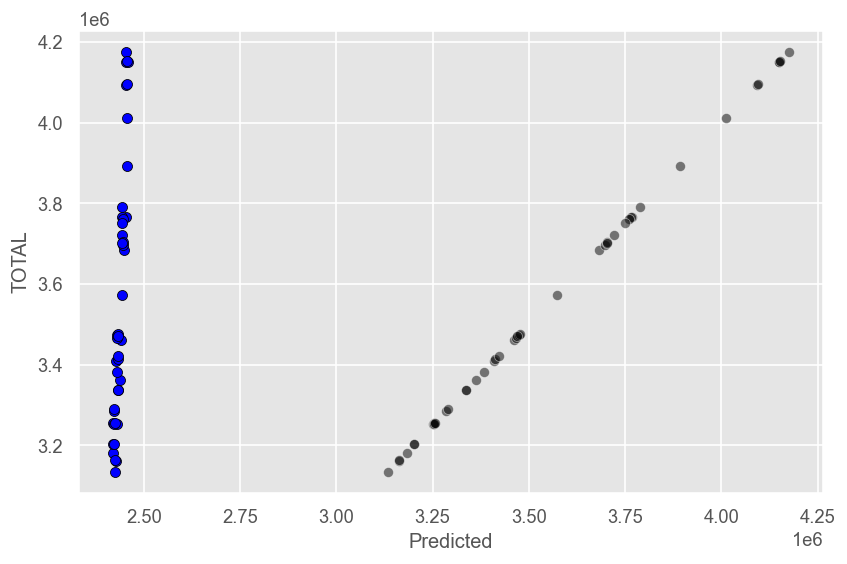

In [84]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='SVR_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

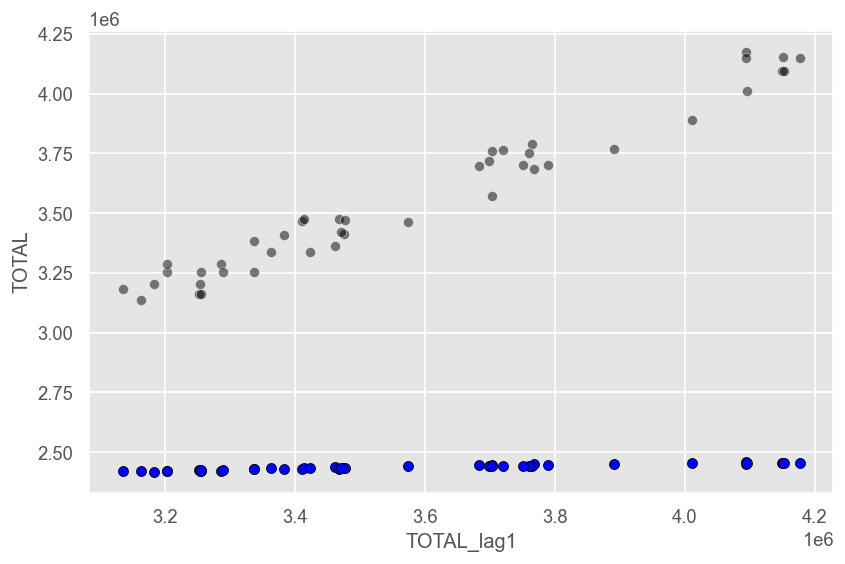

In [85]:
# Visualize prediction with respect to temperature
sns.scatterplot(data=dfTS_eval, x='TOTAL_lag1', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='TOTAL_lag1', y='SVR_pred', color='blue', edgecolor='black')
plt.show()

In [150]:
 df

TOTAL  COVID  CRISIS  YEAR MONTH
DATE                                          
2001-01-01  2017389      0       0  2001     1
2001-02-01  1993273      0       0  2001     2
2001-03-01  1981006      0       0  2001     3
2001-04-01  1910453      0       0  2001     4
2001-05-01  1898285      0       0  2001     5
...             ...    ...     ...   ...   ...
2023-06-01  2688842      0       0  2023     6
2023-07-01  2677874      0       0  2023     7
2023-08-01  2702700      0       0  2023     8
2023-09-01  2722468      0       0  2023     9
2023-10-01  2759404      0       0  2023    10

[274 rows x 5 columns]

In [157]:
# Define input and output matrices
prop_train=0.88
dfT=df.copy()
dfT['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
periodo_covid_fin_2 = pd.to_datetime('2022-09-01') #Parece que aquí termina su influencia en nuestra serie


# Establecer los valores de la columna 'Periodo_Covid' a 1 dura
dfT.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] =1

dfT['TOTAL_lag1'] = dfT['TOTAL'].shift(1)
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag12'] = dfT['TOTAL'].shift(12)
dfT['COVID'].astype('category')

# Remove missing
dfT.dropna(inplace=True)
dfT.head()
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag12','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2

TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  COVID
DATE                                                  
2002-01-01   1988716.0   1985857.0    2017389.0      0
2002-02-01   2075022.0   1988716.0    1993273.0      0
2002-03-01   2149907.0   2075022.0    1981006.0      0
2002-04-01   2083103.0   2149907.0    1910453.0      0
2002-05-01   2060069.0   2083103.0    1898285.0      0
...                ...         ...          ...    ...
2020-11-01   3826043.0   3776485.0    3198184.0      1
2020-12-01   3851312.0   3826043.0    3163605.0      1
2021-01-01   3888137.0   3851312.0    3253853.0      1
2021-02-01   3964353.0   3888137.0    3246047.0      1
2021-03-01   4008789.0   3964353.0    3548312.0      1

[231 rows x 4 columns]

In [152]:
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Assuming you already have X_train2 and y_train2

# Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR_NUM = ['TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag12']
INPUTS_LR_CAT = ["COVID"]
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories DROPPING FIRST CATEGORY (DUMMY ENCODE)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS_LR_NUM),
    ('cat', categorical_transformer, INPUTS_LR_CAT)
])

# Combine preprocessing and linear regression into a pipeline
pipe = Pipeline(steps=[
    ('Prep', preprocessor),  # Preprocess the variables when training the model
])

# Split the data into training and testing sets
 
# Apply the preprocessor to X_train
X_train_processed = preprocessor.fit_transform(X_train2)

# Add a constant for intercept term
X_train_processed = sm.add_constant(X_train2)

# Train the linear regression model with Statsmodels
model = sm.OLS(y_train2, X_train_processed).fit()

# Print the summary, including p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  TOTAL   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.619e+04
Date:                Thu, 30 Nov 2023   Prob (F-statistic):          1.69e-276
Time:                        10:30:02   Log-Likelihood:                -2865.1
No. Observations:                 231   AIC:                             5740.
Df Residuals:                     226   BIC:                             5757.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.229e+04   1.35e+04      1.646      

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [153]:


print(X_train2)

# Add a constant for intercept term
X_train2_pred = sm.add_constant(X_train2)

# Make predictions
predictions_train = model.predict(X_train2_pred)

# Add a constant for intercept term
X_test2_pred = sm.add_constant(X_test2)

# Make predictions
predictions_test = model.predict(X_test2_pred)


# Print predictions
print("Predictions:", predictions_test)

dfTR_eval['LR_pred'] = predictions_train
dfTS_eval['LR_pred'] = predictions_test

            TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  COVID
DATE                                                  
2002-01-01   1988716.0   1985857.0    2017389.0      0
2002-02-01   2075022.0   1988716.0    1993273.0      0
2002-03-01   2149907.0   2075022.0    1981006.0      0
2002-04-01   2083103.0   2149907.0    1910453.0      0
2002-05-01   2060069.0   2083103.0    1898285.0      0
...                ...         ...          ...    ...
2020-11-01   3826043.0   3776485.0    3198184.0      1
2020-12-01   3851312.0   3826043.0    3163605.0      1
2021-01-01   3888137.0   3851312.0    3253853.0      1
2021-02-01   3964353.0   3888137.0    3246047.0      1
2021-03-01   4008789.0   3964353.0    3548312.0      1

[231 rows x 4 columns]
Predictions: DATE
2021-05-01    3.908950e+06
2021-06-01    3.731654e+06
2021-07-01    3.545393e+06
2021-08-01    3.310699e+06
2021-09-01    3.289255e+06
2021-10-01    3.216209e+06
2021-11-01    3.255206e+06
2021-12-01    3.141573e+06
2022-01-01    3.062988e+06


In [154]:
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['LR_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['LR_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['LR_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['LR_pred']))

Training MAE: 45908.65299798184
Test MAE: 43447.33295904504
Training RMSE: 58930.95069622369
Test RMSE: 55536.90079785366
Training R2: 0.9965219219280481
Test R2: 0.9569629446091603


c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

c:\Users\LOLI\anaconda3\envs\ML\Lib\site-packages\seaborn\regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


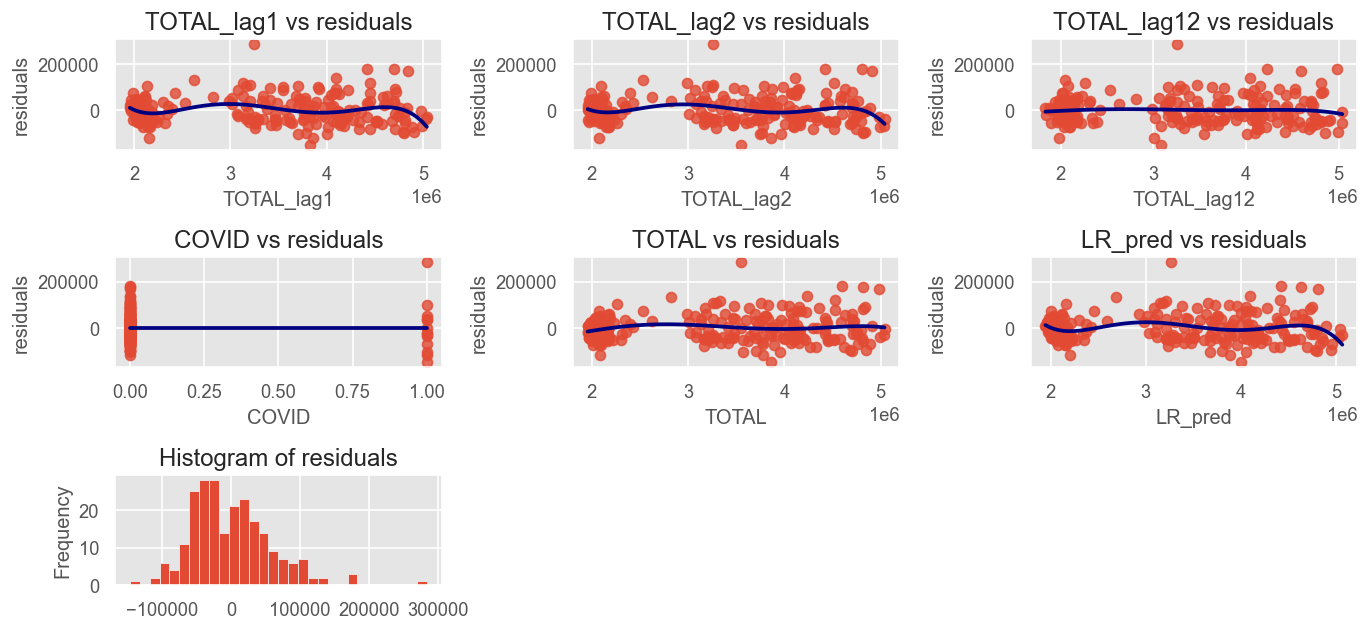

In [155]:
RT.plotModelDiagnosis(dfTR_eval, 'LR_pred', 'TOTAL') 

In [145]:
from scipy.stats import spearmanr

correlation, p_value = spearmanr(dfT['TOTAL_lag1'],dfT['TOTAL_lag2'] )

correlation


0.9936689618170438

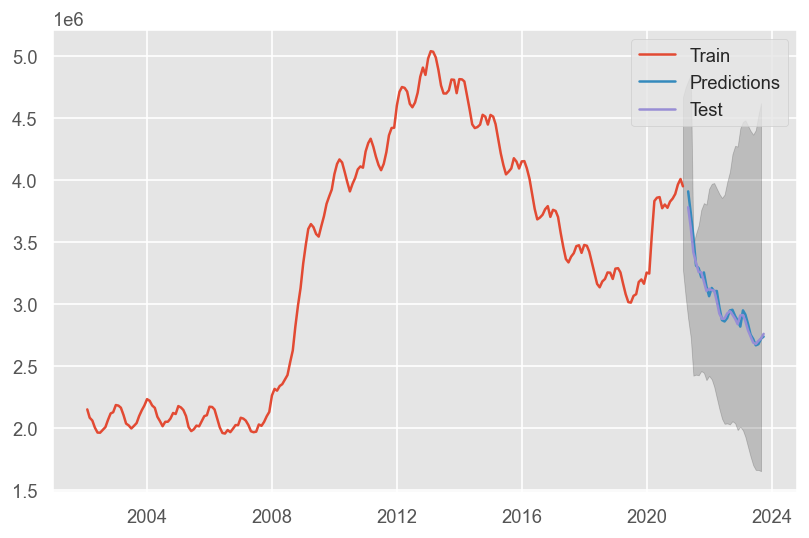

In [156]:

 #Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])


yhat = predictions_test
 


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()
